In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV 

import warnings
warnings.filterwarnings("ignore")

## 1. Load, Visualization and Exploration of Data

#### Two main goals:
1. Establish the potential effect of each predictor variable on well performance.
2. Estimating the range of well performance for an area (given the certain geological properties)

### 1.1. Data Load

In [2]:
#Load data
train_feat = pd.read_excel("project_data.xlsx", sheet_name = "train_features_completion", index_col='Unnamed: 0')

train_target = pd.read_excel("project_data.xlsx", sheet_name = "train_target",index_col='Unnamed: 0')

new = pd.read_excel("project_data.xlsx", sheet_name = "new_unseen_data",index_col='Unnamed: 0') 

In [3]:
train_feat.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)       TVD(M)  \
653      1.000                3                  400      349.7  2956.900756   
1591     0.889                2                  200      263.6  2956.900756   
1307     0.889                4                  200      199.4  2956.900756   
539      0.889                4                  200      155.5  2956.900756   
682      1.000                4                  300      263.3  2956.900756   

      LATERAL LENGTH (M)  STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
653                 3500      46             92                 2000.0   
1591                5300      78            156                 1132.1   
1307                4000     116            116                 4500.0   
539                 3100      34             68                 4516.1   
682                 3500      34             68                 3000.0   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
653                     20.0         18   177             42   
1591                     9.5         18   177             42   
1307                    18.0         18   177             42   
539                     18.1         18   177             42   
682                     12.0         18   177             42   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY  
653             154.97467              94.973062  
1591            116.54221             105.143550  
1307            169.71684             365.525890  
539             154.53355             317.082440  
682             140.73170             310.171940

In [4]:
train_target.head()

REC. EFFICIENCY (GAS)  REC. EFFICIENCY (OIL)   DRILLING COST  \
653                0.434648                      0     3396.489455   
1591               0.682453                      0     5152.752393   
1307               0.734736                      0     3884.340271   
539                0.709425                      0     3006.208802   
682                0.523262                      0     3396.489455   

      COMPLETION COST  EQUIPMENT COST  TOTAL WELL COST      IP90 GAS  \
653       4707.802059             300      8404.291514   7888.914474   
1591      4475.043418             300      9927.795810  10600.657895   
1307      7522.065922             300     11706.406193   9868.421053   
539       5276.606255             300      8582.815057   5897.587719   
682       4233.663765             300      7930.153221   5629.418860   

      IP90 OIL    IP90 COND  GAS (EUR)  ...  EFFECTIVE IRR       PV(10)  \
653          0   980.072400   5.661301  ...       0.853884  6930.382442   
1591         0  1322.339656   6.712743  ...       1.087076  9552.278968   
1307         0  1225.836002   5.392724  ...       0.728381  7666.190920   
539          0   733.098023   4.067688  ...       0.409468  4064.735533   
682          0   705.628719   5.131829  ...       0.468071  5073.862174   

           PV(15)   Royalty    PAYOUT       LIFE    NETBACK       F&D  \
653   5358.070652  0.082517  1.333333  40.000000  14.327106  5.133588   
1591  7588.689882  0.090752  1.166667  40.000000  14.497720  5.089388   
1307  6020.435025  0.050019  1.416667  34.166667  15.766205  7.385450   
539   2771.923567  0.048097  2.083333  36.583333  14.814777  7.277691   
682   3468.582212  0.065236  2.000000  40.000000  14.407753  5.391182   

      RECYCLE RATIO   PV15 PI  
653        2.790856  1.664542  
1591       2.848618  1.796763  
1307       2.134766  1.536067  
539        2.035642  1.336641  
682        2.672466  1.455917  

[5 rows x 22 columns]

#### Features

In [5]:
#Features
train_feat.columns

Index(['LL MULTI', 'SAND CONC MODEL', 'LATERAL SPACING (M)', 'AREA (AC)',
       'TVD(M)', 'LATERAL LENGTH (M)', 'STAGES', 'PERF CLUSTERS',
       'SAND INTENSITY(KG.M3)', 'FLUID INTENSITY (M3/M)', 'INJ. RATE', 'PERM',
       'PAY THICKNESS', 'FRACTURE 1/2 LENGTH', 'FRACTURE CONDUCTIVITY'],
      dtype='object')

In [6]:
train_feat.describe()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)    AREA (AC)  \
count  1285.000000      1285.000000          1285.000000  1285.000000   
mean      0.944802         3.004669           356.933852   347.370272   
std       0.055521         0.819340           123.615319   158.168099   
min       0.889000         0.000000           200.000000   110.400000   
25%       0.889000         2.000000           200.000000   224.300000   
50%       1.000000         3.000000           300.000000   309.800000   
75%       1.000000         4.000000           400.000000   448.600000   
max       1.000000         4.000000           536.000000   801.600000   

             TVD(M)  LATERAL LENGTH (M)       STAGES  PERF CLUSTERS  \
count  1.285000e+03         1285.000000  1285.000000    1285.000000   
mean   2.956901e+03         3895.501946    70.221012      94.133074   
std    7.096821e-11         1105.093419    32.987622      29.907180   
min    2.956901e+03         2200.000000    25.000000      49.000000   
25%    2.956901e+03         3100.000000    46.000000      68.000000   
50%    2.956901e+03         4000.000000    65.000000      91.000000   
75%    2.956901e+03         4500.000000    91.000000     116.000000   
max    2.956901e+03         6000.000000   155.000000     156.000000   

       SAND INTENSITY(KG.M3)  FLUID INTENSITY (M3/M)  INJ. RATE    PERM  \
count            1285.000000             1285.000000     1285.0  1285.0   
mean             2721.288839               18.394599       18.0   177.0   
std              1196.769557               10.525048        0.0     0.0   
min              1000.000000                4.000000       18.0   177.0   
25%              2000.000000               10.600000       18.0   177.0   
50%              3000.000000               16.000000       18.0   177.0   
75%              4000.000000               22.700000       18.0   177.0   
max              4545.500000               45.500000       18.0   177.0   

       PAY THICKNESS  FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY  
count    1285.000000          1285.000000            1285.000000  
mean       41.962646           163.006643             201.204228  
std         0.668731            36.425999              97.729975  
min        30.000000            87.609094              88.630919  
25%        42.000000           136.211660             108.886080  
50%        42.000000           160.519880             176.328790  
75%        42.000000           187.541580             301.886290  
max        42.000000           254.072020             375.121530

In [7]:
train_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 653 to 257
Data columns (total 15 columns):
LL MULTI                  1285 non-null float64
SAND CONC MODEL           1285 non-null int64
LATERAL SPACING (M)       1285 non-null int64
AREA (AC)                 1285 non-null float64
TVD(M)                    1285 non-null float64
LATERAL LENGTH (M)        1285 non-null int64
STAGES                    1285 non-null int64
PERF CLUSTERS             1285 non-null int64
SAND INTENSITY(KG.M3)     1285 non-null float64
FLUID INTENSITY (M3/M)    1285 non-null float64
INJ. RATE                 1285 non-null int64
PERM                      1285 non-null int64
PAY THICKNESS             1285 non-null int64
FRACTURE 1/2 LENGTH       1285 non-null float64
FRACTURE CONDUCTIVITY     1285 non-null float64
dtypes: float64(7), int64(8)
memory usage: 160.6 KB


#### Variance inflation factor (VIF)

In [8]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [9]:
calc_vif(train_feat)

variables        VIF
0                 LL MULTI   1.233287
1          SAND CONC MODEL   2.955775
2      LATERAL SPACING (M)  13.696893
3                AREA (AC)  21.864909
4                   TVD(M)   0.002399
5       LATERAL LENGTH (M)  16.557891
6                   STAGES  10.357657
7            PERF CLUSTERS  21.341910
8    SAND INTENSITY(KG.M3)  15.440359
9   FLUID INTENSITY (M3/M)  16.778836
10               INJ. RATE   0.000000
11                    PERM   0.000000
12           PAY THICKNESS   1.204354
13     FRACTURE 1/2 LENGTH  21.323185
14   FRACTURE CONDUCTIVITY  15.026129

- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

# Model for Target: IP90 GAS

#### Target

In [10]:
#IP90 Gas
IP90_G=train_target['IP90 GAS']
IP90_G.head()

653      7888.914474
1591    10600.657895
1307     9868.421053
539      5897.587719
682      5629.418860
Name: IP90 GAS, dtype: float64

In [11]:
#IP90 Gas
feat_IP90G=pd.concat([IP90_G, train_feat], axis=1)

### 1.2. Visualization

#### Features and Target (IP90)

In [12]:
feat_target=pd.concat([train_feat, train_target], axis=1)
feat_target.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)       TVD(M)  \
653      1.000                3                  400      349.7  2956.900756   
1591     0.889                2                  200      263.6  2956.900756   
1307     0.889                4                  200      199.4  2956.900756   
539      0.889                4                  200      155.5  2956.900756   
682      1.000                4                  300      263.3  2956.900756   

      LATERAL LENGTH (M)  STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
653                 3500      46             92                 2000.0   
1591                5300      78            156                 1132.1   
1307                4000     116            116                 4500.0   
539                 3100      34             68                 4516.1   
682                 3500      34             68                 3000.0   

      FLUID INTENSITY (M3/M)  ...  EFFECTIVE IRR       PV(10)       PV(15)  \
653                     20.0  ...       0.853884  6930.382442  5358.070652   
1591                     9.5  ...       1.087076  9552.278968  7588.689882   
1307                    18.0  ...       0.728381  7666.190920  6020.435025   
539                     18.1  ...       0.409468  4064.735533  2771.923567   
682                     12.0  ...       0.468071  5073.862174  3468.582212   

       Royalty    PAYOUT       LIFE    NETBACK       F&D  RECYCLE RATIO  \
653   0.082517  1.333333  40.000000  14.327106  5.133588       2.790856   
1591  0.090752  1.166667  40.000000  14.497720  5.089388       2.848618   
1307  0.050019  1.416667  34.166667  15.766205  7.385450       2.134766   
539   0.048097  2.083333  36.583333  14.814777  7.277691       2.035642   
682   0.065236  2.000000  40.000000  14.407753  5.391182       2.672466   

       PV15 PI  
653   1.664542  
1591  1.796763  
1307  1.536067  
539   1.336641  
682   1.455917  

[5 rows x 37 columns]

In [13]:
feat_target.columns

Index(['LL MULTI', 'SAND CONC MODEL', 'LATERAL SPACING (M)', 'AREA (AC)',
       'TVD(M)', 'LATERAL LENGTH (M)', 'STAGES', 'PERF CLUSTERS',
       'SAND INTENSITY(KG.M3)', 'FLUID INTENSITY (M3/M)', 'INJ. RATE', 'PERM',
       'PAY THICKNESS', 'FRACTURE 1/2 LENGTH', 'FRACTURE CONDUCTIVITY',
       'REC. EFFICIENCY (GAS)', 'REC. EFFICIENCY (OIL)', ' DRILLING COST',
       'COMPLETION COST', 'EQUIPMENT COST', 'TOTAL WELL COST', 'IP90 GAS',
       'IP90 OIL', 'IP90 COND', 'GAS (EUR)', 'OIL (EUR)', 'COND (EUR)',
       'EFFECTIVE IRR', 'PV(10)', 'PV(15)', 'Royalty', 'PAYOUT', 'LIFE',
       'NETBACK', 'F&D', 'RECYCLE RATIO', 'PV15 PI'],
      dtype='object')

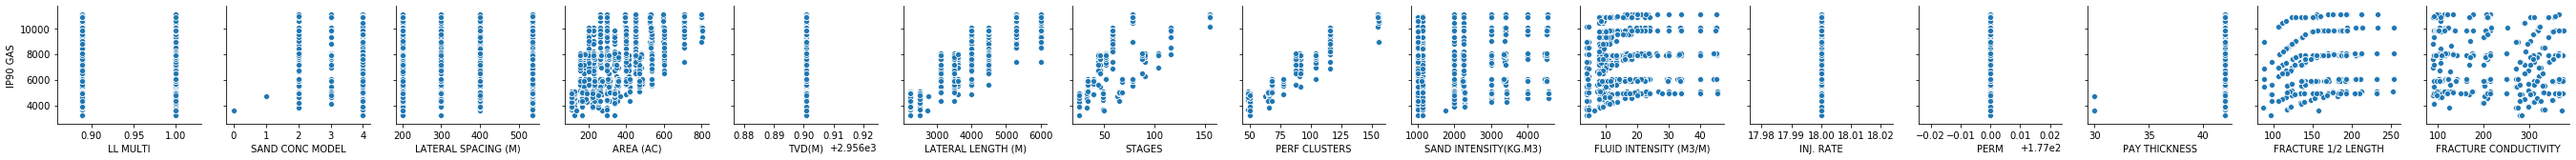

In [14]:
#IP90 GAS
sns.pairplot(feat_target, y_vars="IP90 GAS", x_vars=feat_target.iloc[:,:15].columns.values)
plt.show()

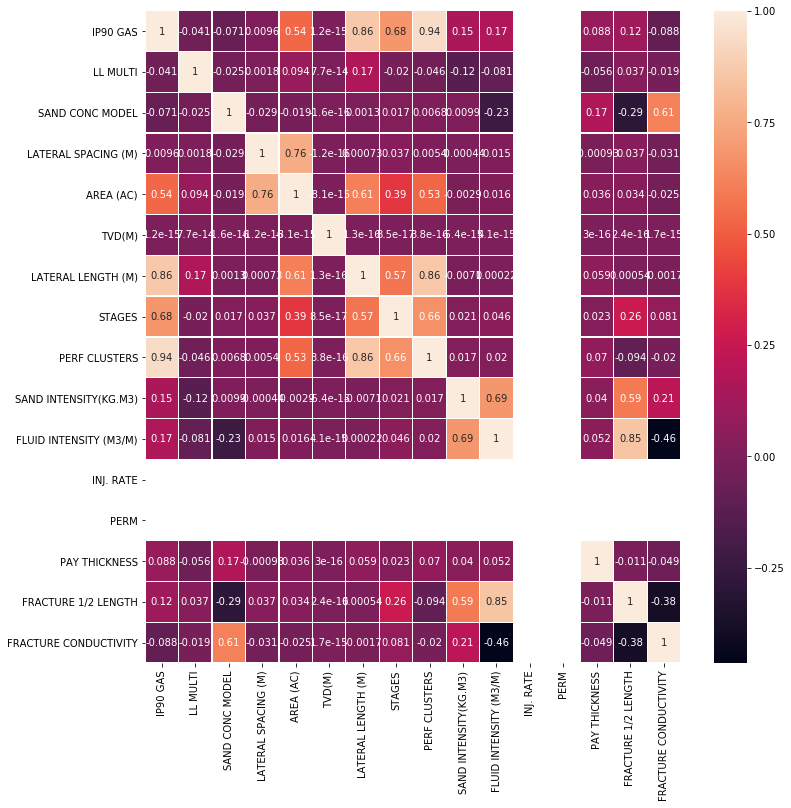

In [15]:
#Correlation matrix (Pearson)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = feat_IP90G.corr()
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

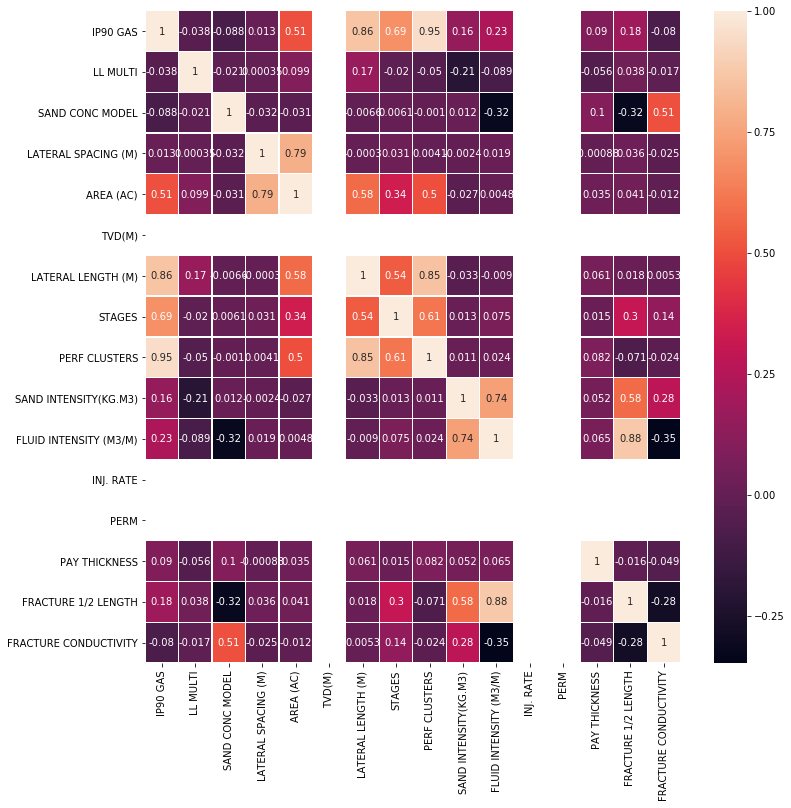

In [16]:
#Correlation matrix (spearman)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = feat_IP90G.corr(method='spearman')
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

In [17]:
def scatter_plot(y_test,y_pred):

    plt.figure(figsize=(12,8))
    ulim = np.max(y_test)
    llim = np.min(y_test)
    plt.scatter(y_test,y_pred)
    plt.plot([llim,ulim],[llim,ulim],linewidth=5, c='red')
    plt.title('Regression Scatter Plot', fontsize=25)
    plt.xlim([llim,ulim])
    plt.ylim([llim,ulim])
    plt.ylabel('Predicted', fontsize=15)
    plt.xlabel('Actual', fontsize=15)
    
    plt.show()

## 2. Data Split (Test/Train): IP90 Gas

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_feat, IP90_G, test_size=0.25, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)
print('Dimensions of y_train:',y_train.shape)
print('Dimensions of y_test:',y_test.shape)

Dimensions of X_train: (963, 15)
Dimensions of X_test: (322, 15)
Dimensions of y_train: (963,)
Dimensions of y_test: (322,)


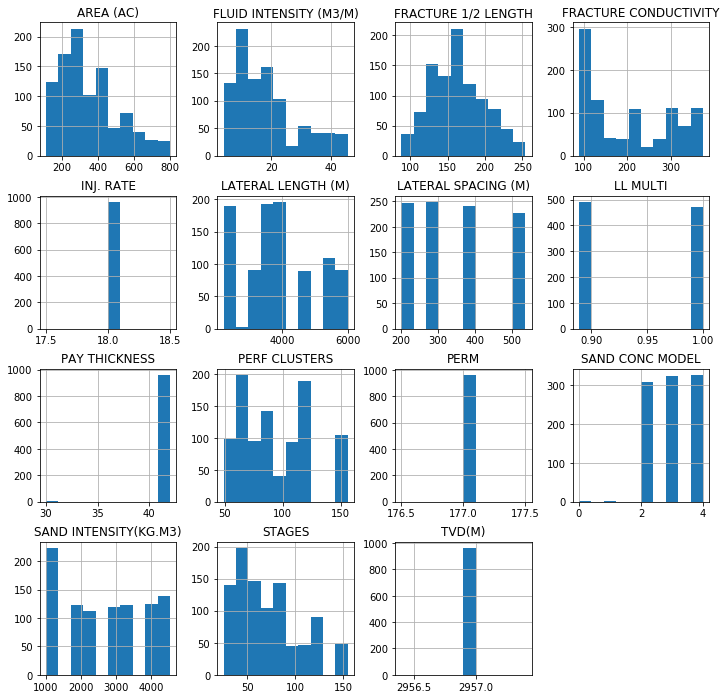

In [19]:
X_train.hist(figsize=(12,12))
plt.show()

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963 entries, 689 to 1554
Data columns (total 15 columns):
LL MULTI                  963 non-null float64
SAND CONC MODEL           963 non-null int64
LATERAL SPACING (M)       963 non-null int64
AREA (AC)                 963 non-null float64
TVD(M)                    963 non-null float64
LATERAL LENGTH (M)        963 non-null int64
STAGES                    963 non-null int64
PERF CLUSTERS             963 non-null int64
SAND INTENSITY(KG.M3)     963 non-null float64
FLUID INTENSITY (M3/M)    963 non-null float64
INJ. RATE                 963 non-null int64
PERM                      963 non-null int64
PAY THICKNESS             963 non-null int64
FRACTURE 1/2 LENGTH       963 non-null float64
FRACTURE CONDUCTIVITY     963 non-null float64
dtypes: float64(7), int64(8)
memory usage: 120.4 KB


## 3. Data Preprocessing

### 3.1. Feature Transform: MinMax Scaler

In [21]:
mscaler = MinMaxScaler(feature_range=(0, 1))

In [22]:
mscaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [23]:
X_train_scaled = mscaler.transform(X_train) # transform the train dataset to standardized data

# standardized training dataset
print("scaled minimum : %s " % np.min(X_train_scaled,axis=0))
print("scaled maximum : %s " % np.max(X_train_scaled,axis=0))

print("original minimum : %s " % mscaler.data_min_)
print("original maximum : %s " % mscaler.data_max_)

scaled minimum : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
scaled maximum : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 
original minimum : [8.89000000e-01 0.00000000e+00 2.00000000e+02 1.10400000e+02
 2.95690076e+03 2.20000000e+03 2.50000000e+01 4.90000000e+01
 1.00000000e+03 4.00000000e+00 1.80000000e+01 1.77000000e+02
 3.00000000e+01 8.76090940e+01 8.86309190e+01] 
original maximum : [1.00000000e+00 4.00000000e+00 5.36000000e+02 8.01600000e+02
 2.95690076e+03 6.00000000e+03 1.55000000e+02 1.56000000e+02
 4.54550000e+03 4.55000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 2.54072020e+02 3.75121530e+02] 


In [24]:
# scale the test data using the parameters learnt from the training dataset

X_test_scaled  = mscaler.transform(X_test)

print("minimum of scaled test data: %s" % np.min(X_test_scaled,axis=0))
print("maximum of scaled test data: %s " % np.max(X_test_scaled,axis=0))

## median of test data can be non-zero, and the IQR can be non-unitary
## just like the future data

minimum of scaled test data: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
maximum of scaled test data: [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 


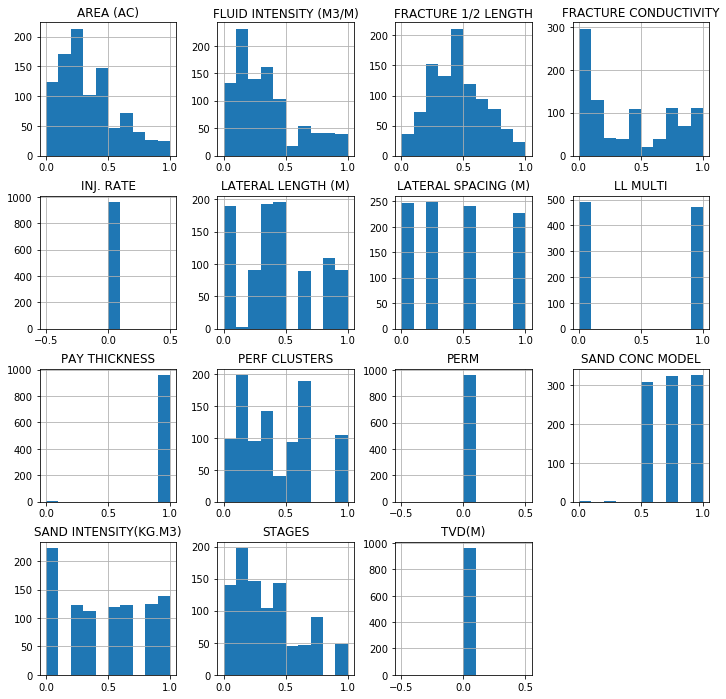

In [25]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

### 3.2. Feature Transform: Robust Scaler

In [26]:
# Robust Scaler
rscaler = RobustScaler() #instantiate
rscaler.fit(X_train) 

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [27]:
X_train_scaled = rscaler.transform(X_train) # transform the train dataset to standardized data

# Original training dataset
print("Original median : %s " % rscaler.center_)
print("Original IQR : %s " % rscaler.scale_)

#Scaled training dataset
print("Scaled median : %s " % np.median(X_train_scaled,axis=0))
print("Scaled IQR : %s " % (np.percentile(X_train_scaled, 75,axis=0)-np.percentile(X_train_scaled, 25,axis=0)))

Original median : [8.89000000e-01 3.00000000e+00 3.00000000e+02 3.09800000e+02
 2.95690076e+03 4.00000000e+03 5.80000000e+01 8.80000000e+01
 3.00000000e+03 1.60000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 1.56080510e+02 1.77499760e+02] 
Original IQR : [1.11000000e-01 2.00000000e+00 2.00000000e+02 2.25700000e+02
 1.00000000e+00 1.40000000e+03 4.40000000e+01 4.80000000e+01
 2.00000000e+03 1.20000000e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 5.08589900e+01 1.94208065e+02] 
Scaled median : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Scaled IQR : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.] 


In [28]:
#Scale the test data using the parameters learnt from the training dataset
X_test_scaled  = rscaler.transform(X_test)

print("Median of scaled test data: %s" % np.median(X_test_scaled,axis=0))
print("IQR of scaled test data: %s " % (np.percentile(X_test_scaled, 75,axis=0)-np.percentile(X_test_scaled, 25,axis=0)))

Median of scaled test data: [ 1.          0.          0.5         0.11785556  0.          0.
  0.15909091  0.0625      0.          0.          0.          0.
  0.          0.16016677 -0.04416022]
IQR of scaled test data: [1.         1.         1.18       0.96400089 0.         1.
 1.02272727 1.         0.9261375  0.95625    0.         0.
 0.         1.07477203 0.98993213] 


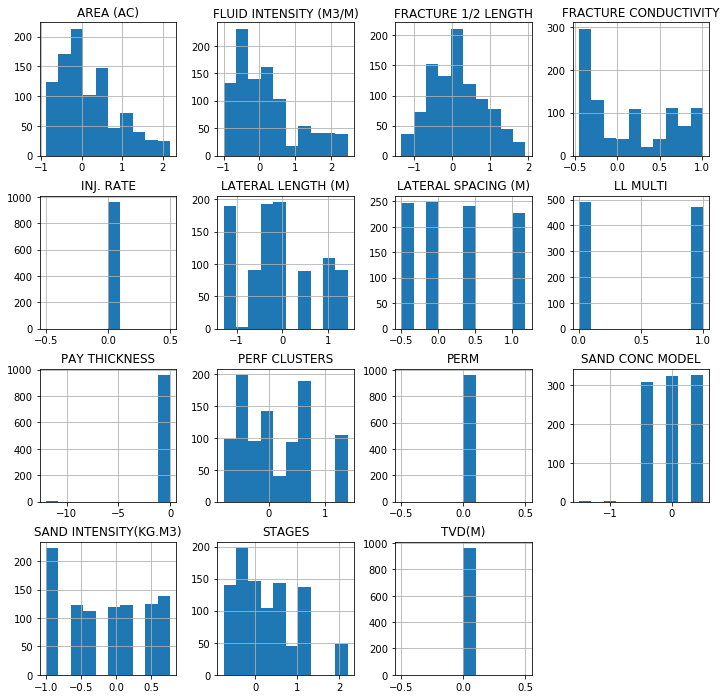

In [29]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

In [30]:
X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)

- Scaling is needed because the features have different ranges

### 3.3. Outlier Detection: Isolation Forest

In [31]:
# Isolation Forest
iforest = IsolationForest(n_estimators=200, contamination=0.08)
iforest = iforest.fit(X_train) #Training the model

In [32]:
#Predictions
X_train_predict = iforest.predict(X_train) 
X_train['Predict']=X_train_predict
X_train['Predict'] = X_train['Predict'].astype('category')
X_train

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   
...        ...              ...                  ...        ...     ...   
792        0.0             -0.5                 1.18   0.767390     0.0   
1617       0.0              0.0                 0.50   0.968542     0.0   
139        0.0              0.0                -0.50  -0.880815     0.0   
1803       1.0              0.0                -0.50  -0.047408     0.0   
1554       0.0              0.0                 0.00   0.383252     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   
...                  ...       ...            ...                    ...   
792            -0.285714  0.454545      -0.208333               -0.94445   
1617            0.928571  0.000000       0.583333               -0.36790   
139            -1.285714 -0.204545      -0.812500                0.20455   
1803            1.428571  1.318182       0.583333               -0.50000   
1554            0.928571  0.000000       0.583333               -0.93395   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   
...                      ...        ...   ...            ...   
792                -0.358333        0.0   0.0            0.0   
1617                0.550000        0.0   0.0            0.0   
139                 1.508333        0.0   0.0            0.0   
1803                0.333333        0.0   0.0            0.0   
1554               -0.391667        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY Predict  
689              0.262798               0.967360       1  
1740            -0.117428              -0.367979      -1  
945              0.736783               0.187212       1  
1576            -1.149778               0.541919      -1  
131              0.705289              -0.394607       1  
...                   ...                    ...     ...  
792              0.222537              -0.377114       1  
1617             0.288366              -0.410321       1  
139              1.487818              -0.295266       1  
1803             0.967157              -0.315834       1  
1554            -0.379853              -0.441523       1  

[963 rows x 16 columns]

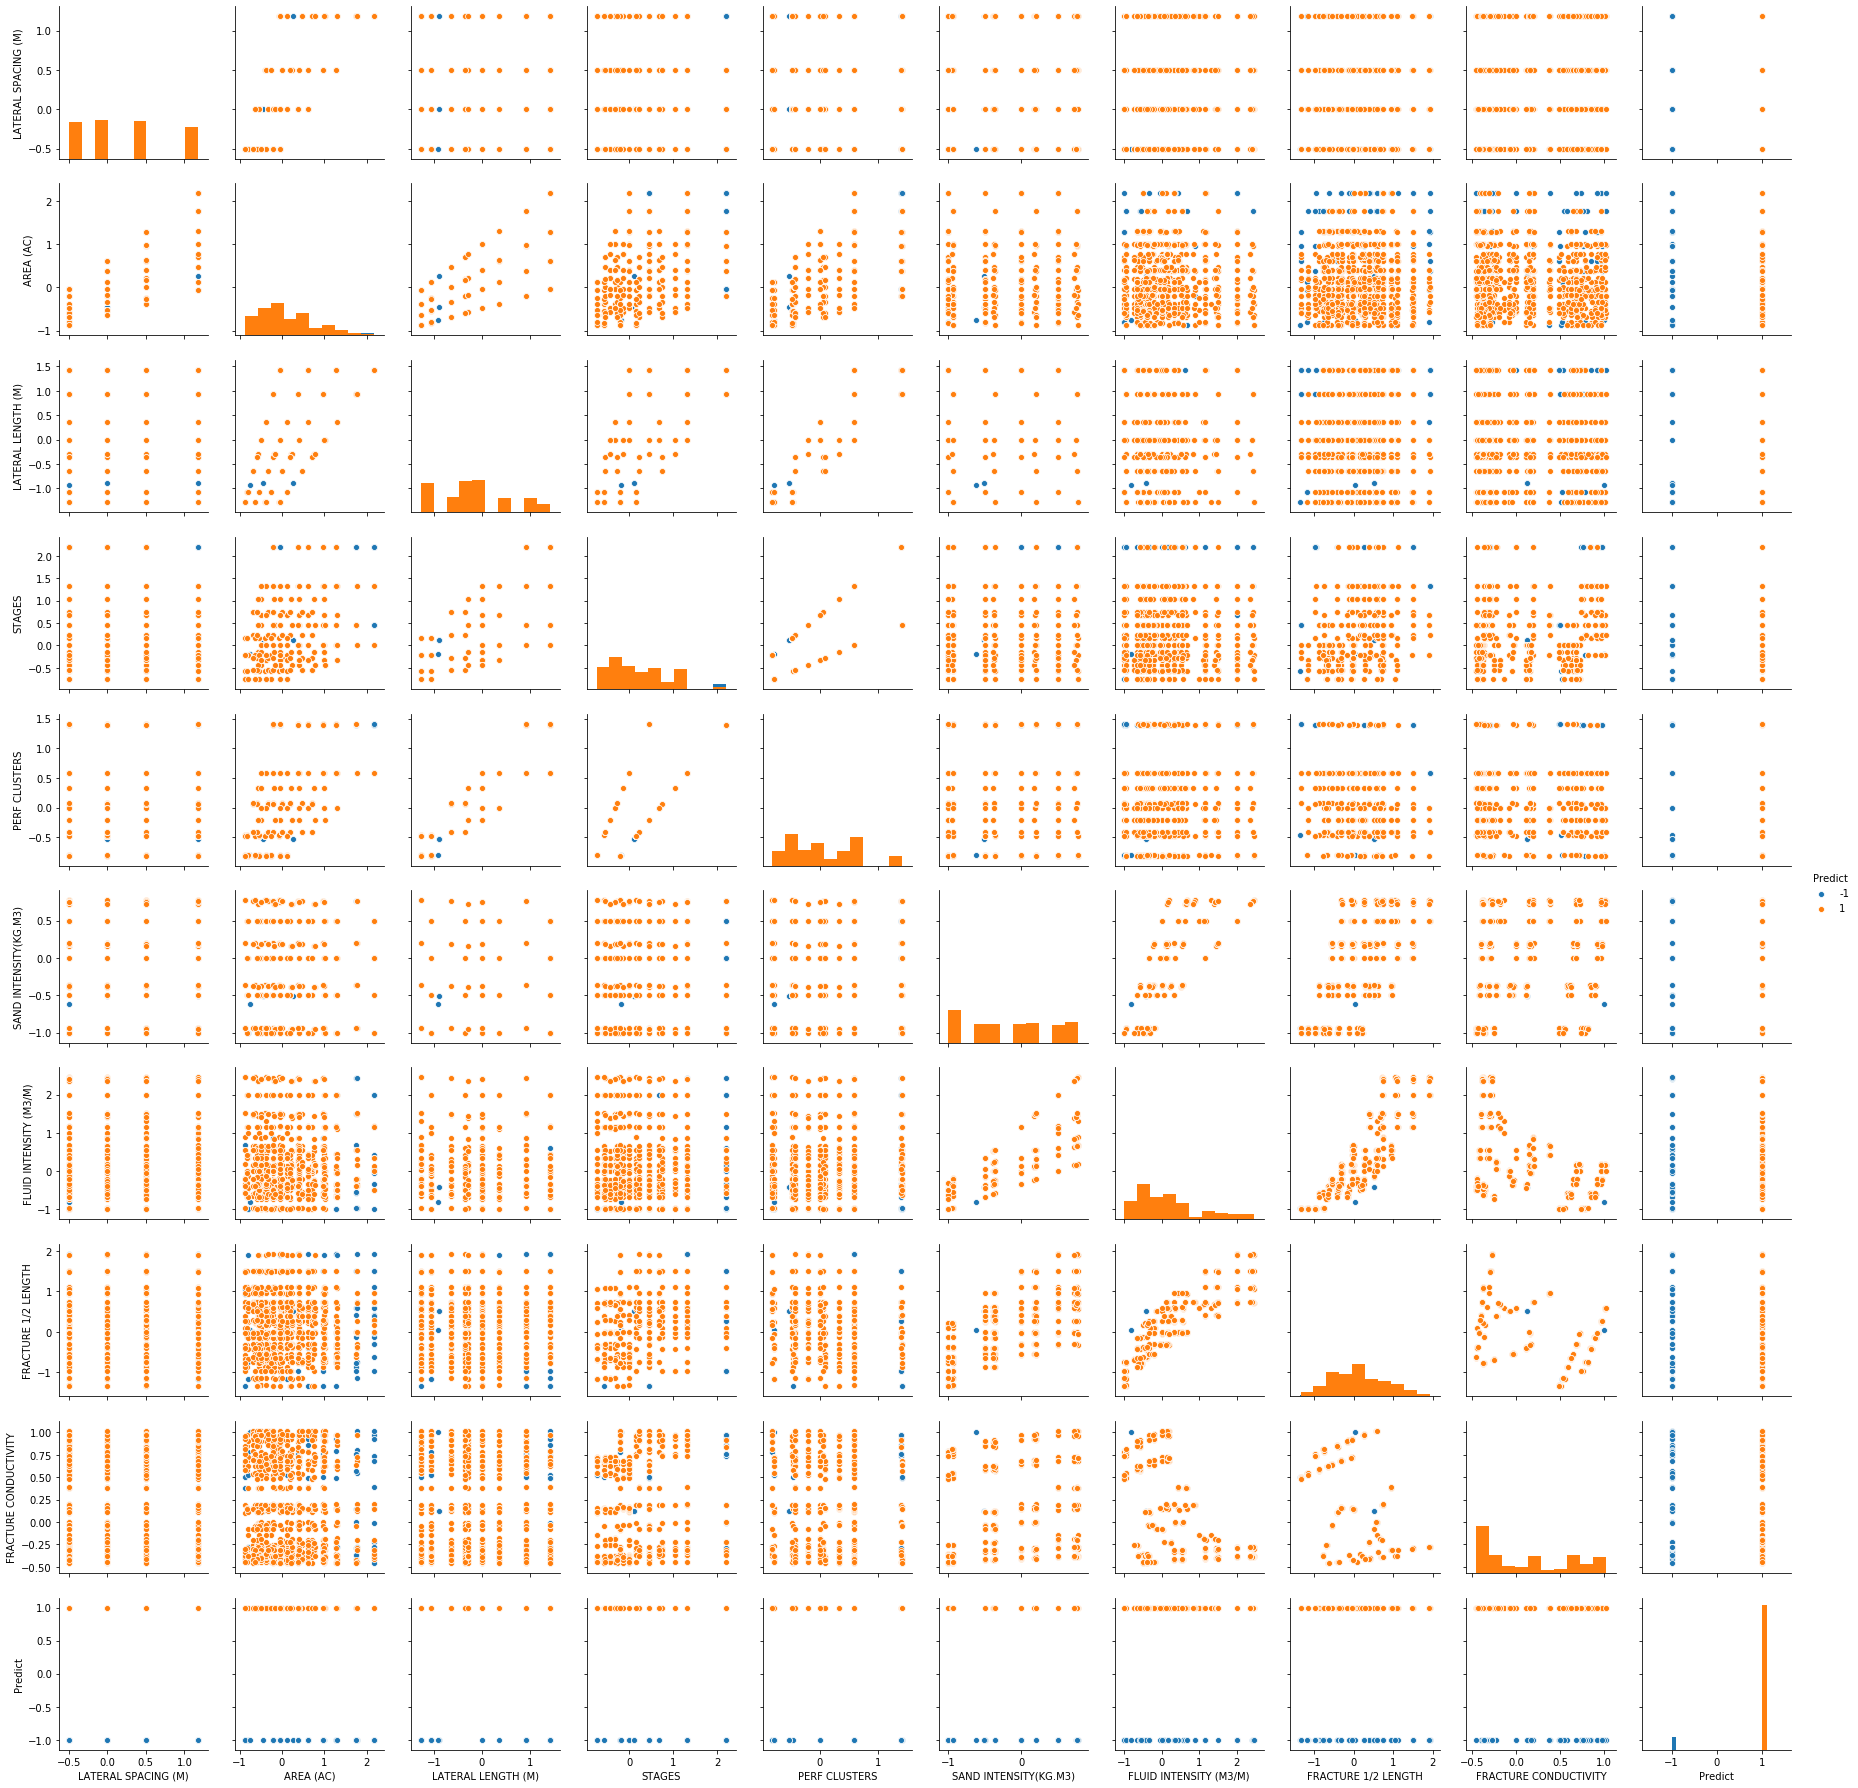

In [33]:
#Visualization
sns.pairplot(X_train.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'], axis = 1),hue='Predict',diag_kind='hist')
plt.show()

In [34]:
#Removing Outliers
#X_train['y_train']=y_train
#X_train = X_train[X_train['Predict'] == 1]

#y_train=X_train['y_train']
#X_train = X_train.drop(['Predict','y_train'], axis = 1)

- Outlier Detection was not perform since it doesn't display outliers

In [35]:
print(len(X_train))
print(len(y_train))

963
963


In [36]:
X_train = X_train.drop(['Predict'], axis = 1)

In [37]:
X_train.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY  
689              0.262798               0.967360  
1740            -0.117428              -0.367979  
945              0.736783               0.187212  
1576            -1.149778               0.541919  
131              0.705289              -0.394607

### 3.4. Dimensionality Reduction

#### ANOVA F-value and Mutual Information Value (X/Y): Correlation between X (features) and Y (target)

In [38]:
X_train_corr =X_train.drop(['TVD(M)','INJ. RATE','PERM'], axis = 1)

In [39]:
#f_test: Linear correlation between X and Y
f_test, _ = f_regression(X_train_corr, y_train) 
f_test /= np.max(f_test) # normalize f value

#mi: Nonlinear correlation between X and Y
mi = mutual_info_regression(X_train_corr, y_train) 
mi /= np.max(mi) # normalize mi value

In [40]:
print(f_test)
print(mi)

[2.69644247e-04 1.28183848e-03 3.35974001e-05 5.56432961e-02
 3.90736614e-01 1.08743712e-01 1.00000000e+00 3.26378024e-03
 4.38062397e-03 8.57048661e-04 1.83698841e-03 1.61334638e-03]
[0.00366777 0.13516015 0.         0.35389612 0.36450687 0.73919572
 0.71009484 0.23905098 0.36414604 0.00306591 1.         0.78203179]


Text(0.5, 1.0, 'f_test value')

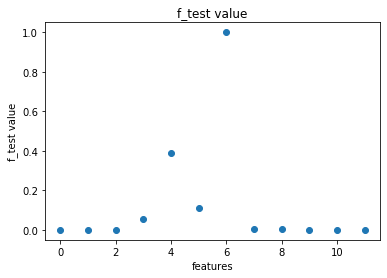

In [41]:
#Plot f_test
plt.figure()
plt.plot(f_test, 'o')
plt.ylabel('f_test value')
plt.xlabel('features')
plt.title('f_test value')

Text(0.5, 1.0, 'mi value')

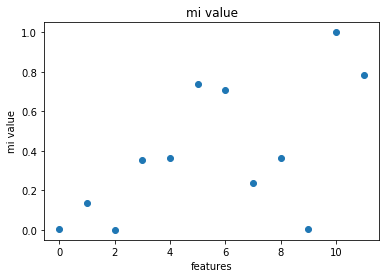

In [42]:
#Plot mi value
plt.figure()
plt.plot(mi, 'o')
plt.ylabel('mi value')
plt.xlabel('features')
plt.title('mi value')

- Large value of f_test indicates the feature is significant (linear correlation XY)
- Large value of mi indicates the feature is significant (nonlinear correlation XY)

#### Variance inflation factor (VIF): Multicollinarity analysis

In [43]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [44]:
calc_vif(X_train)

variables        VIF
0                 LL MULTI   2.115143
1          SAND CONC MODEL   2.130444
2      LATERAL SPACING (M)  15.350539
3                AREA (AC)  21.973528
4                   TVD(M)        NaN
5       LATERAL LENGTH (M)  14.655486
6                   STAGES   8.890235
7            PERF CLUSTERS  14.682333
8    SAND INTENSITY(KG.M3)   6.030387
9   FLUID INTENSITY (M3/M)  12.941499
10               INJ. RATE        NaN
11                    PERM        NaN
12           PAY THICKNESS   1.099520
13     FRACTURE 1/2 LENGTH  18.340667
14   FRACTURE CONDUCTIVITY   5.936741

- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [45]:
X_train_red =X_train.drop(['LATERAL SPACING (M)'], axis = 1)
X_test_red =X_test.drop(['LATERAL SPACING (M)'], axis = 1)

In [46]:
calc_vif(X_train_red)

variables        VIF
0                 LL MULTI   2.102972
1          SAND CONC MODEL   2.123012
2                AREA (AC)   1.694172
3                   TVD(M)        NaN
4       LATERAL LENGTH (M)   5.748697
5                   STAGES   8.847334
6            PERF CLUSTERS  14.518395
7    SAND INTENSITY(KG.M3)   5.939238
8   FLUID INTENSITY (M3/M)  12.935845
9                INJ. RATE        NaN
10                    PERM        NaN
11           PAY THICKNESS   1.098188
12     FRACTURE 1/2 LENGTH  18.267302
13   FRACTURE CONDUCTIVITY   5.847498

In [47]:
X_train=X_train_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
X_test=X_test_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (963, 8)
Dimensions of X_test: (322, 8)


## 4. Models

In [48]:
#Cross validation on training data (5-Fold)
cv = KFold(n_splits=5, shuffle = True, random_state=125) # instance

### 4.1. ElasticNet

In [49]:
# Train the ElasticNet model using alpha = 1, l1_ratio = 0.5, and default values for all other hyper-parameters. 
en = ElasticNet(alpha=1,l1_ratio=0.5)
en.fit(X_train, y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [50]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, en.predict(X_test)))
print('MSE', mean_squared_error(y_test, en.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, en.predict(X_test)))**0.5)

MAE 711.0274265185994
MSE 689862.2454974916
RMSE 830.579463686342


In [51]:
# Hyperparameter optimization (GridSearchCV) for ELasticNet Model

param_grid = {'alpha': [0.01, 0.05, 0.1, 0.15], 'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]} 

en_mod = GridSearchCV(en, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  

en_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.15],
                         'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [52]:
# Best/optimal values of hyperparameters
print(en_mod.best_params_) 

{'alpha': 0.15, 'l1_ratio': 1}


In [53]:
# Performance of the optimal model
print('Scoring: ', en_mod.best_score_) 

Scoring:  -274805.6423695365


In [54]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, en_mod.predict(X_test)))
print('MSE', mean_squared_error(y_test, en_mod.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, en_mod.predict(X_test)))**0.5)

MAE 439.1729080937764
MSE 295116.6939637671
RMSE 543.246439439567


In [55]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, en_mod.predict(X_test)))**0.5)

R2 0.9625648179475412


#### Plotting

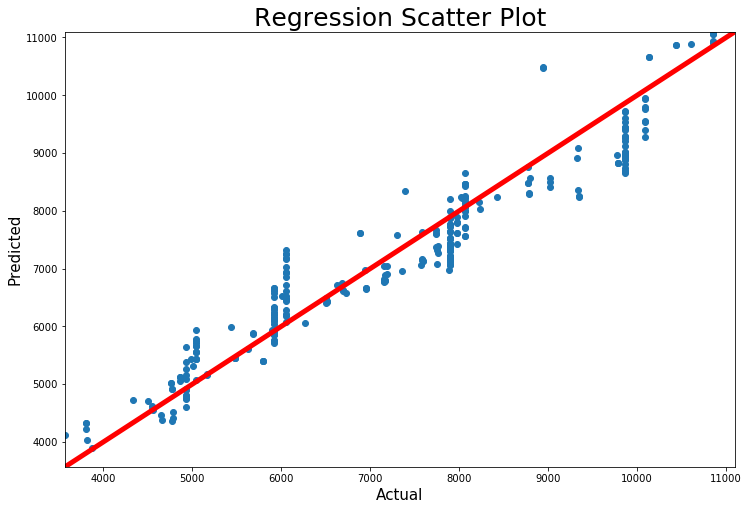

In [56]:
scatter_plot(y_test, en_mod.predict(X_test))

### 4.2. Support Vector Regressor

In [57]:
# Train SVR model using kernel='poly', degree=2, C=1000, and default values for all other hyper-parameters. 
sr =  SVR(kernel='poly',degree=2, C=1000)
sr.fit(X_train, y_train)

SVR(C=1000, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [58]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, sr.predict(X_test)))
print('MSE', mean_squared_error(y_test, sr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, sr.predict(X_test)))**0.5)

MAE 731.7214525185501
MSE 897710.5532073086
RMSE 947.4758852906541


In [59]:
# Hyperparameter optimization (GridSearchCV) for SVR
param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'],'C': [1, 10, 100, 1000],'degree': [2,3,4]}]
  
svr_mod = GridSearchCV(sr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

svr_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1000, cache_size=200, coef0=0.0, degree=2,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [60]:
# Best/optimal values of hyperparameters
print(svr_mod.best_params_)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [61]:
# Performance of the optimal model
print('Scoring: ', svr_mod.best_score_) 

Scoring:  -142436.72593350653


In [62]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, svr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 257.6108829387588
Generalization performance (MSE) 134216.0960621384
Generalization performance (RMSE) 366.355150178264


In [63]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, svr_mod.predict(X_test)))**0.5)

R2 0.983151591991451


#### Plotting

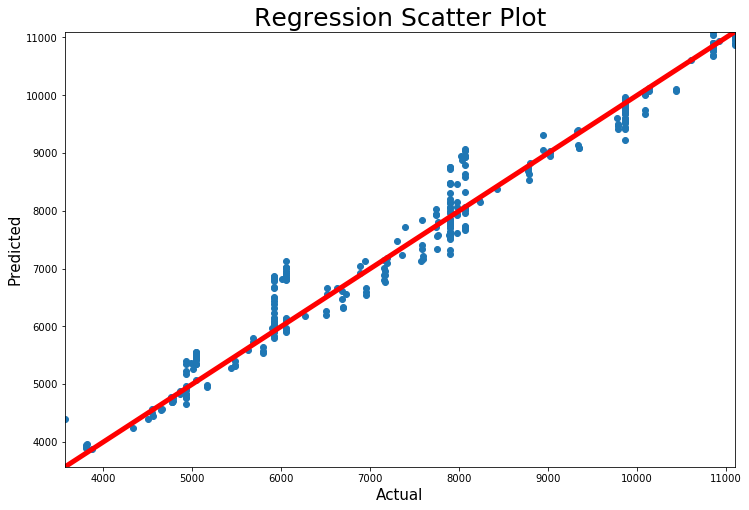

In [64]:
scatter_plot(y_test, svr_mod.predict(X_test))

### 4.3. Random Forest Regressor

In [65]:
# Train the Random Forest Regressor model using 200 estimators and default values for all other hyper-parameters.
rfr =  RandomForestRegressor(n_estimators=200,min_samples_leaf=5)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, rfr.predict(X_test)))
print('MSE', mean_squared_error(y_test, rfr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, rfr.predict(X_test)))**0.5)

MAE 43.71293951880744
MSE 12104.422387916467
RMSE 110.02009992686094


In [67]:
# Hyperparameter optimization (GridSearchCV) for Random Forest 
param_grid = {'n_estimators':[50, 100, 200, 300],'min_samples_leaf': [1, 3, 5, 10], 'max_depth':[3,4,5], 'max_features':[2,3,4]} 

rf_mod = GridSearchCV(rfr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

rf_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

In [68]:
# Best/optimal values of hyperparameters
print(rf_mod.best_params_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 300}


In [69]:
# Performance of the optimal model
print('Scoring: ', rf_mod.best_score_) 

Scoring:  -27405.786101182668


In [70]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, rf_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 116.60648731357287
Generalization performance (MSE) 27893.723001804225
Generalization performance (RMSE) 167.01414012533257


In [71]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, rf_mod.predict(X_test)))**0.5)

R2 0.9965218958067865


#### Plotting

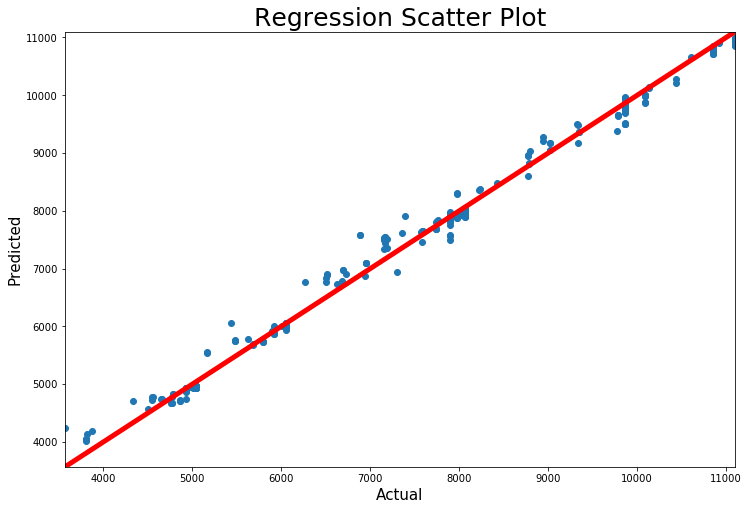

In [72]:
scatter_plot(y_test, rf_mod.predict(X_test))

### 4.4. Gradient Boosting Regressor

In [73]:
# Train the Gradient Boosting Regressor model using n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3
grb = GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3, random_state=0)
grb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [74]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, grb.predict(X_test)))
print('MSE', mean_squared_error(y_test, grb.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, grb.predict(X_test)))**0.5)

MAE 20.47608373205223
MSE 3065.118306727173
RMSE 55.36351060696181


In [75]:
# Hyperparameter optimization (GridSearchCV) for GBR
param_grid = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]}
  
grb_mod = GridSearchCV(grb, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

grb_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='huber', max_depth=4,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=3,
                                                 min_samples_split=2,
                                                 min_w...
                                                 presort='deprecated',
                                          

In [76]:
# Best/optimal values of hyperparameters
print(grb_mod.best_params_) 

{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.5}


In [77]:
# Performance of the optimal model
print('Scoring: ', grb_mod.best_score_) 

Scoring:  -3896.052866103789


In [78]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, grb_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 13.151729277288052
Generalization performance (MSE) 1579.8487544626498
Generalization performance (RMSE) 39.747311285955554


In [79]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, grb_mod.predict(X_test)))**0.5)

R2 0.9998033298692438


#### Ploting

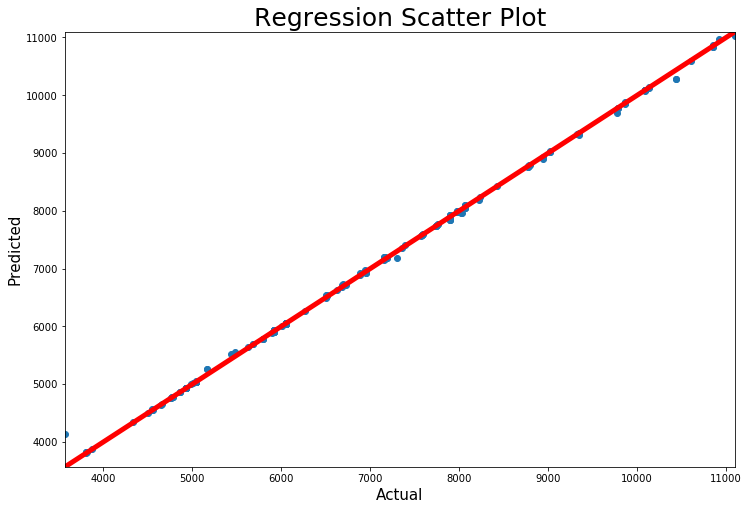

In [80]:
scatter_plot(y_test, grb_mod.predict(X_test))

### 4.5. Neural Network Regressor

In [81]:
# Train the Neural Network Regressor
nnr = MLPRegressor(hidden_layer_sizes=(4,4),activation='relu',alpha=0.001,early_stopping=False,tol=0.001,batch_size=200,max_iter=3000)
nnr.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(4, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=3000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [82]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, nnr.predict(X_test)))
print('MSE', mean_squared_error(y_test, nnr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, nnr.predict(X_test)))**0.5)

MAE 719.8670006307378
MSE 800866.4994837309
RMSE 894.9114478448306


In [83]:
# Hyperparameter optimization (GridSearchCV) for NNR
param_grid = {'solver': ['adam'],
              'activation': ['relu'],
              'hidden_layer_sizes': [(10,5),(7,7),(8,4),(10,10),(10),(100),(20,20),(20,20,20)],
              'batch_size': [100,200,300],
              'learning_rate_init': [0.001, 0.01, 0.05]}
    
nnr_mod = GridSearchCV(nnr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

nnr_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.001,
                                    batch_size=200, beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(4, 4),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=3000, momentum=0.9,
                                    n_iter_no_change=10,
                                    nestero...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'batch_size': [100, 200, 300],
                         'hidden_layer_sizes': [(10, 5), (

In [84]:
# Best/optimal values of hyperparameters
print(nnr_mod.best_params_) 

{'activation': 'relu', 'batch_size': 300, 'hidden_layer_sizes': (20, 20, 20), 'learning_rate_init': 0.001, 'solver': 'adam'}


In [85]:
# Performance of the optimal model
print('Scoring: ', nnr_mod.best_score_) 

Scoring:  -207993.46881603805


In [86]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, nnr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 434.69402211620593
Generalization performance (MSE) 287150.1996735581
Generalization performance (RMSE) 535.8639749727146


In [87]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, nnr_mod.predict(X_test)))**0.5)

R2 0.963594457540899


#### Plotting

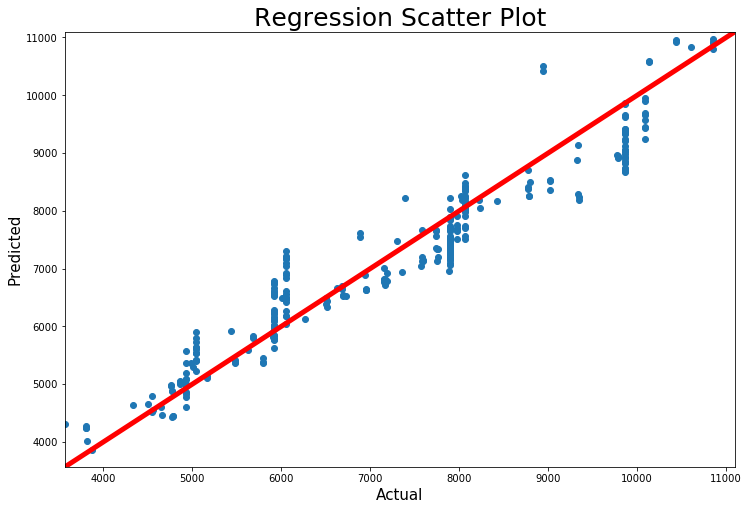

In [88]:
scatter_plot(y_test, nnr_mod.predict(X_test))

### 4.6. Saving Models

#### ElasticNet

In [89]:
import pickle 
filename = 'EN_IP90.sav'
pickle.dump(en_mod, open(filename, 'wb'))

#### Support Vector Regressor

In [90]:
filename = 'svr_IP90.sav'
pickle.dump(svr_mod, open(filename, 'wb'))

#### Random Forest Regressor

In [91]:
filename = 'rf_IP90.sav'
pickle.dump(rf_mod, open(filename, 'wb'))

#### Gradient Boosting Regressor

In [92]:
filename = 'grb_IP90.sav'
pickle.dump(grb_mod, open(filename, 'wb'))

#### Neural Network Regressor

In [93]:
filename = 'nnr_IP90.sav'
pickle.dump(nnr_mod, open(filename, 'wb'))

# 5. Conclusion

### The key features that affect my target (IP90) are:

Using dimensionality reduction:

- L MULTI
- SAND CONC MODEL 
- TVD(M)
- INJ. RATE
- PERM
- PAY THICKNESS

Using Variance inflation factor (multicollinarity):

- LATERAL SPACING (M) (High correlation with the Area)

According to Bowie (2018), the identification of key factors affecting my target can help the "process optimization by maximizing factors positively affecting well performance, in addition to cost savings if other predictor variables have little to no effect".  

### Using seaborn Pearson correlation matrix, the most important features for my target are (top 5): 

1) Perf Clusters: 0.94

2) Lateral Length: 0.86

3) Stages: 0.68

4) Area: 0.54

5) Fluid Intensity: 0.17

# Model for Target: GAS (EUR)

#### Target

In [95]:
#EUR_G
EUR_G=train_target['GAS (EUR)']
EUR_G.head()

653     5.661301
1591    6.712743
1307    5.392724
539     4.067688
682     5.131829
Name: GAS (EUR), dtype: float64

In [96]:
#EUR_G
feat_EUR_G=pd.concat([EUR_G, train_feat], axis=1)

### 1.2. Visualization

#### Features and Target (EUR Gas)

In [97]:
feat_target=pd.concat([train_feat, train_target], axis=1)
feat_target.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)       TVD(M)  \
653      1.000                3                  400      349.7  2956.900756   
1591     0.889                2                  200      263.6  2956.900756   
1307     0.889                4                  200      199.4  2956.900756   
539      0.889                4                  200      155.5  2956.900756   
682      1.000                4                  300      263.3  2956.900756   

      LATERAL LENGTH (M)  STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
653                 3500      46             92                 2000.0   
1591                5300      78            156                 1132.1   
1307                4000     116            116                 4500.0   
539                 3100      34             68                 4516.1   
682                 3500      34             68                 3000.0   

      FLUID INTENSITY (M3/M)  ...  EFFECTIVE IRR       PV(10)       PV(15)  \
653                     20.0  ...       0.853884  6930.382442  5358.070652   
1591                     9.5  ...       1.087076  9552.278968  7588.689882   
1307                    18.0  ...       0.728381  7666.190920  6020.435025   
539                     18.1  ...       0.409468  4064.735533  2771.923567   
682                     12.0  ...       0.468071  5073.862174  3468.582212   

       Royalty    PAYOUT       LIFE    NETBACK       F&D  RECYCLE RATIO  \
653   0.082517  1.333333  40.000000  14.327106  5.133588       2.790856   
1591  0.090752  1.166667  40.000000  14.497720  5.089388       2.848618   
1307  0.050019  1.416667  34.166667  15.766205  7.385450       2.134766   
539   0.048097  2.083333  36.583333  14.814777  7.277691       2.035642   
682   0.065236  2.000000  40.000000  14.407753  5.391182       2.672466   

       PV15 PI  
653   1.664542  
1591  1.796763  
1307  1.536067  
539   1.336641  
682   1.455917  

[5 rows x 37 columns]

In [98]:
feat_target.columns

Index(['LL MULTI', 'SAND CONC MODEL', 'LATERAL SPACING (M)', 'AREA (AC)',
       'TVD(M)', 'LATERAL LENGTH (M)', 'STAGES', 'PERF CLUSTERS',
       'SAND INTENSITY(KG.M3)', 'FLUID INTENSITY (M3/M)', 'INJ. RATE', 'PERM',
       'PAY THICKNESS', 'FRACTURE 1/2 LENGTH', 'FRACTURE CONDUCTIVITY',
       'REC. EFFICIENCY (GAS)', 'REC. EFFICIENCY (OIL)', ' DRILLING COST',
       'COMPLETION COST', 'EQUIPMENT COST', 'TOTAL WELL COST', 'IP90 GAS',
       'IP90 OIL', 'IP90 COND', 'GAS (EUR)', 'OIL (EUR)', 'COND (EUR)',
       'EFFECTIVE IRR', 'PV(10)', 'PV(15)', 'Royalty', 'PAYOUT', 'LIFE',
       'NETBACK', 'F&D', 'RECYCLE RATIO', 'PV15 PI'],
      dtype='object')

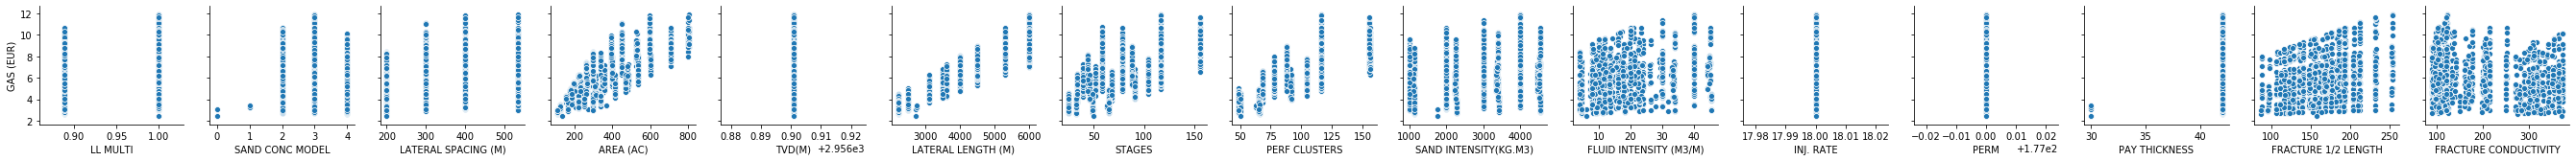

In [99]:
#EUR_G
sns.pairplot(feat_target, y_vars="GAS (EUR)", x_vars=feat_target.iloc[:,:15].columns.values)
plt.show()

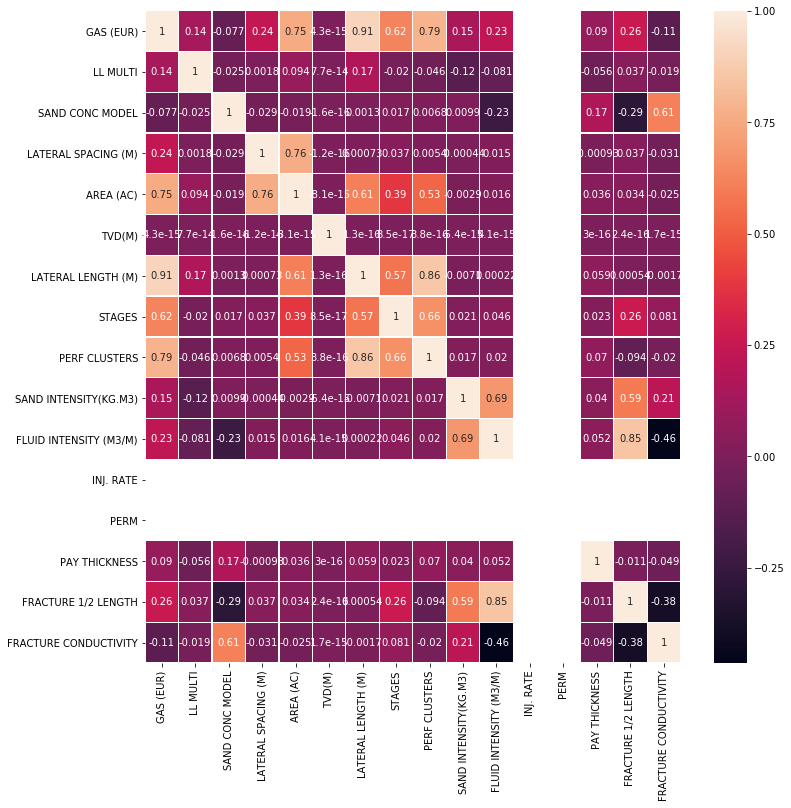

In [100]:
#Correlation matrix (Pearson)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = feat_EUR_G.corr()
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

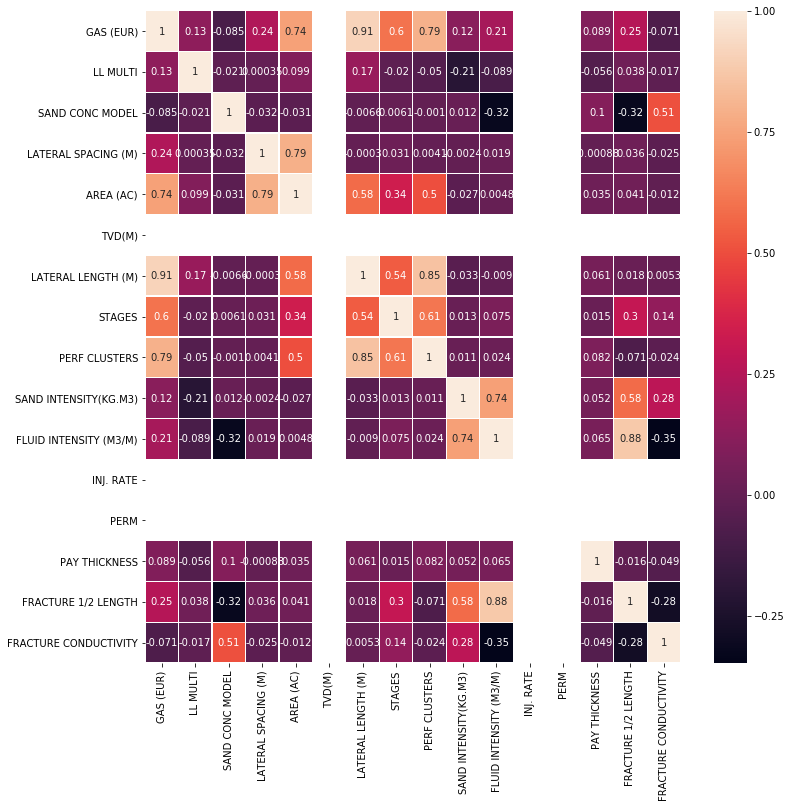

In [101]:
#Correlation matrix (spearman)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = feat_EUR_G.corr(method='spearman')
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

In [102]:
def scatter_plot(y_test,y_pred):

    plt.figure(figsize=(12,8))
    ulim = np.max(y_test)
    llim = np.min(y_test)
    plt.scatter(y_test,y_pred)
    plt.plot([llim,ulim],[llim,ulim],linewidth=5, c='red')
    plt.title('Regression Scatter Plot', fontsize=25)
    plt.xlim([llim,ulim])
    plt.ylim([llim,ulim])
    plt.ylabel('Predicted', fontsize=15)
    plt.xlabel('Actual', fontsize=15)
    
    plt.show()

## 2. Data Split (Test/Train): EUR Gas

In [103]:
X_train, X_test, y_train, y_test = train_test_split(train_feat, EUR_G, test_size=0.25, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)
print('Dimensions of y_train:',y_train.shape)
print('Dimensions of y_test:',y_test.shape)

Dimensions of X_train: (963, 15)
Dimensions of X_test: (322, 15)
Dimensions of y_train: (963,)
Dimensions of y_test: (322,)


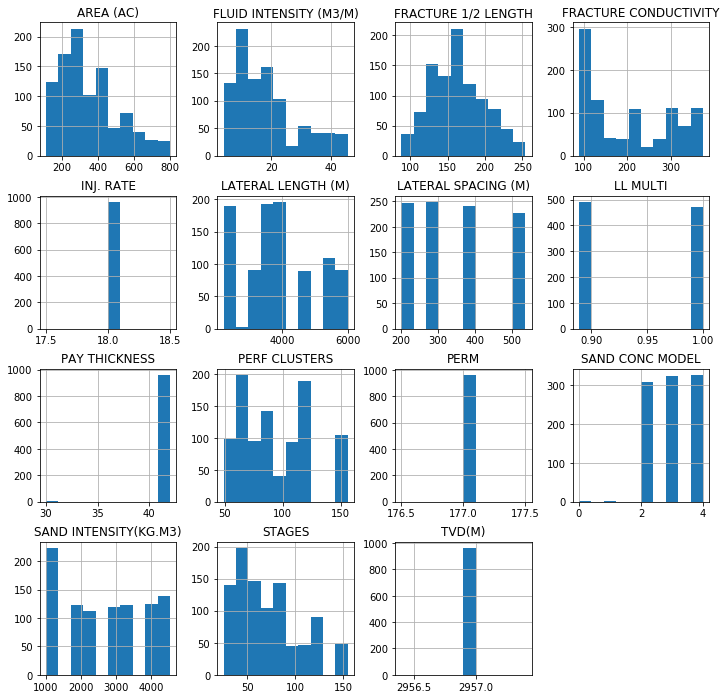

In [104]:
X_train.hist(figsize=(12,12))
plt.show()

In [105]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963 entries, 689 to 1554
Data columns (total 15 columns):
LL MULTI                  963 non-null float64
SAND CONC MODEL           963 non-null int64
LATERAL SPACING (M)       963 non-null int64
AREA (AC)                 963 non-null float64
TVD(M)                    963 non-null float64
LATERAL LENGTH (M)        963 non-null int64
STAGES                    963 non-null int64
PERF CLUSTERS             963 non-null int64
SAND INTENSITY(KG.M3)     963 non-null float64
FLUID INTENSITY (M3/M)    963 non-null float64
INJ. RATE                 963 non-null int64
PERM                      963 non-null int64
PAY THICKNESS             963 non-null int64
FRACTURE 1/2 LENGTH       963 non-null float64
FRACTURE CONDUCTIVITY     963 non-null float64
dtypes: float64(7), int64(8)
memory usage: 120.4 KB


## 3. Data Preprocessing

### 3.1. Feature Transform: MinMax Scaler

In [106]:
mscaler = MinMaxScaler(feature_range=(0, 1))

In [107]:
mscaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [108]:
X_train_scaled = mscaler.transform(X_train) # transform the train dataset to standardized data

# standardized training dataset
print("scaled minimum : %s " % np.min(X_train_scaled,axis=0))
print("scaled maximum : %s " % np.max(X_train_scaled,axis=0))

print("original minimum : %s " % mscaler.data_min_)
print("original maximum : %s " % mscaler.data_max_)

scaled minimum : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
scaled maximum : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 
original minimum : [8.89000000e-01 0.00000000e+00 2.00000000e+02 1.10400000e+02
 2.95690076e+03 2.20000000e+03 2.50000000e+01 4.90000000e+01
 1.00000000e+03 4.00000000e+00 1.80000000e+01 1.77000000e+02
 3.00000000e+01 8.76090940e+01 8.86309190e+01] 
original maximum : [1.00000000e+00 4.00000000e+00 5.36000000e+02 8.01600000e+02
 2.95690076e+03 6.00000000e+03 1.55000000e+02 1.56000000e+02
 4.54550000e+03 4.55000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 2.54072020e+02 3.75121530e+02] 


In [109]:
# scale the test data using the parameters learnt from the training dataset

X_test_scaled  = mscaler.transform(X_test)

print("minimum of scaled test data: %s" % np.min(X_test_scaled,axis=0))
print("maximum of scaled test data: %s " % np.max(X_test_scaled,axis=0))

## median of test data can be non-zero, and the IQR can be non-unitary
## just like the future data

minimum of scaled test data: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
maximum of scaled test data: [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 


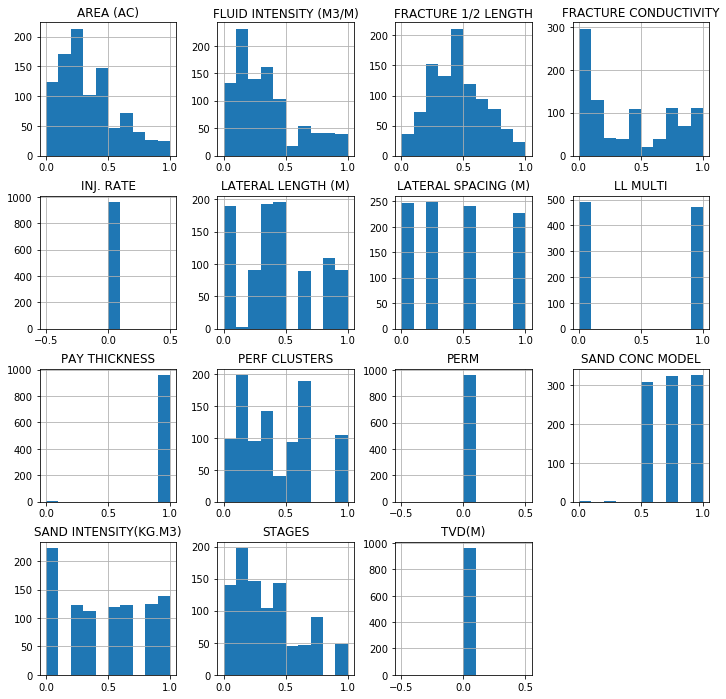

In [110]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

### 3.2. Feature Transform: Robust Scaler

In [111]:
# Robust Scaler
rscaler = RobustScaler() #instantiate
rscaler.fit(X_train) 

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [112]:
X_train_scaled = rscaler.transform(X_train) # transform the train dataset to standardized data

# Original training dataset
print("Original median : %s " % rscaler.center_)
print("Original IQR : %s " % rscaler.scale_)

#Scaled training dataset
print("Scaled median : %s " % np.median(X_train_scaled,axis=0))
print("Scaled IQR : %s " % (np.percentile(X_train_scaled, 75,axis=0)-np.percentile(X_train_scaled, 25,axis=0)))

Original median : [8.89000000e-01 3.00000000e+00 3.00000000e+02 3.09800000e+02
 2.95690076e+03 4.00000000e+03 5.80000000e+01 8.80000000e+01
 3.00000000e+03 1.60000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 1.56080510e+02 1.77499760e+02] 
Original IQR : [1.11000000e-01 2.00000000e+00 2.00000000e+02 2.25700000e+02
 1.00000000e+00 1.40000000e+03 4.40000000e+01 4.80000000e+01
 2.00000000e+03 1.20000000e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 5.08589900e+01 1.94208065e+02] 
Scaled median : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Scaled IQR : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.] 


In [113]:
#Scale the test data using the parameters learnt from the training dataset
X_test_scaled  = rscaler.transform(X_test)

print("Median of scaled test data: %s" % np.median(X_test_scaled,axis=0))
print("IQR of scaled test data: %s " % (np.percentile(X_test_scaled, 75,axis=0)-np.percentile(X_test_scaled, 25,axis=0)))

Median of scaled test data: [ 1.          0.          0.5         0.11785556  0.          0.
  0.15909091  0.0625      0.          0.          0.          0.
  0.          0.16016677 -0.04416022]
IQR of scaled test data: [1.         1.         1.18       0.96400089 0.         1.
 1.02272727 1.         0.9261375  0.95625    0.         0.
 0.         1.07477203 0.98993213] 


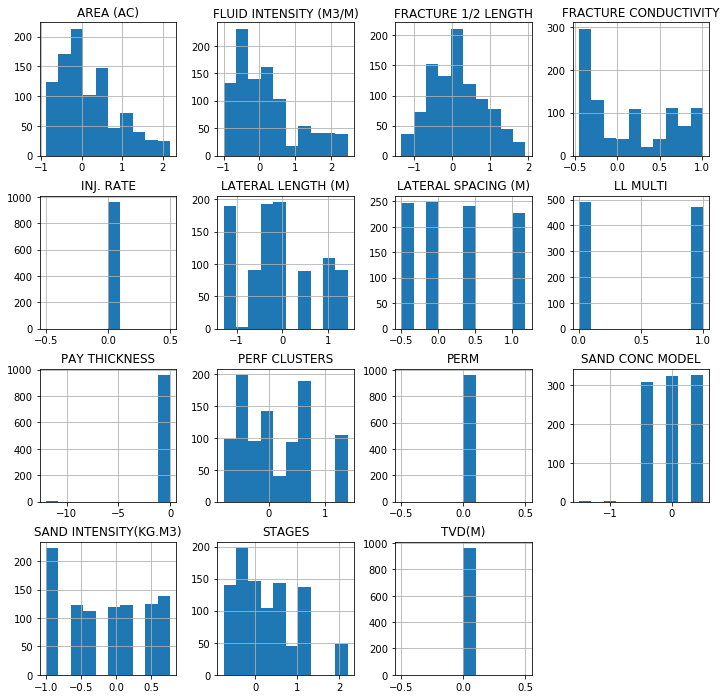

In [114]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

In [115]:
X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)

- Scaling is needed because the features have different ranges

### 3.3. Outlier Detection: Isolation Forest

In [116]:
# Isolation Forest
iforest = IsolationForest(n_estimators=200, contamination=0.08)
iforest = iforest.fit(X_train) #Training the model

In [117]:
#Predictions
X_train_predict = iforest.predict(X_train) 
X_train['Predict']=X_train_predict
X_train['Predict'] = X_train['Predict'].astype('category')
X_train

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   
...        ...              ...                  ...        ...     ...   
792        0.0             -0.5                 1.18   0.767390     0.0   
1617       0.0              0.0                 0.50   0.968542     0.0   
139        0.0              0.0                -0.50  -0.880815     0.0   
1803       1.0              0.0                -0.50  -0.047408     0.0   
1554       0.0              0.0                 0.00   0.383252     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   
...                  ...       ...            ...                    ...   
792            -0.285714  0.454545      -0.208333               -0.94445   
1617            0.928571  0.000000       0.583333               -0.36790   
139            -1.285714 -0.204545      -0.812500                0.20455   
1803            1.428571  1.318182       0.583333               -0.50000   
1554            0.928571  0.000000       0.583333               -0.93395   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   
...                      ...        ...   ...            ...   
792                -0.358333        0.0   0.0            0.0   
1617                0.550000        0.0   0.0            0.0   
139                 1.508333        0.0   0.0            0.0   
1803                0.333333        0.0   0.0            0.0   
1554               -0.391667        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY Predict  
689              0.262798               0.967360       1  
1740            -0.117428              -0.367979      -1  
945              0.736783               0.187212       1  
1576            -1.149778               0.541919      -1  
131              0.705289              -0.394607       1  
...                   ...                    ...     ...  
792              0.222537              -0.377114       1  
1617             0.288366              -0.410321       1  
139              1.487818              -0.295266       1  
1803             0.967157              -0.315834       1  
1554            -0.379853              -0.441523       1  

[963 rows x 16 columns]

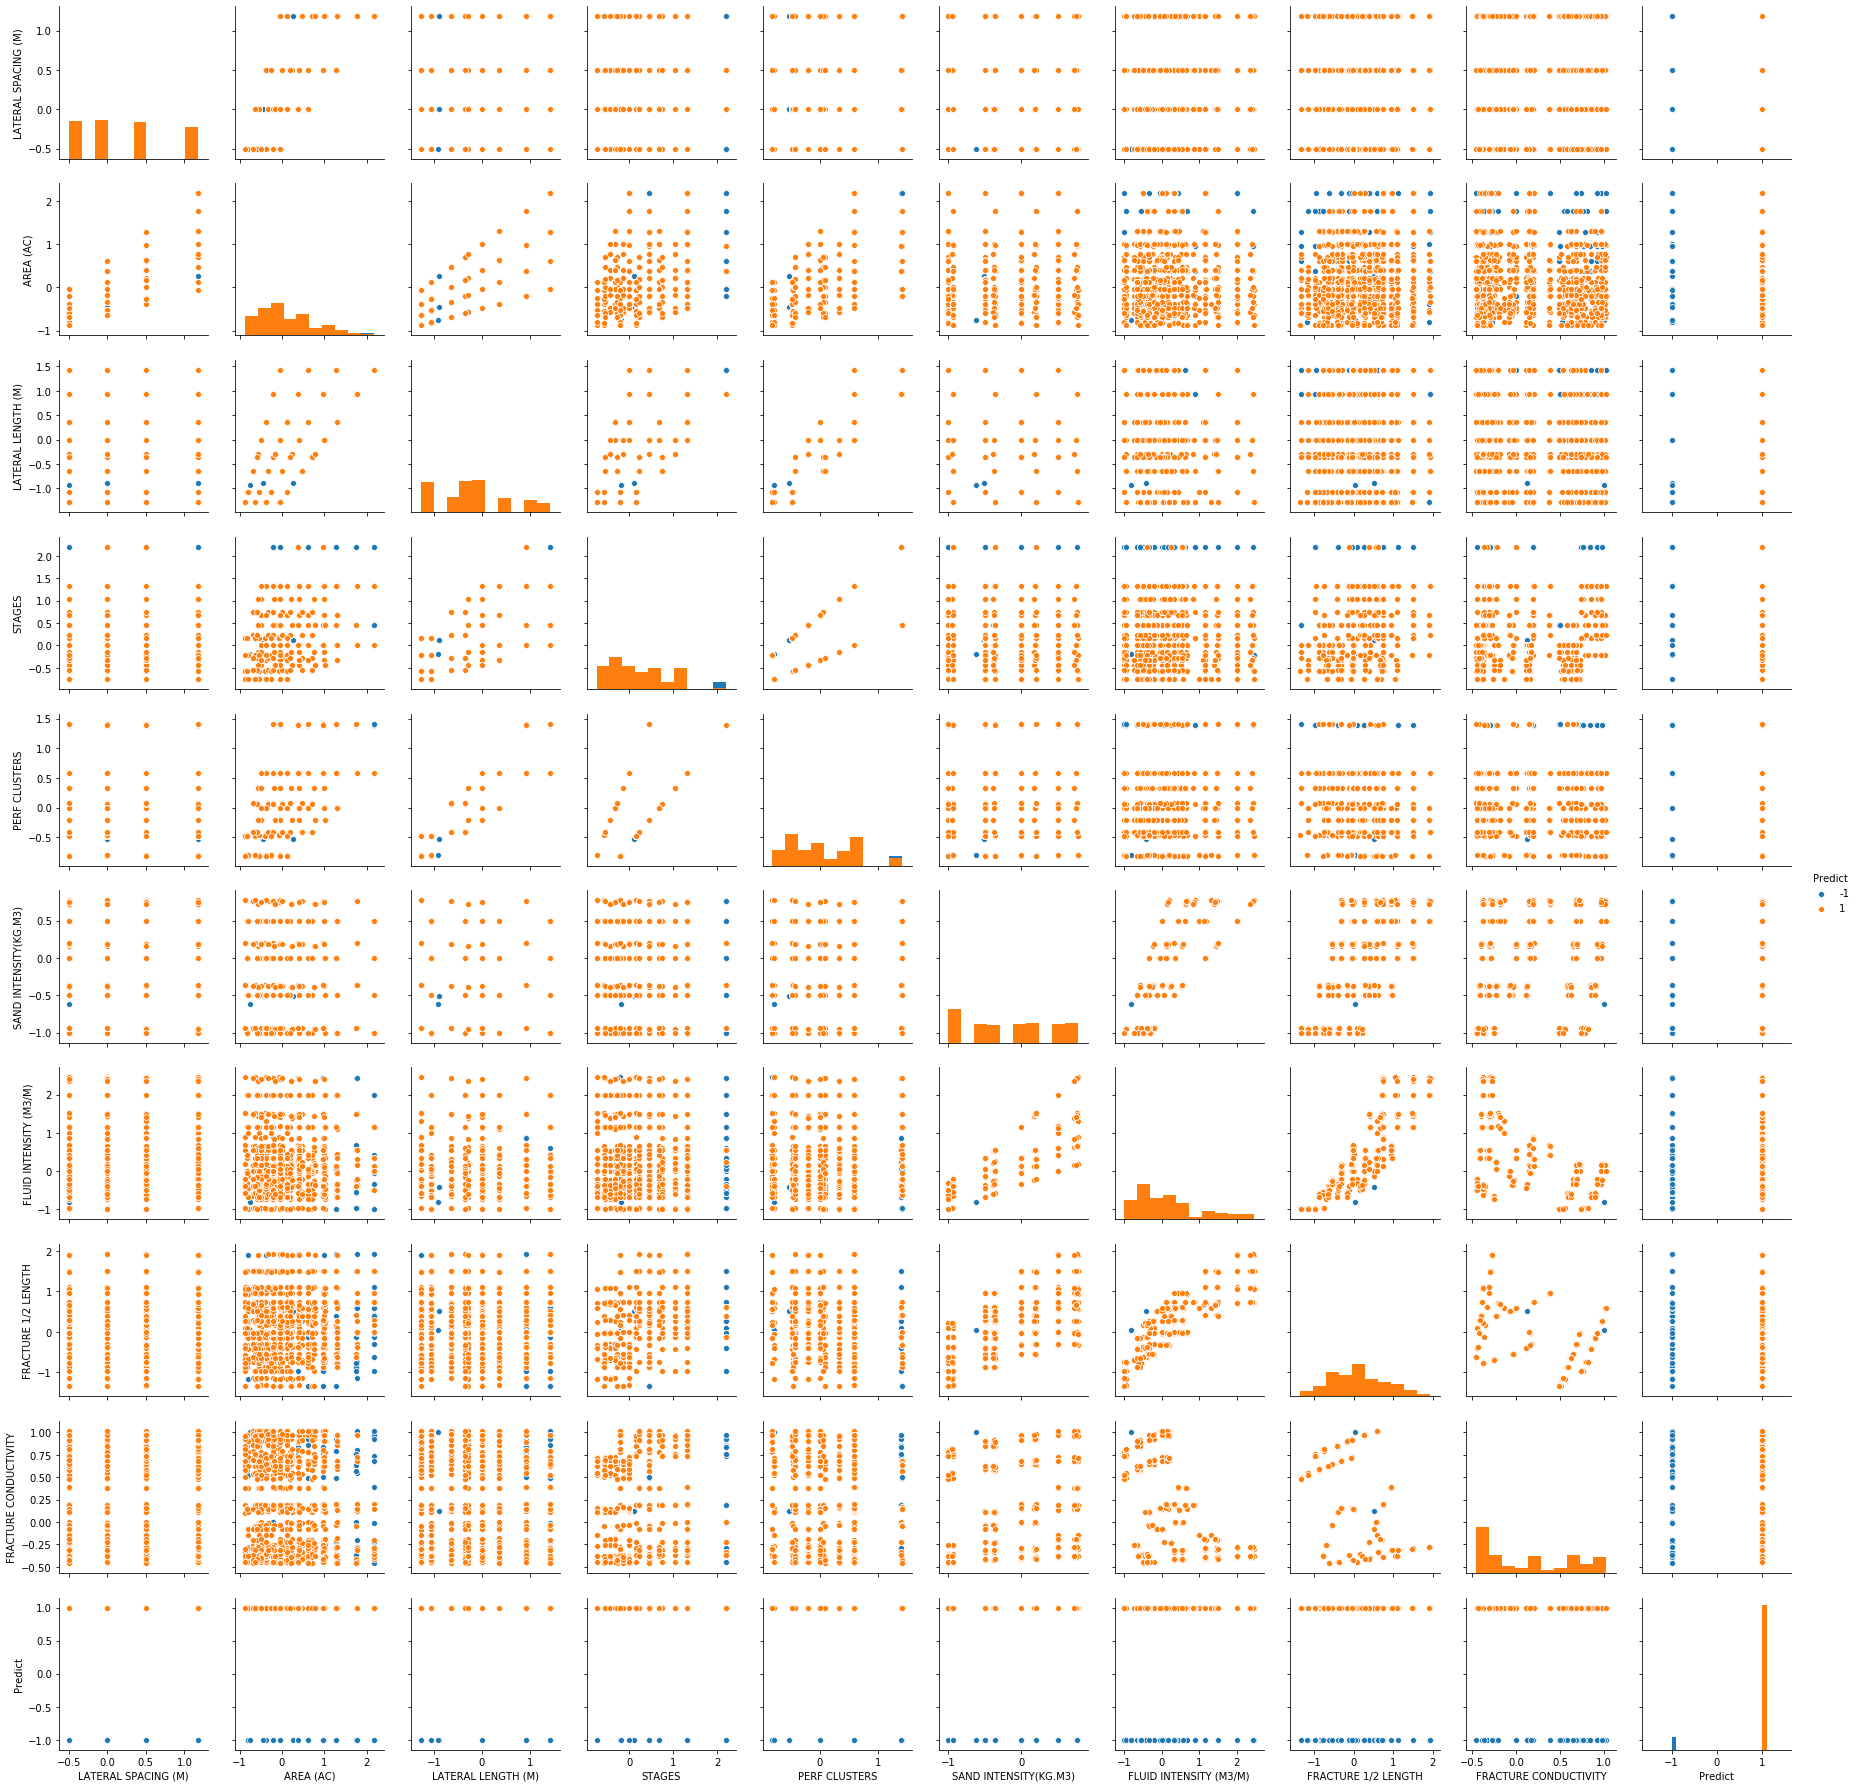

In [118]:
#Visualization
sns.pairplot(X_train.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'], axis = 1),hue='Predict',diag_kind='hist')
plt.show()

In [119]:
#Removing Outliers
#X_train['y_train']=y_train
#X_train = X_train[X_train['Predict'] == 1]

#y_train=X_train['y_train']
#X_train = X_train.drop(['Predict','y_train'], axis = 1)

- Outlier Detection was not perform since it doesn't display outliers

In [120]:
print(len(X_train))
print(len(y_train))

963
963


In [121]:
X_train = X_train.drop(['Predict'], axis = 1)

In [122]:
X_train.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY  
689              0.262798               0.967360  
1740            -0.117428              -0.367979  
945              0.736783               0.187212  
1576            -1.149778               0.541919  
131              0.705289              -0.394607

### 3.4. Dimensionality Reduction

#### ANOVA F-value and Mutual Information Value (X/Y): Correlation between X (features) and Y (target)

In [123]:
X_train_corr =X_train.drop(['TVD(M)','INJ. RATE','PERM'], axis = 1)

In [124]:
#f_test: Linear correlation between X and Y
f_test, _ = f_regression(X_train_corr, y_train) 
f_test /= np.max(f_test) # normalize f value

#mi: Nonlinear correlation between X and Y
mi = mutual_info_regression(X_train_corr, y_train) 
mi /= np.max(mi) # normalize mi value

In [125]:
print(f_test)
print(mi)

[0.00394705 0.00191731 0.0118308  0.26615655 1.         0.11613683
 0.32135375 0.00377577 0.01067533 0.00149196 0.01331389 0.00388648]
[0.01630976 0.00307132 0.1173755  1.         0.85429338 0.62962247
 0.65918026 0.12741566 0.24400035 0.00119353 0.22890358 0.14658721]


Text(0.5, 1.0, 'f_test value')

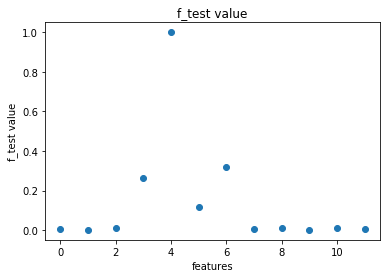

In [126]:
#Plot f_test
plt.figure()
plt.plot(f_test, 'o')
plt.ylabel('f_test value')
plt.xlabel('features')
plt.title('f_test value')

Text(0.5, 1.0, 'mi value')

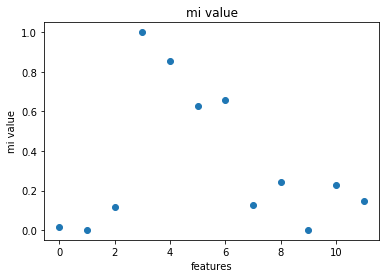

In [127]:
#Plot mi value
plt.figure()
plt.plot(mi, 'o')
plt.ylabel('mi value')
plt.xlabel('features')
plt.title('mi value')

- Large value of f_test indicates the feature is significant (linear correlation XY)
- Large value of mi indicates the feature is significant (nonlinear correlation XY)

#### Variance inflation factor (VIF): Multicollinarity analysis

In [128]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [129]:
calc_vif(X_train)

variables        VIF
0                 LL MULTI   2.115143
1          SAND CONC MODEL   2.130444
2      LATERAL SPACING (M)  15.350539
3                AREA (AC)  21.973528
4                   TVD(M)        NaN
5       LATERAL LENGTH (M)  14.655486
6                   STAGES   8.890235
7            PERF CLUSTERS  14.682333
8    SAND INTENSITY(KG.M3)   6.030387
9   FLUID INTENSITY (M3/M)  12.941499
10               INJ. RATE        NaN
11                    PERM        NaN
12           PAY THICKNESS   1.099520
13     FRACTURE 1/2 LENGTH  18.340667
14   FRACTURE CONDUCTIVITY   5.936741

- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [130]:
X_train_red =X_train.drop(['SAND INTENSITY(KG.M3)'], axis = 1)
X_test_red =X_test.drop(['SAND INTENSITY(KG.M3)'], axis = 1)

In [131]:
calc_vif(X_train_red)

variables        VIF
0                 LL MULTI   1.207998
1          SAND CONC MODEL   1.879004
2      LATERAL SPACING (M)  15.118515
3                AREA (AC)  21.810608
4                   TVD(M)        NaN
5       LATERAL LENGTH (M)  14.653236
6                   STAGES   6.733520
7            PERF CLUSTERS  13.922776
8   FLUID INTENSITY (M3/M)  11.982297
9                INJ. RATE        NaN
10                    PERM        NaN
11           PAY THICKNESS   1.074808
12     FRACTURE 1/2 LENGTH  15.750656
13   FRACTURE CONDUCTIVITY   2.108046

In [132]:
X_train=X_train_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
X_test=X_test_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (963, 8)
Dimensions of X_test: (322, 8)


## 4. Models

In [133]:
#Cross validation on training data (5-Fold)
cv = KFold(n_splits=5, shuffle = True, random_state=125) # instance

### 4.1. ElasticNet

In [134]:
# Train the ElasticNet model using alpha = 1, l1_ratio = 0.5, and default values for all other hyper-parameters. 
en = ElasticNet(alpha=1,l1_ratio=0.5)
en.fit(X_train, y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [135]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, en.predict(X_test)))
print('MSE', mean_squared_error(y_test, en.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, en.predict(X_test)))**0.5)

MAE 0.9242630729216694
MSE 1.376188404957652
RMSE 1.1731105680871057


In [136]:
# Hyperparameter optimization (GridSearchCV) for ELasticNet Model

param_grid = {'alpha': [0.01, 0.05, 0.1, 0.15], 'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]} 

en_mod = GridSearchCV(en, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  

en_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.15],
                         'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [137]:
# Best/optimal values of hyperparameters
print(en_mod.best_params_) 

{'alpha': 0.01, 'l1_ratio': 0.8}


In [138]:
# Performance of the optimal model
print('Scoring: ', en_mod.best_score_) 

Scoring:  -0.13682581669945457


In [139]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, en_mod.predict(X_test)))
print('MSE', mean_squared_error(y_test, en_mod.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, en_mod.predict(X_test)))**0.5)

MAE 0.29494611092381523
MSE 0.14002189701312834
RMSE 0.3741949986479354


In [140]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, en_mod.predict(X_test)))**0.5)

R2 0.9779137198922445


#### Plotting

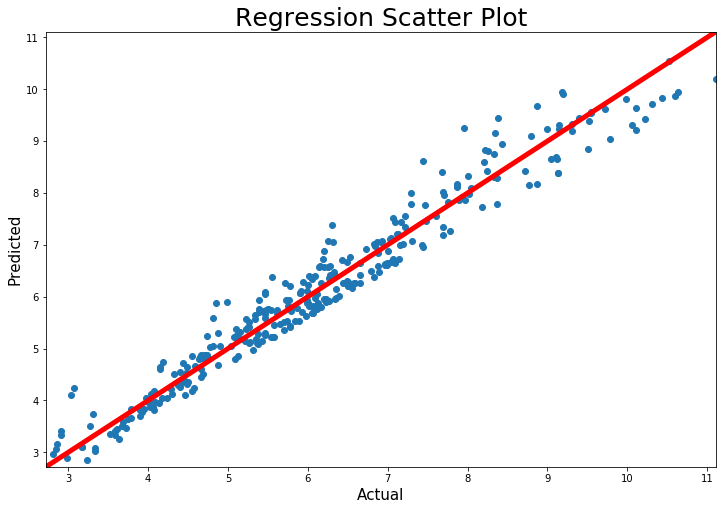

In [141]:
scatter_plot(y_test, en_mod.predict(X_test))

### 4.2. Support Vector Regressor

In [142]:
# Train SVR model using kernel='poly', degree=2, C=1000, and default values for all other hyper-parameters. 
sr =  SVR(kernel='poly',degree=2, C=1000)
sr.fit(X_train, y_train)

SVR(C=1000, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [143]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, sr.predict(X_test)))
print('MSE', mean_squared_error(y_test, sr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, sr.predict(X_test)))**0.5)

MAE 0.6992994615974945
MSE 1.1271316464949472
RMSE 1.0616645640196094


In [144]:
# Hyperparameter optimization (GridSearchCV) for SVR
param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'],'C': [1, 10, 100, 1000],'degree': [2,3,4]}]
  
svr_mod = GridSearchCV(sr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

svr_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1000, cache_size=200, coef0=0.0, degree=2,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [145]:
# Best/optimal values of hyperparameters
print(svr_mod.best_params_)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [146]:
# Performance of the optimal model
print('Scoring: ', svr_mod.best_score_) 

Scoring:  -0.006148303175204773


In [147]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, svr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 0.05673332105276665
Generalization performance (MSE) 0.004909734031209002
Generalization performance (RMSE) 0.07006949429822512


In [148]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, svr_mod.predict(X_test)))**0.5)

R2 0.9992338243649169


#### Plotting

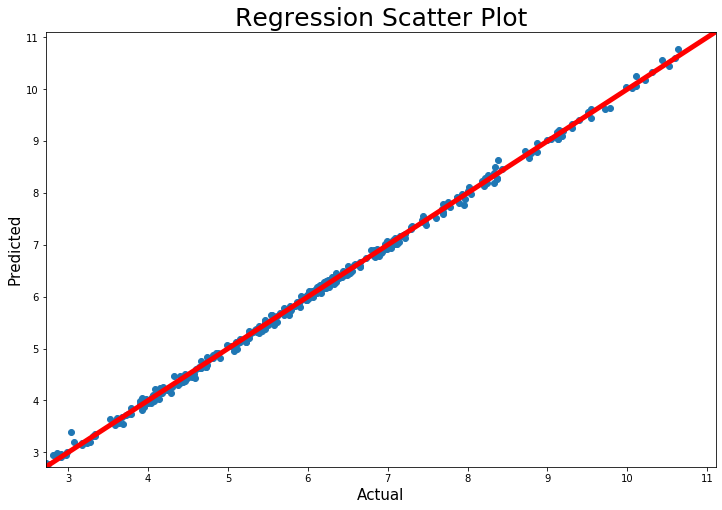

In [149]:
scatter_plot(y_test, svr_mod.predict(X_test))

### 4.3. Random Forest Regressor

In [150]:
# Train the Random Forest Regressor model using 200 estimators and default values for all other hyper-parameters.
rfr =  RandomForestRegressor(n_estimators=200,min_samples_leaf=5)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [151]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, rfr.predict(X_test)))
print('MSE', mean_squared_error(y_test, rfr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, rfr.predict(X_test)))**0.5)

MAE 0.10080939803508907
MSE 0.021017743240209094
RMSE 0.1449749745308103


In [152]:
# Hyperparameter optimization (GridSearchCV) for Random Forest 
param_grid = {'n_estimators':[50, 100, 200, 300],'min_samples_leaf': [1, 3, 5, 10], 'max_depth':[3,4,5], 'max_features':[2,3,4]} 

rf_mod = GridSearchCV(rfr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

rf_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

In [153]:
# Best/optimal values of hyperparameters
print(rf_mod.best_params_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 300}


In [154]:
# Performance of the optimal model
print('Scoring: ', rf_mod.best_score_) 

Scoring:  -0.07813920971799819


In [155]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, rf_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 0.18810024924939833
Generalization performance (MSE) 0.06659715548528974
Generalization performance (RMSE) 0.2580642468171245


In [156]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, rf_mod.predict(X_test)))**0.5)

R2 0.9895568071615323


#### Plotting

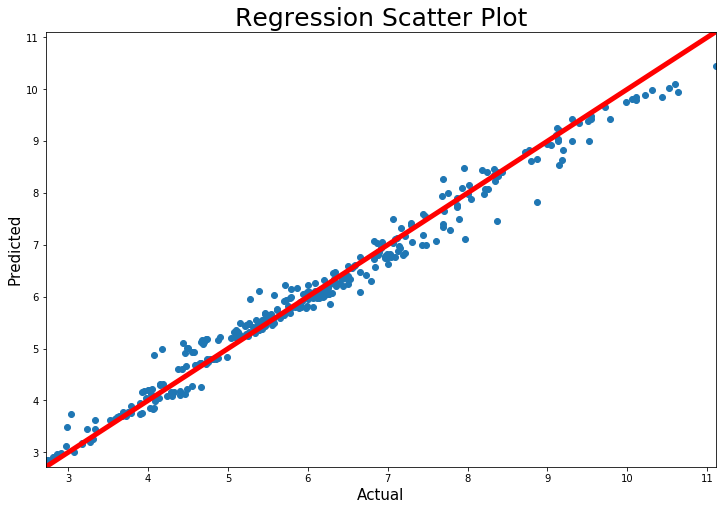

In [157]:
scatter_plot(y_test, rf_mod.predict(X_test))

### 4.4. Gradient Boosting Regressor

In [158]:
# Train the Gradient Boosting Regressor model using n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3
grb = GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3, random_state=0)
grb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [159]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, grb.predict(X_test)))
print('MSE', mean_squared_error(y_test, grb.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, grb.predict(X_test)))**0.5)

MAE 0.04627468419127283
MSE 0.003959600936828177
RMSE 0.06292536004528045


In [160]:
# Hyperparameter optimization (GridSearchCV) for GBR
param_grid = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]}
  
grb_mod = GridSearchCV(grb, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

grb_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='huber', max_depth=4,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=3,
                                                 min_samples_split=2,
                                                 min_w...
                                                 presort='deprecated',
                                          

In [161]:
# Best/optimal values of hyperparameters
print(grb_mod.best_params_) 

{'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.2}


In [162]:
# Performance of the optimal model
print('Scoring: ', grb_mod.best_score_) 

Scoring:  -0.004947866664622447


In [163]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, grb_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 0.03592442194559074
Generalization performance (MSE) 0.004113413316376561
Generalization performance (RMSE) 0.06413589725244795


In [164]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, grb_mod.predict(X_test)))**0.5)

R2 0.9993581320101432


#### Ploting

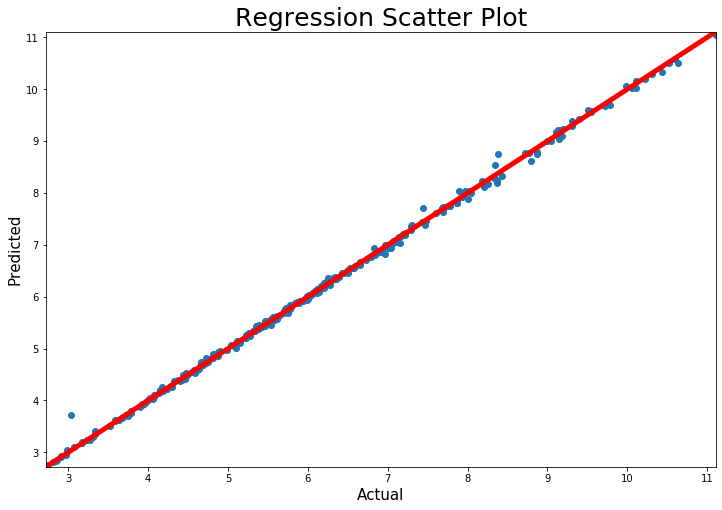

In [165]:
scatter_plot(y_test, grb_mod.predict(X_test))

### 4.5. Neural Network Regressor

In [166]:
# Train the Neural Network Regressor
nnr = MLPRegressor(hidden_layer_sizes=(4,4),activation='relu',alpha=0.001,early_stopping=False,tol=0.001,batch_size=200,max_iter=3000)
nnr.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(4, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=3000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [167]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, nnr.predict(X_test)))
print('MSE', mean_squared_error(y_test, nnr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, nnr.predict(X_test)))**0.5)

MAE 0.4126804699521321
MSE 0.2679822066376949
RMSE 0.5176699784975897


In [168]:
# Hyperparameter optimization (GridSearchCV) for NNR
param_grid = {'solver': ['adam'],
              'activation': ['relu'],
              'hidden_layer_sizes': [(10,5),(7,7),(8,4),(10,10),(10),(100),(20,20),(20,20,20)],
              'batch_size': [100,200,300],
              'learning_rate_init': [0.001, 0.01, 0.05]}
    
nnr_mod = GridSearchCV(nnr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

nnr_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.001,
                                    batch_size=200, beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(4, 4),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=3000, momentum=0.9,
                                    n_iter_no_change=10,
                                    nestero...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'batch_size': [100, 200, 300],
                         'hidden_layer_sizes': [(10, 5), (

In [169]:
# Best/optimal values of hyperparameters
print(nnr_mod.best_params_) 

{'activation': 'relu', 'batch_size': 100, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.05, 'solver': 'adam'}


In [170]:
# Performance of the optimal model
print('Scoring: ', nnr_mod.best_score_) 

Scoring:  -0.013083455094359228


In [171]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, nnr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 0.06399286107045066
Generalization performance (MSE) 0.012129951299986275
Generalization performance (RMSE) 0.11013605812805484


In [172]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, nnr_mod.predict(X_test)))**0.5)

R2 0.9981060239203134


#### Plotting

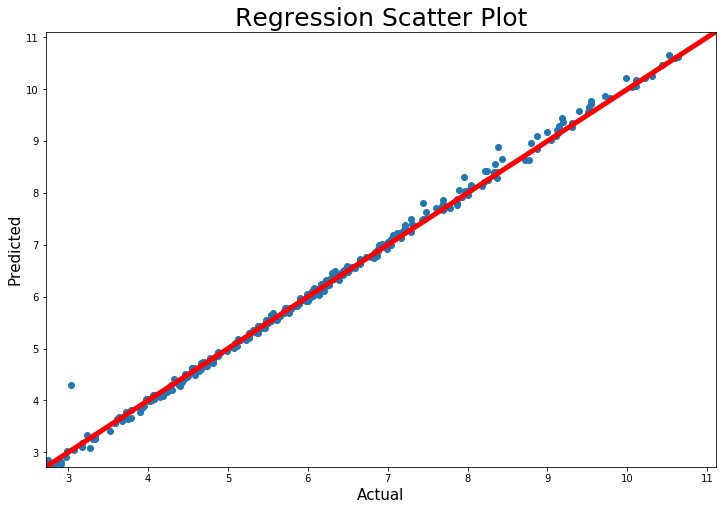

In [173]:
scatter_plot(y_test, nnr_mod.predict(X_test))

### 4.6. Saving Models

In [174]:
import pickle 

#ElasticNet
filename = 'EN_EUR_G.sav'
pickle.dump(en_mod, open(filename, 'wb'))

#Support Vector Regressor
filename = 'svr_EUR_G.sav'
pickle.dump(svr_mod, open(filename, 'wb'))

#Random Forest Regressor
filename = 'rf_EUR_G.sav'
pickle.dump(rf_mod, open(filename, 'wb'))

#Gradient Boosting Regressor
filename = 'grb_EUR_G.sav'
pickle.dump(grb_mod, open(filename, 'wb'))

#Neural Network Regressor
filename = 'nnr_EUR_G.sav'
pickle.dump(nnr_mod, open(filename, 'wb'))

# 5. Conclusion

### The key features that affect my target (EUR) are:

Using dimensionality reduction:

- L MULTI
- SAND CONC MODEL 
- TVD(M)
- INJ. RATE
- PERM
- PAY THICKNESS

Using Variance inflation factor (multicollinarity):

- SAND INTENSITY(KG.M3) (High correlation with FLUID INTENSITY)

According to Bowie (2018), the identification of key factors affecting my target can help the "process optimization by maximizing factors positively affecting well performance, in addition to cost savings if other predictor variables have little to no effect".  

### Using seaborn Pearson correlation matrix, the most important features for my target are (top 5): 

1) Lateral Length: 0.91

2) Perf Clusters: 0.79

2) Area: 0.75

4) Stages: 0.62

5) Fracture 1/2 Length: 0.26

# Model for Target: PV 10

#### Target

In [175]:
#PV 10
PV_10=train_target['PV(10)']
PV_10.head()

653     6930.382442
1591    9552.278968
1307    7666.190920
539     4064.735533
682     5073.862174
Name: PV(10), dtype: float64

In [176]:
#PV 10
feat_PV_10=pd.concat([PV_10, train_feat], axis=1)

### 1.2. Visualization

#### Features and Target (PV 10)

In [177]:
feat_target=pd.concat([train_feat, train_target], axis=1)
feat_target.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)       TVD(M)  \
653      1.000                3                  400      349.7  2956.900756   
1591     0.889                2                  200      263.6  2956.900756   
1307     0.889                4                  200      199.4  2956.900756   
539      0.889                4                  200      155.5  2956.900756   
682      1.000                4                  300      263.3  2956.900756   

      LATERAL LENGTH (M)  STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
653                 3500      46             92                 2000.0   
1591                5300      78            156                 1132.1   
1307                4000     116            116                 4500.0   
539                 3100      34             68                 4516.1   
682                 3500      34             68                 3000.0   

      FLUID INTENSITY (M3/M)  ...  EFFECTIVE IRR       PV(10)       PV(15)  \
653                     20.0  ...       0.853884  6930.382442  5358.070652   
1591                     9.5  ...       1.087076  9552.278968  7588.689882   
1307                    18.0  ...       0.728381  7666.190920  6020.435025   
539                     18.1  ...       0.409468  4064.735533  2771.923567   
682                     12.0  ...       0.468071  5073.862174  3468.582212   

       Royalty    PAYOUT       LIFE    NETBACK       F&D  RECYCLE RATIO  \
653   0.082517  1.333333  40.000000  14.327106  5.133588       2.790856   
1591  0.090752  1.166667  40.000000  14.497720  5.089388       2.848618   
1307  0.050019  1.416667  34.166667  15.766205  7.385450       2.134766   
539   0.048097  2.083333  36.583333  14.814777  7.277691       2.035642   
682   0.065236  2.000000  40.000000  14.407753  5.391182       2.672466   

       PV15 PI  
653   1.664542  
1591  1.796763  
1307  1.536067  
539   1.336641  
682   1.455917  

[5 rows x 37 columns]

In [178]:
feat_target.columns

Index(['LL MULTI', 'SAND CONC MODEL', 'LATERAL SPACING (M)', 'AREA (AC)',
       'TVD(M)', 'LATERAL LENGTH (M)', 'STAGES', 'PERF CLUSTERS',
       'SAND INTENSITY(KG.M3)', 'FLUID INTENSITY (M3/M)', 'INJ. RATE', 'PERM',
       'PAY THICKNESS', 'FRACTURE 1/2 LENGTH', 'FRACTURE CONDUCTIVITY',
       'REC. EFFICIENCY (GAS)', 'REC. EFFICIENCY (OIL)', ' DRILLING COST',
       'COMPLETION COST', 'EQUIPMENT COST', 'TOTAL WELL COST', 'IP90 GAS',
       'IP90 OIL', 'IP90 COND', 'GAS (EUR)', 'OIL (EUR)', 'COND (EUR)',
       'EFFECTIVE IRR', 'PV(10)', 'PV(15)', 'Royalty', 'PAYOUT', 'LIFE',
       'NETBACK', 'F&D', 'RECYCLE RATIO', 'PV15 PI'],
      dtype='object')

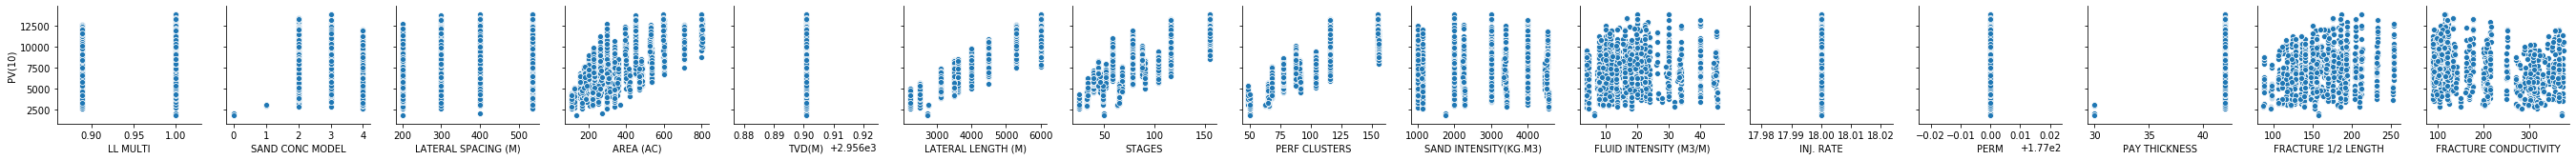

In [179]:
#PV 10
sns.pairplot(feat_target, y_vars="PV(10)", x_vars=feat_target.iloc[:,:15].columns.values)
plt.show()

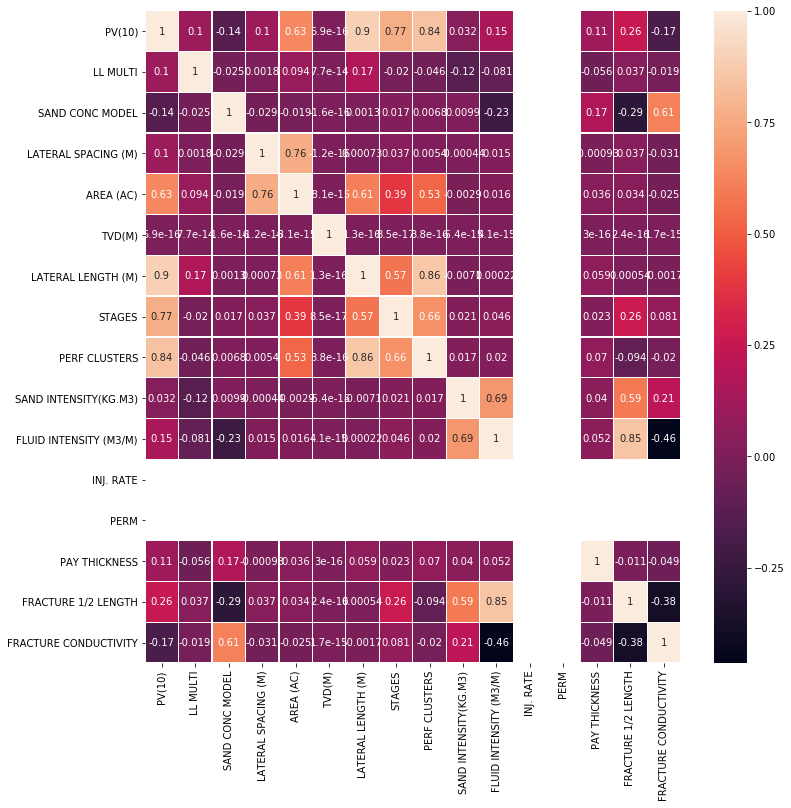

In [180]:
#Correlation matrix (Pearson)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = feat_PV_10.corr()
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

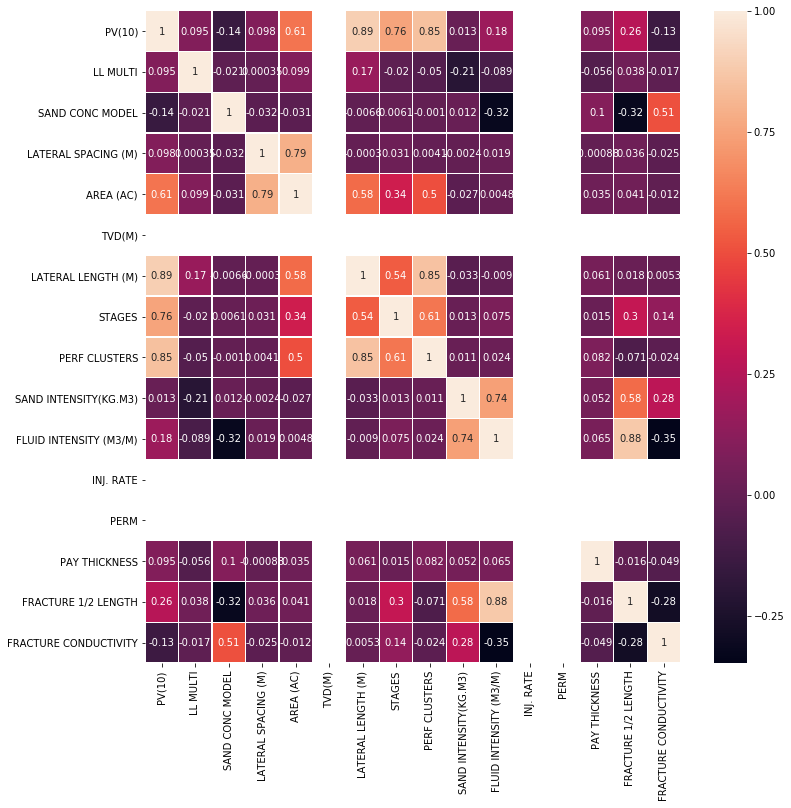

In [181]:
#Correlation matrix (spearman)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = feat_PV_10.corr(method='spearman')
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

In [182]:
def scatter_plot(y_test,y_pred):

    plt.figure(figsize=(12,8))
    ulim = np.max(y_test)
    llim = np.min(y_test)
    plt.scatter(y_test,y_pred)
    plt.plot([llim,ulim],[llim,ulim],linewidth=5, c='red')
    plt.title('Regression Scatter Plot', fontsize=25)
    plt.xlim([llim,ulim])
    plt.ylim([llim,ulim])
    plt.ylabel('Predicted', fontsize=15)
    plt.xlabel('Actual', fontsize=15)
    
    plt.show()

## 2. Data Split (Test/Train): PV 10

In [183]:
X_train, X_test, y_train, y_test = train_test_split(train_feat, PV_10, test_size=0.25, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)
print('Dimensions of y_train:',y_train.shape)
print('Dimensions of y_test:',y_test.shape)

Dimensions of X_train: (963, 15)
Dimensions of X_test: (322, 15)
Dimensions of y_train: (963,)
Dimensions of y_test: (322,)


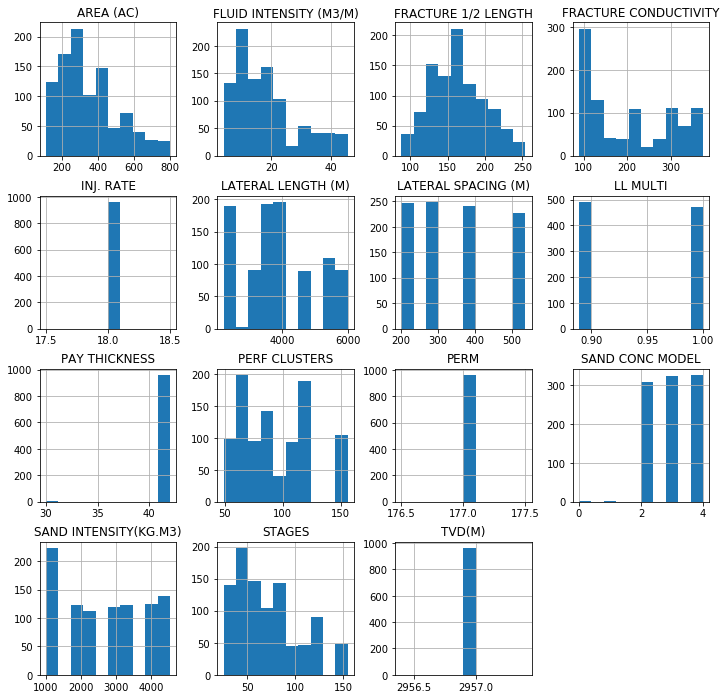

In [184]:
X_train.hist(figsize=(12,12))
plt.show()

In [185]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963 entries, 689 to 1554
Data columns (total 15 columns):
LL MULTI                  963 non-null float64
SAND CONC MODEL           963 non-null int64
LATERAL SPACING (M)       963 non-null int64
AREA (AC)                 963 non-null float64
TVD(M)                    963 non-null float64
LATERAL LENGTH (M)        963 non-null int64
STAGES                    963 non-null int64
PERF CLUSTERS             963 non-null int64
SAND INTENSITY(KG.M3)     963 non-null float64
FLUID INTENSITY (M3/M)    963 non-null float64
INJ. RATE                 963 non-null int64
PERM                      963 non-null int64
PAY THICKNESS             963 non-null int64
FRACTURE 1/2 LENGTH       963 non-null float64
FRACTURE CONDUCTIVITY     963 non-null float64
dtypes: float64(7), int64(8)
memory usage: 120.4 KB


## 3. Data Preprocessing

### 3.1. Feature Transform: MinMax Scaler

In [186]:
mscaler = MinMaxScaler(feature_range=(0, 1))

In [187]:
mscaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [188]:
X_train_scaled = mscaler.transform(X_train) # transform the train dataset to standardized data

# standardized training dataset
print("scaled minimum : %s " % np.min(X_train_scaled,axis=0))
print("scaled maximum : %s " % np.max(X_train_scaled,axis=0))

print("original minimum : %s " % mscaler.data_min_)
print("original maximum : %s " % mscaler.data_max_)

scaled minimum : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
scaled maximum : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 
original minimum : [8.89000000e-01 0.00000000e+00 2.00000000e+02 1.10400000e+02
 2.95690076e+03 2.20000000e+03 2.50000000e+01 4.90000000e+01
 1.00000000e+03 4.00000000e+00 1.80000000e+01 1.77000000e+02
 3.00000000e+01 8.76090940e+01 8.86309190e+01] 
original maximum : [1.00000000e+00 4.00000000e+00 5.36000000e+02 8.01600000e+02
 2.95690076e+03 6.00000000e+03 1.55000000e+02 1.56000000e+02
 4.54550000e+03 4.55000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 2.54072020e+02 3.75121530e+02] 


In [189]:
# scale the test data using the parameters learnt from the training dataset

X_test_scaled  = mscaler.transform(X_test)

print("minimum of scaled test data: %s" % np.min(X_test_scaled,axis=0))
print("maximum of scaled test data: %s " % np.max(X_test_scaled,axis=0))

## median of test data can be non-zero, and the IQR can be non-unitary
## just like the future data

minimum of scaled test data: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
maximum of scaled test data: [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 


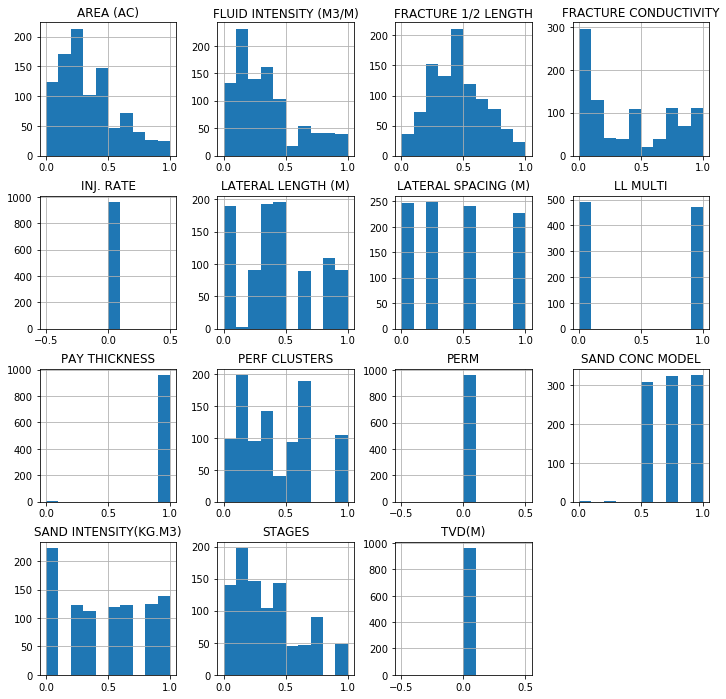

In [190]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

### 3.2. Feature Transform: Robust Scaler

In [191]:
# Robust Scaler
rscaler = RobustScaler() #instantiate
rscaler.fit(X_train) 

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [192]:
X_train_scaled = rscaler.transform(X_train) # transform the train dataset to standardized data

# Original training dataset
print("Original median : %s " % rscaler.center_)
print("Original IQR : %s " % rscaler.scale_)

#Scaled training dataset
print("Scaled median : %s " % np.median(X_train_scaled,axis=0))
print("Scaled IQR : %s " % (np.percentile(X_train_scaled, 75,axis=0)-np.percentile(X_train_scaled, 25,axis=0)))

Original median : [8.89000000e-01 3.00000000e+00 3.00000000e+02 3.09800000e+02
 2.95690076e+03 4.00000000e+03 5.80000000e+01 8.80000000e+01
 3.00000000e+03 1.60000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 1.56080510e+02 1.77499760e+02] 
Original IQR : [1.11000000e-01 2.00000000e+00 2.00000000e+02 2.25700000e+02
 1.00000000e+00 1.40000000e+03 4.40000000e+01 4.80000000e+01
 2.00000000e+03 1.20000000e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 5.08589900e+01 1.94208065e+02] 
Scaled median : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Scaled IQR : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.] 


In [193]:
#Scale the test data using the parameters learnt from the training dataset
X_test_scaled  = rscaler.transform(X_test)

print("Median of scaled test data: %s" % np.median(X_test_scaled,axis=0))
print("IQR of scaled test data: %s " % (np.percentile(X_test_scaled, 75,axis=0)-np.percentile(X_test_scaled, 25,axis=0)))

Median of scaled test data: [ 1.          0.          0.5         0.11785556  0.          0.
  0.15909091  0.0625      0.          0.          0.          0.
  0.          0.16016677 -0.04416022]
IQR of scaled test data: [1.         1.         1.18       0.96400089 0.         1.
 1.02272727 1.         0.9261375  0.95625    0.         0.
 0.         1.07477203 0.98993213] 


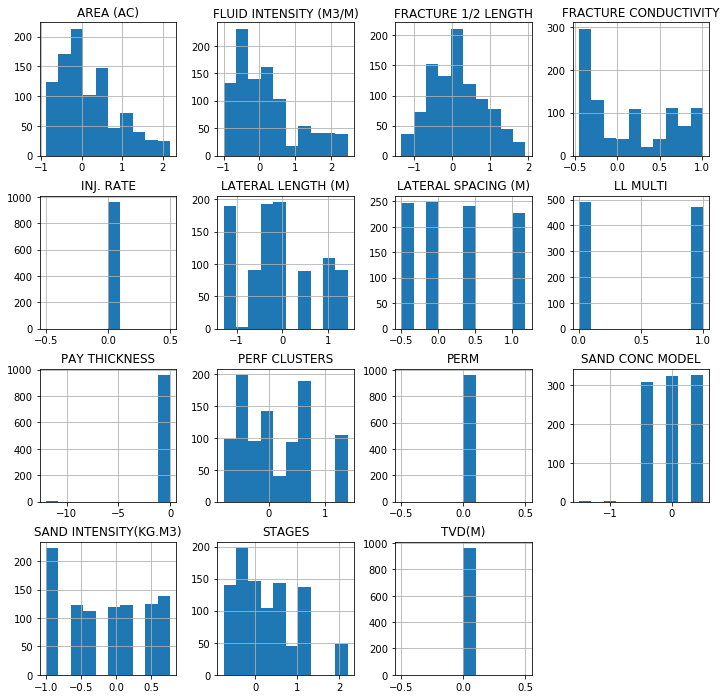

In [194]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

In [195]:
X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)

- Scaling is needed because the features have different ranges

### 3.3. Outlier Detection: Isolation Forest

In [196]:
# Isolation Forest
iforest = IsolationForest(n_estimators=200, contamination=0.08)
iforest = iforest.fit(X_train) #Training the model

In [197]:
#Predictions
X_train_predict = iforest.predict(X_train) 
X_train['Predict']=X_train_predict
X_train['Predict'] = X_train['Predict'].astype('category')
X_train

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   
...        ...              ...                  ...        ...     ...   
792        0.0             -0.5                 1.18   0.767390     0.0   
1617       0.0              0.0                 0.50   0.968542     0.0   
139        0.0              0.0                -0.50  -0.880815     0.0   
1803       1.0              0.0                -0.50  -0.047408     0.0   
1554       0.0              0.0                 0.00   0.383252     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   
...                  ...       ...            ...                    ...   
792            -0.285714  0.454545      -0.208333               -0.94445   
1617            0.928571  0.000000       0.583333               -0.36790   
139            -1.285714 -0.204545      -0.812500                0.20455   
1803            1.428571  1.318182       0.583333               -0.50000   
1554            0.928571  0.000000       0.583333               -0.93395   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   
...                      ...        ...   ...            ...   
792                -0.358333        0.0   0.0            0.0   
1617                0.550000        0.0   0.0            0.0   
139                 1.508333        0.0   0.0            0.0   
1803                0.333333        0.0   0.0            0.0   
1554               -0.391667        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY Predict  
689              0.262798               0.967360       1  
1740            -0.117428              -0.367979      -1  
945              0.736783               0.187212       1  
1576            -1.149778               0.541919      -1  
131              0.705289              -0.394607       1  
...                   ...                    ...     ...  
792              0.222537              -0.377114       1  
1617             0.288366              -0.410321       1  
139              1.487818              -0.295266       1  
1803             0.967157              -0.315834       1  
1554            -0.379853              -0.441523       1  

[963 rows x 16 columns]

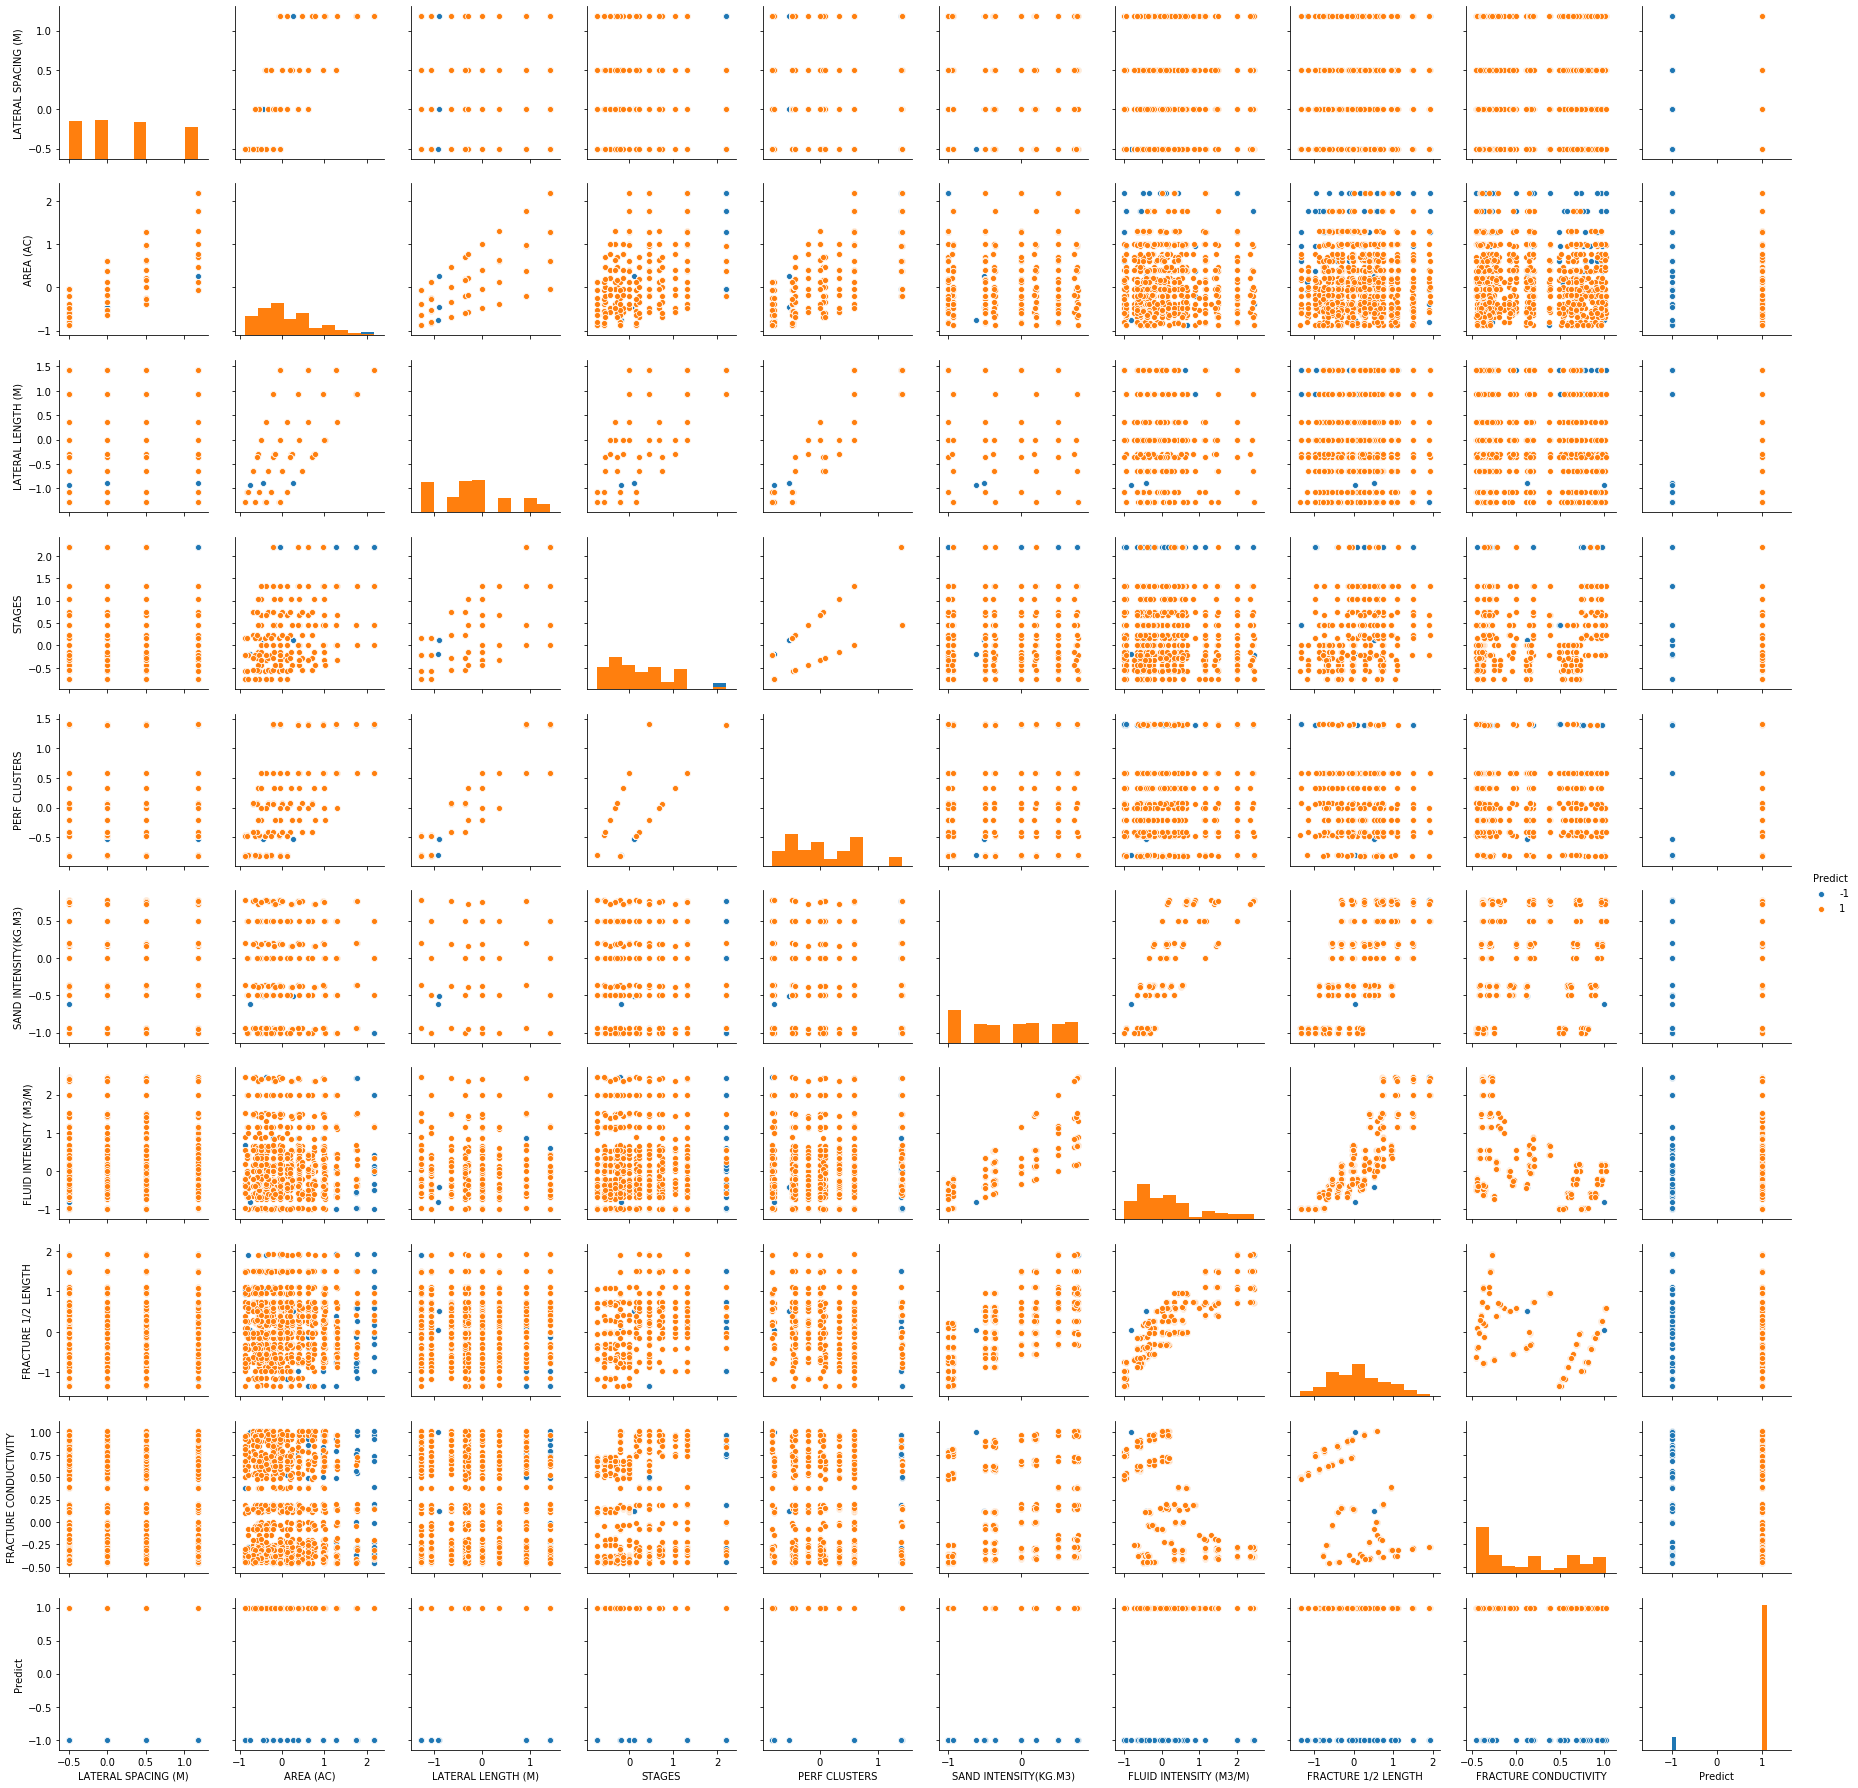

In [198]:
#Visualization
sns.pairplot(X_train.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'], axis = 1),hue='Predict',diag_kind='hist')
plt.show()

In [199]:
#Removing Outliers
#X_train['y_train']=y_train
#X_train = X_train[X_train['Predict'] == 1]

#y_train=X_train['y_train']
#X_train = X_train.drop(['Predict','y_train'], axis = 1)

- Outlier Detection was not perform since it doesn't display outliers

In [200]:
print(len(X_train))
print(len(y_train))

963
963


In [201]:
X_train = X_train.drop(['Predict'], axis = 1)

In [202]:
X_train.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY  
689              0.262798               0.967360  
1740            -0.117428              -0.367979  
945              0.736783               0.187212  
1576            -1.149778               0.541919  
131              0.705289              -0.394607

### 3.4. Dimensionality Reduction

#### ANOVA F-value and Mutual Information Value (X/Y): Correlation between X (features) and Y (target)

In [204]:
X_train_corr =X_train.drop(['TVD(M)','INJ. RATE','PERM'], axis = 1)

In [205]:
#f_test: Linear correlation between X and Y
f_test, _ = f_regression(X_train_corr, y_train) 
f_test /= np.max(f_test) # normalize f value

#mi: Nonlinear correlation between X and Y
mi = mutual_info_regression(X_train_corr, y_train) 
mi /= np.max(mi) # normalize mi value

In [206]:
print(f_test)
print(mi)

[2.34993084e-03 5.77441223e-03 2.76942685e-03 1.66545991e-01
 1.00000000e+00 3.14875621e-01 5.91221292e-01 1.67035989e-04
 5.74480513e-03 2.54214208e-03 1.54301549e-02 9.34503985e-03]
[0.047841   0.08088691 0.         0.46533731 0.82355503 1.
 0.88421867 0.12935133 0.20232895 0.00167394 0.24044636 0.21665902]


Text(0.5, 1.0, 'f_test value')

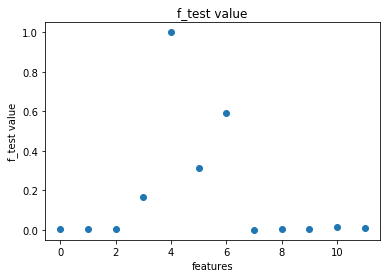

In [207]:
#Plot f_test
plt.figure()
plt.plot(f_test, 'o')
plt.ylabel('f_test value')
plt.xlabel('features')
plt.title('f_test value')

Text(0.5, 1.0, 'mi value')

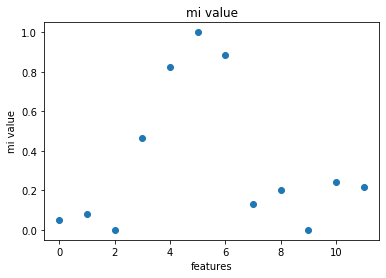

In [208]:
#Plot mi value
plt.figure()
plt.plot(mi, 'o')
plt.ylabel('mi value')
plt.xlabel('features')
plt.title('mi value')

- Large value of f_test indicates the feature is significant (linear correlation XY)
- Large value of mi indicates the feature is significant (nonlinear correlation XY)

#### Variance inflation factor (VIF): Multicollinarity analysis

In [209]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [210]:
calc_vif(X_train)

variables        VIF
0                 LL MULTI   2.115143
1          SAND CONC MODEL   2.130444
2      LATERAL SPACING (M)  15.350539
3                AREA (AC)  21.973528
4                   TVD(M)        NaN
5       LATERAL LENGTH (M)  14.655486
6                   STAGES   8.890235
7            PERF CLUSTERS  14.682333
8    SAND INTENSITY(KG.M3)   6.030387
9   FLUID INTENSITY (M3/M)  12.941499
10               INJ. RATE        NaN
11                    PERM        NaN
12           PAY THICKNESS   1.099520
13     FRACTURE 1/2 LENGTH  18.340667
14   FRACTURE CONDUCTIVITY   5.936741

- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [211]:
X_train_red =X_train.drop(['SAND INTENSITY(KG.M3)'], axis = 1)
X_test_red =X_test.drop(['SAND INTENSITY(KG.M3)'], axis = 1)

In [212]:
calc_vif(X_train_red)

variables        VIF
0                 LL MULTI   1.207998
1          SAND CONC MODEL   1.879004
2      LATERAL SPACING (M)  15.118515
3                AREA (AC)  21.810608
4                   TVD(M)        NaN
5       LATERAL LENGTH (M)  14.653236
6                   STAGES   6.733520
7            PERF CLUSTERS  13.922776
8   FLUID INTENSITY (M3/M)  11.982297
9                INJ. RATE        NaN
10                    PERM        NaN
11           PAY THICKNESS   1.074808
12     FRACTURE 1/2 LENGTH  15.750656
13   FRACTURE CONDUCTIVITY   2.108046

In [213]:
X_train=X_train_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
X_test=X_test_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (963, 8)
Dimensions of X_test: (322, 8)


## 4. Models

In [214]:
#Cross validation on training data (5-Fold)
cv = KFold(n_splits=5, shuffle = True, random_state=125) # instance

### 4.1. ElasticNet

In [215]:
# Train the ElasticNet model using alpha = 1, l1_ratio = 0.5, and default values for all other hyper-parameters. 
en = ElasticNet(alpha=1,l1_ratio=0.5)
en.fit(X_train, y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [216]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, en.predict(X_test)))
print('MSE', mean_squared_error(y_test, en.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, en.predict(X_test)))**0.5)

MAE 625.8387548311063
MSE 641077.5399930232
RMSE 800.6731792641884


In [217]:
# Hyperparameter optimization (GridSearchCV) for ELasticNet Model

param_grid = {'alpha': [0.01, 0.05, 0.1, 0.15], 'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]} 

en_mod = GridSearchCV(en, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  

en_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.15],
                         'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [218]:
# Best/optimal values of hyperparameters
print(en_mod.best_params_) 

{'alpha': 0.15, 'l1_ratio': 1}


In [219]:
# Performance of the optimal model
print('Scoring: ', en_mod.best_score_) 

Scoring:  -162011.2238025472


In [220]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, en_mod.predict(X_test)))
print('MSE', mean_squared_error(y_test, en_mod.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, en_mod.predict(X_test)))**0.5)

MAE 291.9071291071836
MSE 168458.21775830726
RMSE 410.4366184422477


In [221]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, en_mod.predict(X_test)))**0.5)

R2 0.9844069970877006


#### Plotting

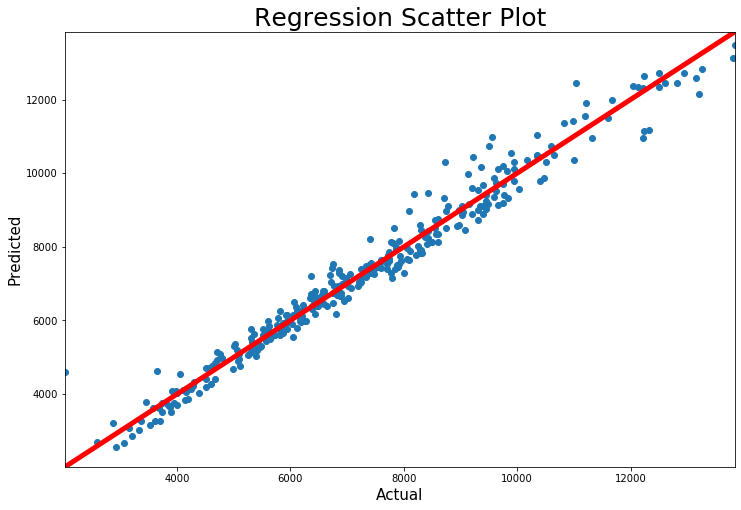

In [222]:
scatter_plot(y_test, en_mod.predict(X_test))

### 4.2. Support Vector Regressor

In [223]:
# Train SVR model using kernel='poly', degree=2, C=1000, and default values for all other hyper-parameters. 
sr =  SVR(kernel='poly',degree=2, C=1000)
sr.fit(X_train, y_train)

SVR(C=1000, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [224]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, sr.predict(X_test)))
print('MSE', mean_squared_error(y_test, sr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, sr.predict(X_test)))**0.5)

MAE 902.0013550516888
MSE 1632214.4917284022
RMSE 1277.581501012128


In [225]:
# Hyperparameter optimization (GridSearchCV) for SVR
param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'],'C': [1, 10, 100, 1000],'degree': [2,3,4]}]
  
svr_mod = GridSearchCV(sr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

svr_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1000, cache_size=200, coef0=0.0, degree=2,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [226]:
# Best/optimal values of hyperparameters
print(svr_mod.best_params_)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [227]:
# Performance of the optimal model
print('Scoring: ', svr_mod.best_score_) 

Scoring:  -54230.3056583754


In [228]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, svr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 118.28772544070486
Generalization performance (MSE) 43003.97615816929
Generalization performance (RMSE) 207.37400068033912


In [229]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, svr_mod.predict(X_test)))**0.5)

R2 0.99604262588304


#### Plotting

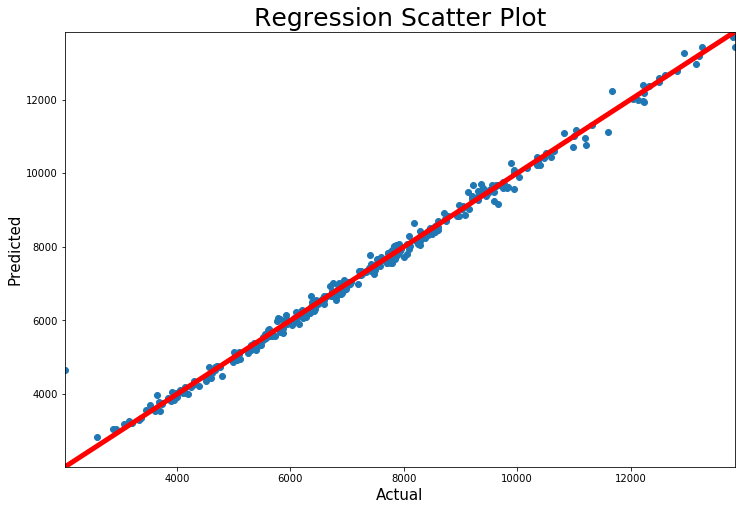

In [230]:
scatter_plot(y_test, svr_mod.predict(X_test))

### 4.3. Random Forest Regressor

In [231]:
# Train the Random Forest Regressor model using 200 estimators and default values for all other hyper-parameters.
rfr =  RandomForestRegressor(n_estimators=200,min_samples_leaf=5)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [232]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, rfr.predict(X_test)))
print('MSE', mean_squared_error(y_test, rfr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, rfr.predict(X_test)))**0.5)

MAE 253.801746036607
MSE 120577.66099298107
RMSE 347.24294232277936


In [233]:
# Hyperparameter optimization (GridSearchCV) for Random Forest 
param_grid = {'n_estimators':[50, 100, 200, 300],'min_samples_leaf': [1, 3, 5, 10], 'max_depth':[3,4,5], 'max_features':[2,3,4]} 

rf_mod = GridSearchCV(rfr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

rf_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

In [234]:
# Best/optimal values of hyperparameters
print(rf_mod.best_params_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 100}


In [235]:
# Performance of the optimal model
print('Scoring: ', rf_mod.best_score_) 

Scoring:  -246611.42433074597


In [236]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, rf_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 366.55205190254566
Generalization performance (MSE) 221606.94447528743
Generalization performance (RMSE) 470.751467841883


In [237]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, rf_mod.predict(X_test)))**0.5)

R2 0.9794358749240861


#### Plotting

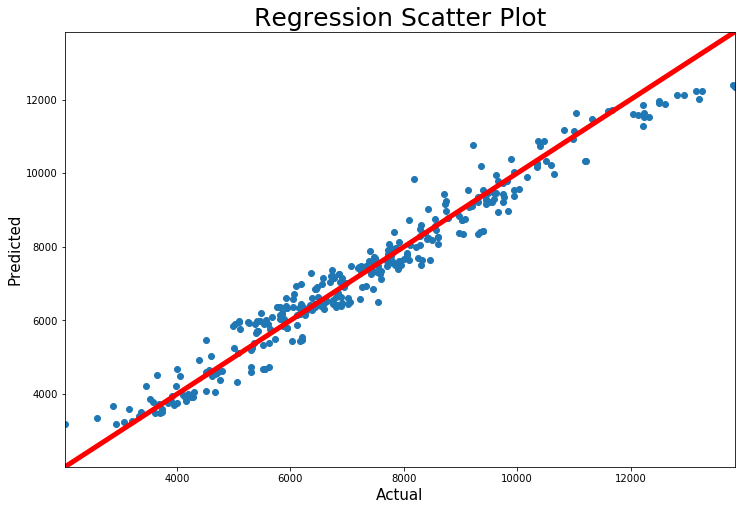

In [238]:
scatter_plot(y_test, rf_mod.predict(X_test))

### 4.4. Gradient Boosting Regressor

In [239]:
# Train the Gradient Boosting Regressor model using n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3
grb = GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3, random_state=0)
grb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [240]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, grb.predict(X_test)))
print('MSE', mean_squared_error(y_test, grb.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, grb.predict(X_test)))**0.5)

MAE 63.135283167218695
MSE 8442.813721285269
RMSE 91.88478503694324


In [241]:
# Hyperparameter optimization (GridSearchCV) for GBR
param_grid = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]}
  
grb_mod = GridSearchCV(grb, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

grb_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='huber', max_depth=4,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=3,
                                                 min_samples_split=2,
                                                 min_w...
                                                 presort='deprecated',
                                          

In [242]:
# Best/optimal values of hyperparameters
print(grb_mod.best_params_) 

{'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.2}


In [243]:
# Performance of the optimal model
print('Scoring: ', grb_mod.best_score_) 

Scoring:  -18918.864972917265


In [244]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, grb_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 67.55294593385679
Generalization performance (MSE) 16744.399261816285
Generalization performance (RMSE) 129.40015170708372


In [245]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, grb_mod.predict(X_test)))**0.5)

R2 0.9984609872974662


#### Ploting

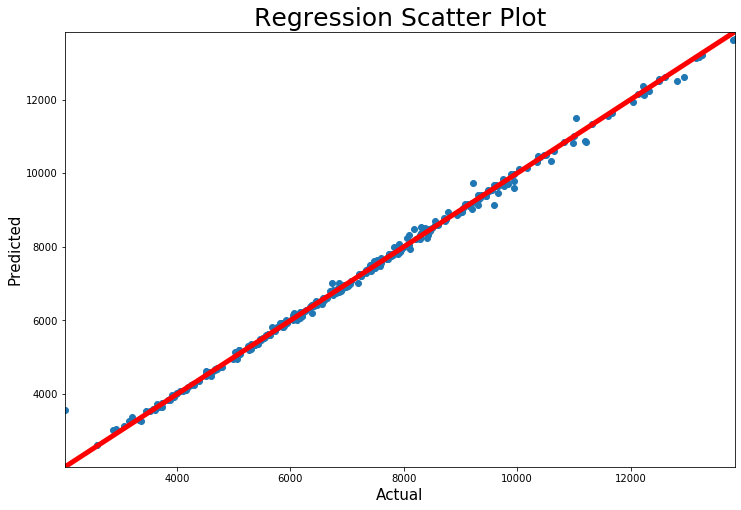

In [246]:
scatter_plot(y_test, grb_mod.predict(X_test))

### 4.5. Neural Network Regressor

In [247]:
# Train the Neural Network Regressor
nnr = MLPRegressor(hidden_layer_sizes=(4,4),activation='relu',alpha=0.001,early_stopping=False,tol=0.001,batch_size=200,max_iter=3000)
nnr.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(4, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=3000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [248]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, nnr.predict(X_test)))
print('MSE', mean_squared_error(y_test, nnr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, nnr.predict(X_test)))**0.5)

MAE 294.4505228692975
MSE 168566.04995815127
RMSE 410.56796021870883


In [249]:
# Hyperparameter optimization (GridSearchCV) for NNR
param_grid = {'solver': ['adam'],
              'activation': ['relu'],
              'hidden_layer_sizes': [(10,5),(7,7),(8,4),(10,10),(10),(100),(20,20),(20,20,20)],
              'batch_size': [100,200,300],
              'learning_rate_init': [0.001, 0.01, 0.05]}
    
nnr_mod = GridSearchCV(nnr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

nnr_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.001,
                                    batch_size=200, beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(4, 4),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=3000, momentum=0.9,
                                    n_iter_no_change=10,
                                    nestero...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'batch_size': [100, 200, 300],
                         'hidden_layer_sizes': [(10, 5), (

In [250]:
# Best/optimal values of hyperparameters
print(nnr_mod.best_params_) 

{'activation': 'relu', 'batch_size': 300, 'hidden_layer_sizes': (20, 20, 20), 'learning_rate_init': 0.05, 'solver': 'adam'}


In [251]:
# Performance of the optimal model
print('Scoring: ', nnr_mod.best_score_) 

Scoring:  -123709.36859036559


In [252]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, nnr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 270.20437776951246
Generalization performance (MSE) 152932.23715053385
Generalization performance (RMSE) 391.06551516406284


In [253]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, nnr_mod.predict(X_test)))**0.5)

R2 0.985854446814809


#### Plotting

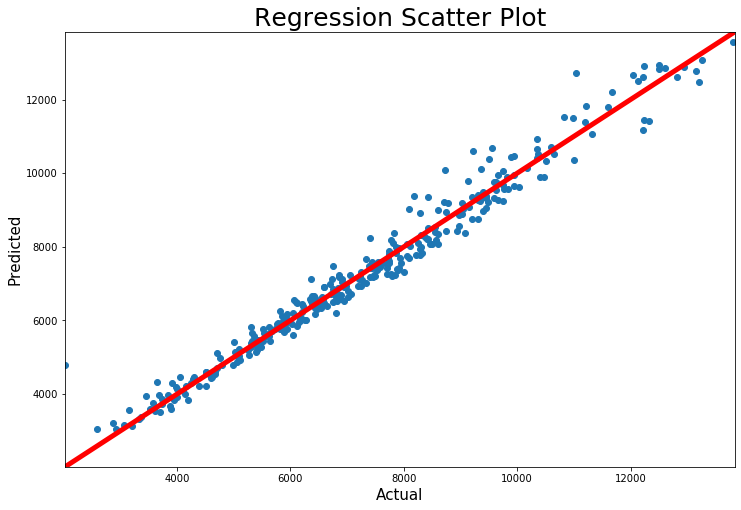

In [254]:
scatter_plot(y_test, nnr_mod.predict(X_test))

### 4.6. Saving Models

In [255]:
import pickle 

#ElasticNet
filename = 'EN_PV10.sav'
pickle.dump(en_mod, open(filename, 'wb'))

#Support Vector Regressor
filename = 'svr_PV10.sav'
pickle.dump(svr_mod, open(filename, 'wb'))

#Random Forest Regressor
filename = 'rf_PV10.sav'
pickle.dump(rf_mod, open(filename, 'wb'))

#Gradient Boosting Regressor
filename = 'grb_PV10.sav'
pickle.dump(grb_mod, open(filename, 'wb'))

#Neural Network Regressor
filename = 'nnr_PV10.sav'
pickle.dump(nnr_mod, open(filename, 'wb'))

# 5. Conclusion

### The key features that affect my target (PV10) are:

Using dimensionality reduction:

- L MULTI
- SAND CONC MODEL 
- TVD(M)
- INJ. RATE
- PERM
- PAY THICKNESS

Using Variance inflation factor (multicollinarity):

- SAND INTENSITY(KG.M3) (High correlation with FLUID INTENSITY)

### Using seaborn Pearson correlation matrix, the most important features for my target are (top 5): 

1) Lateral Length: 0.9

2) Perf Clusters: 0.84

2) Area: 0.77

4) Stages: 0.63

5) Fracture 1/2 Length: 0.26

# Model for Target: Completion Cost

#### Target

In [256]:
#COMPLETION COST
comp_cost=train_target['COMPLETION COST']
comp_cost.head()

653     4707.802059
1591    4475.043418
1307    7522.065922
539     5276.606255
682     4233.663765
Name: COMPLETION COST, dtype: float64

In [257]:
c_cost_feat=pd.concat([comp_cost ,train_feat], axis=1)

### 1.2. Visualization

#### Features and Target (Completion Cost)

In [258]:
feat_target=pd.concat([train_feat, train_target], axis=1)
feat_target.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)       TVD(M)  \
653      1.000                3                  400      349.7  2956.900756   
1591     0.889                2                  200      263.6  2956.900756   
1307     0.889                4                  200      199.4  2956.900756   
539      0.889                4                  200      155.5  2956.900756   
682      1.000                4                  300      263.3  2956.900756   

      LATERAL LENGTH (M)  STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
653                 3500      46             92                 2000.0   
1591                5300      78            156                 1132.1   
1307                4000     116            116                 4500.0   
539                 3100      34             68                 4516.1   
682                 3500      34             68                 3000.0   

      FLUID INTENSITY (M3/M)  ...  EFFECTIVE IRR       PV(10)       PV(15)  \
653                     20.0  ...       0.853884  6930.382442  5358.070652   
1591                     9.5  ...       1.087076  9552.278968  7588.689882   
1307                    18.0  ...       0.728381  7666.190920  6020.435025   
539                     18.1  ...       0.409468  4064.735533  2771.923567   
682                     12.0  ...       0.468071  5073.862174  3468.582212   

       Royalty    PAYOUT       LIFE    NETBACK       F&D  RECYCLE RATIO  \
653   0.082517  1.333333  40.000000  14.327106  5.133588       2.790856   
1591  0.090752  1.166667  40.000000  14.497720  5.089388       2.848618   
1307  0.050019  1.416667  34.166667  15.766205  7.385450       2.134766   
539   0.048097  2.083333  36.583333  14.814777  7.277691       2.035642   
682   0.065236  2.000000  40.000000  14.407753  5.391182       2.672466   

       PV15 PI  
653   1.664542  
1591  1.796763  
1307  1.536067  
539   1.336641  
682   1.455917  

[5 rows x 37 columns]

In [259]:
feat_target.columns

Index(['LL MULTI', 'SAND CONC MODEL', 'LATERAL SPACING (M)', 'AREA (AC)',
       'TVD(M)', 'LATERAL LENGTH (M)', 'STAGES', 'PERF CLUSTERS',
       'SAND INTENSITY(KG.M3)', 'FLUID INTENSITY (M3/M)', 'INJ. RATE', 'PERM',
       'PAY THICKNESS', 'FRACTURE 1/2 LENGTH', 'FRACTURE CONDUCTIVITY',
       'REC. EFFICIENCY (GAS)', 'REC. EFFICIENCY (OIL)', ' DRILLING COST',
       'COMPLETION COST', 'EQUIPMENT COST', 'TOTAL WELL COST', 'IP90 GAS',
       'IP90 OIL', 'IP90 COND', 'GAS (EUR)', 'OIL (EUR)', 'COND (EUR)',
       'EFFECTIVE IRR', 'PV(10)', 'PV(15)', 'Royalty', 'PAYOUT', 'LIFE',
       'NETBACK', 'F&D', 'RECYCLE RATIO', 'PV15 PI'],
      dtype='object')

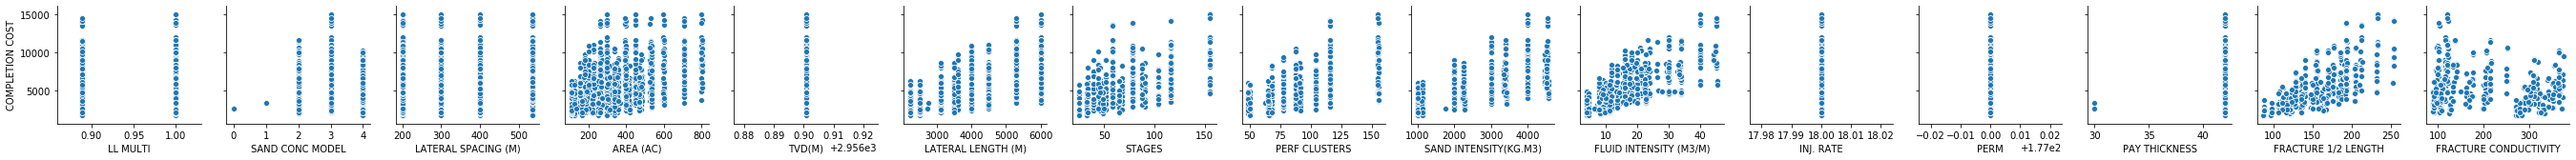

In [260]:
#COMPLETION COST
sns.pairplot(feat_target, y_vars="COMPLETION COST", x_vars=feat_target.iloc[:,:15].columns.values)
plt.show()

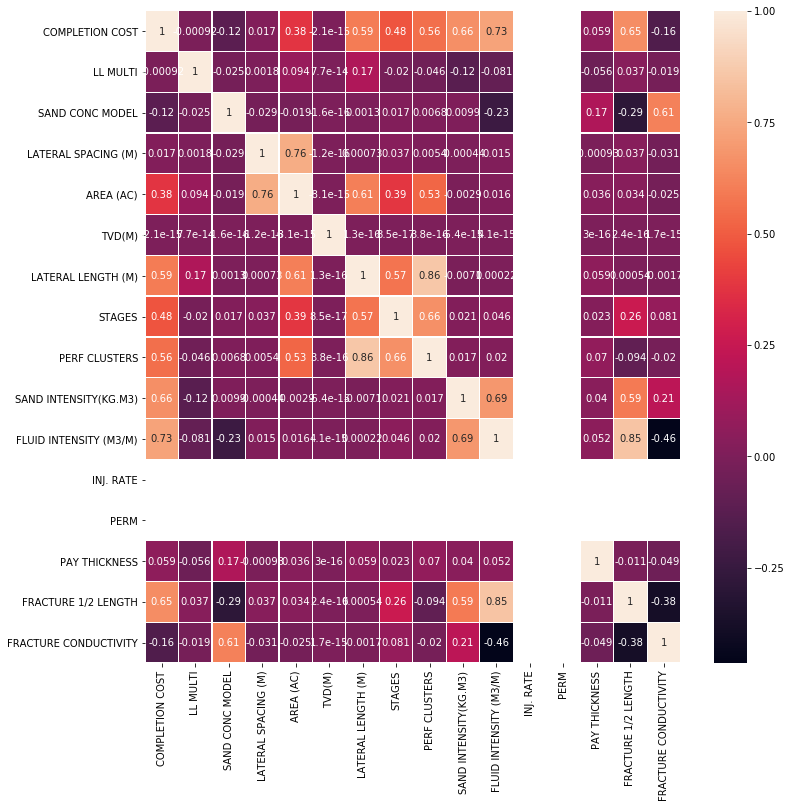

In [261]:
#Correlation matrix (Pearson)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = c_cost_feat.corr()
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

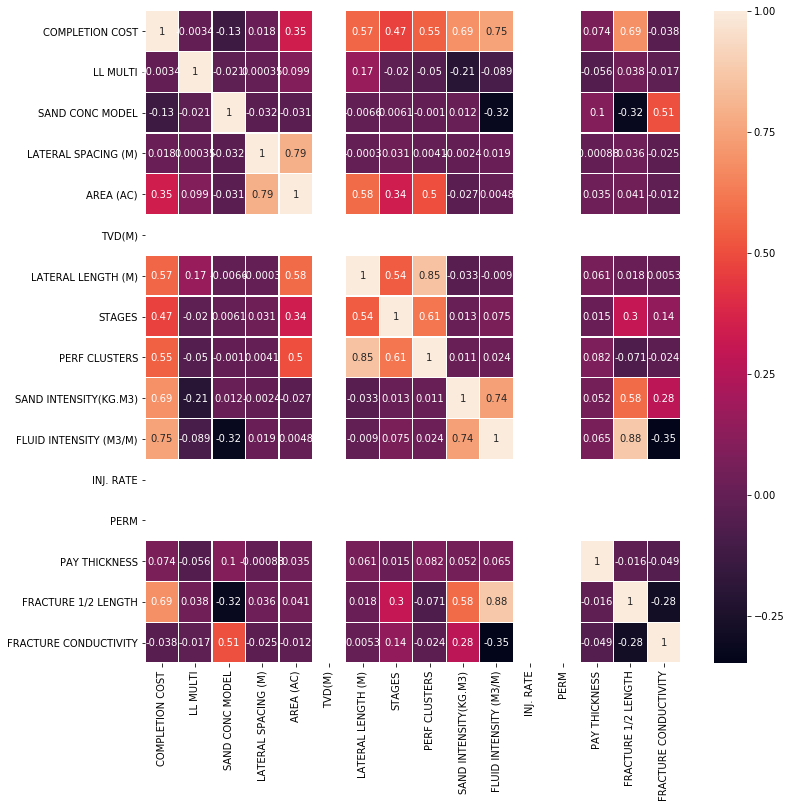

In [262]:
#Correlation matrix (spearman)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = c_cost_feat.corr(method='spearman')
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

In [263]:
def scatter_plot(y_test,y_pred):

    plt.figure(figsize=(12,8))
    ulim = np.max(y_test)
    llim = np.min(y_test)
    plt.scatter(y_test,y_pred)
    plt.plot([llim,ulim],[llim,ulim],linewidth=5, c='red')
    plt.title('Regression Scatter Plot', fontsize=25)
    plt.xlim([llim,ulim])
    plt.ylim([llim,ulim])
    plt.ylabel('Predicted', fontsize=15)
    plt.xlabel('Actual', fontsize=15)
    
    plt.show()

## 2. Data Split (Test/Train): Completion Cost

In [264]:
X_train, X_test, y_train, y_test = train_test_split(train_feat, comp_cost, test_size=0.25, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)
print('Dimensions of y_train:',y_train.shape)
print('Dimensions of y_test:',y_test.shape)

Dimensions of X_train: (963, 15)
Dimensions of X_test: (322, 15)
Dimensions of y_train: (963,)
Dimensions of y_test: (322,)


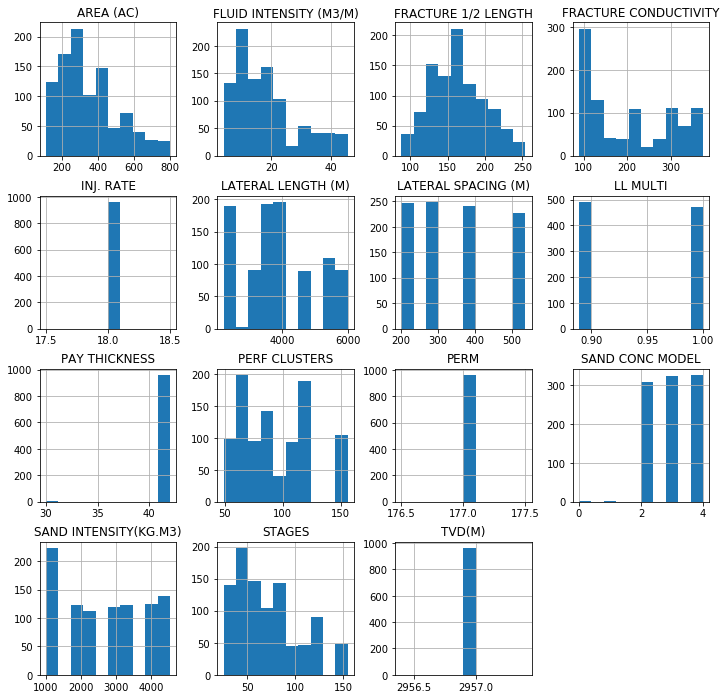

In [265]:
X_train.hist(figsize=(12,12))
plt.show()

In [266]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963 entries, 689 to 1554
Data columns (total 15 columns):
LL MULTI                  963 non-null float64
SAND CONC MODEL           963 non-null int64
LATERAL SPACING (M)       963 non-null int64
AREA (AC)                 963 non-null float64
TVD(M)                    963 non-null float64
LATERAL LENGTH (M)        963 non-null int64
STAGES                    963 non-null int64
PERF CLUSTERS             963 non-null int64
SAND INTENSITY(KG.M3)     963 non-null float64
FLUID INTENSITY (M3/M)    963 non-null float64
INJ. RATE                 963 non-null int64
PERM                      963 non-null int64
PAY THICKNESS             963 non-null int64
FRACTURE 1/2 LENGTH       963 non-null float64
FRACTURE CONDUCTIVITY     963 non-null float64
dtypes: float64(7), int64(8)
memory usage: 120.4 KB


## 3. Data Preprocessing

### 3.1. Feature Transform: MinMax Scaler

In [267]:
mscaler = MinMaxScaler(feature_range=(0, 1))

In [268]:
mscaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [269]:
X_train_scaled = mscaler.transform(X_train) # transform the train dataset to standardized data

# standardized training dataset
print("scaled minimum : %s " % np.min(X_train_scaled,axis=0))
print("scaled maximum : %s " % np.max(X_train_scaled,axis=0))

print("original minimum : %s " % mscaler.data_min_)
print("original maximum : %s " % mscaler.data_max_)

scaled minimum : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
scaled maximum : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 
original minimum : [8.89000000e-01 0.00000000e+00 2.00000000e+02 1.10400000e+02
 2.95690076e+03 2.20000000e+03 2.50000000e+01 4.90000000e+01
 1.00000000e+03 4.00000000e+00 1.80000000e+01 1.77000000e+02
 3.00000000e+01 8.76090940e+01 8.86309190e+01] 
original maximum : [1.00000000e+00 4.00000000e+00 5.36000000e+02 8.01600000e+02
 2.95690076e+03 6.00000000e+03 1.55000000e+02 1.56000000e+02
 4.54550000e+03 4.55000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 2.54072020e+02 3.75121530e+02] 


In [270]:
# scale the test data using the parameters learnt from the training dataset

X_test_scaled  = mscaler.transform(X_test)

print("minimum of scaled test data: %s" % np.min(X_test_scaled,axis=0))
print("maximum of scaled test data: %s " % np.max(X_test_scaled,axis=0))

## median of test data can be non-zero, and the IQR can be non-unitary
## just like the future data

minimum of scaled test data: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
maximum of scaled test data: [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 


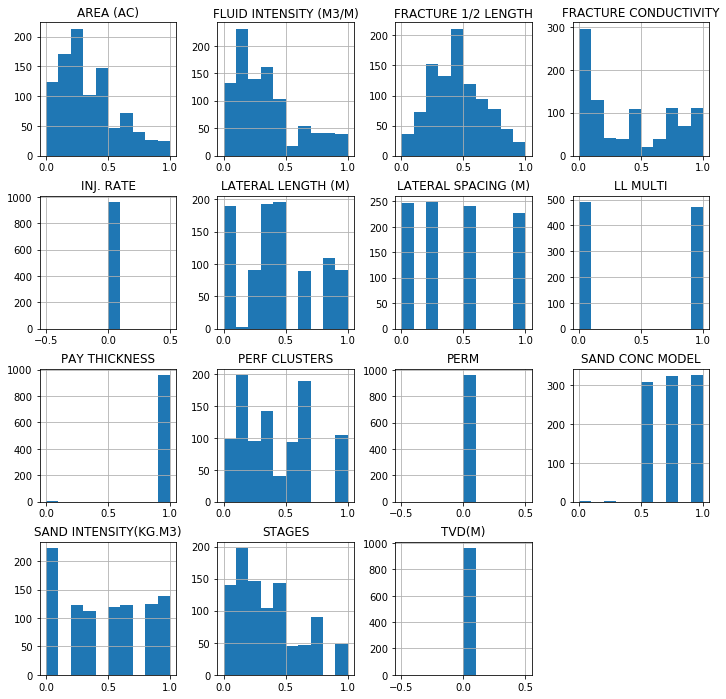

In [271]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

### 3.2. Feature Transform: Robust Scaler

In [272]:
# Robust Scaler
rscaler = RobustScaler() #instantiate
rscaler.fit(X_train) 

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [273]:
X_train_scaled = rscaler.transform(X_train) # transform the train dataset to standardized data

# Original training dataset
print("Original median : %s " % rscaler.center_)
print("Original IQR : %s " % rscaler.scale_)

#Scaled training dataset
print("Scaled median : %s " % np.median(X_train_scaled,axis=0))
print("Scaled IQR : %s " % (np.percentile(X_train_scaled, 75,axis=0)-np.percentile(X_train_scaled, 25,axis=0)))

Original median : [8.89000000e-01 3.00000000e+00 3.00000000e+02 3.09800000e+02
 2.95690076e+03 4.00000000e+03 5.80000000e+01 8.80000000e+01
 3.00000000e+03 1.60000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 1.56080510e+02 1.77499760e+02] 
Original IQR : [1.11000000e-01 2.00000000e+00 2.00000000e+02 2.25700000e+02
 1.00000000e+00 1.40000000e+03 4.40000000e+01 4.80000000e+01
 2.00000000e+03 1.20000000e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 5.08589900e+01 1.94208065e+02] 
Scaled median : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Scaled IQR : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.] 


In [274]:
#Scale the test data using the parameters learnt from the training dataset
X_test_scaled  = rscaler.transform(X_test)

print("Median of scaled test data: %s" % np.median(X_test_scaled,axis=0))
print("IQR of scaled test data: %s " % (np.percentile(X_test_scaled, 75,axis=0)-np.percentile(X_test_scaled, 25,axis=0)))

Median of scaled test data: [ 1.          0.          0.5         0.11785556  0.          0.
  0.15909091  0.0625      0.          0.          0.          0.
  0.          0.16016677 -0.04416022]
IQR of scaled test data: [1.         1.         1.18       0.96400089 0.         1.
 1.02272727 1.         0.9261375  0.95625    0.         0.
 0.         1.07477203 0.98993213] 


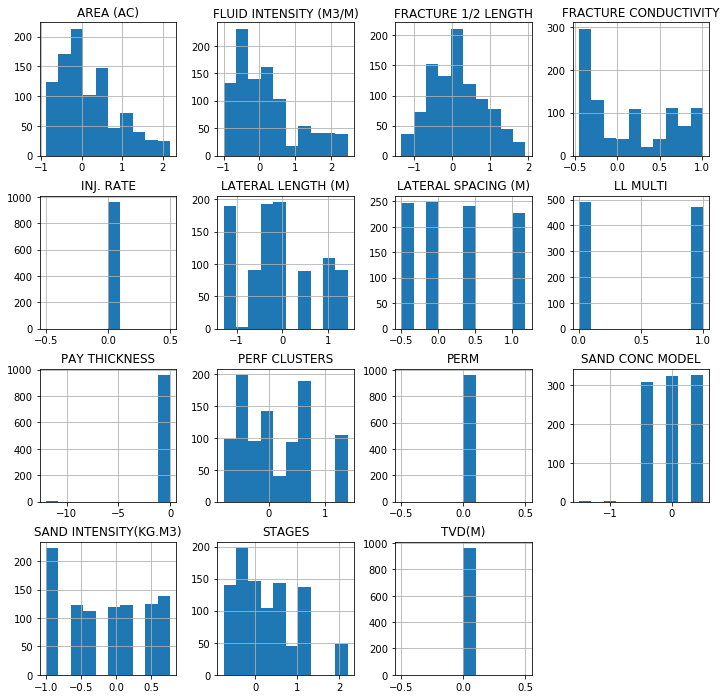

In [275]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

In [276]:
X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)

- Scaling is needed because the features have different ranges

### 3.3. Outlier Detection: Isolation Forest

In [277]:
# Isolation Forest
iforest = IsolationForest(n_estimators=200, contamination=0.08)
iforest = iforest.fit(X_train) #Training the model

In [278]:
#Predictions
X_train_predict = iforest.predict(X_train) 
X_train['Predict']=X_train_predict
X_train['Predict'] = X_train['Predict'].astype('category')
X_train

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   
...        ...              ...                  ...        ...     ...   
792        0.0             -0.5                 1.18   0.767390     0.0   
1617       0.0              0.0                 0.50   0.968542     0.0   
139        0.0              0.0                -0.50  -0.880815     0.0   
1803       1.0              0.0                -0.50  -0.047408     0.0   
1554       0.0              0.0                 0.00   0.383252     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   
...                  ...       ...            ...                    ...   
792            -0.285714  0.454545      -0.208333               -0.94445   
1617            0.928571  0.000000       0.583333               -0.36790   
139            -1.285714 -0.204545      -0.812500                0.20455   
1803            1.428571  1.318182       0.583333               -0.50000   
1554            0.928571  0.000000       0.583333               -0.93395   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   
...                      ...        ...   ...            ...   
792                -0.358333        0.0   0.0            0.0   
1617                0.550000        0.0   0.0            0.0   
139                 1.508333        0.0   0.0            0.0   
1803                0.333333        0.0   0.0            0.0   
1554               -0.391667        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY Predict  
689              0.262798               0.967360       1  
1740            -0.117428              -0.367979      -1  
945              0.736783               0.187212       1  
1576            -1.149778               0.541919       1  
131              0.705289              -0.394607       1  
...                   ...                    ...     ...  
792              0.222537              -0.377114       1  
1617             0.288366              -0.410321       1  
139              1.487818              -0.295266       1  
1803             0.967157              -0.315834       1  
1554            -0.379853              -0.441523       1  

[963 rows x 16 columns]

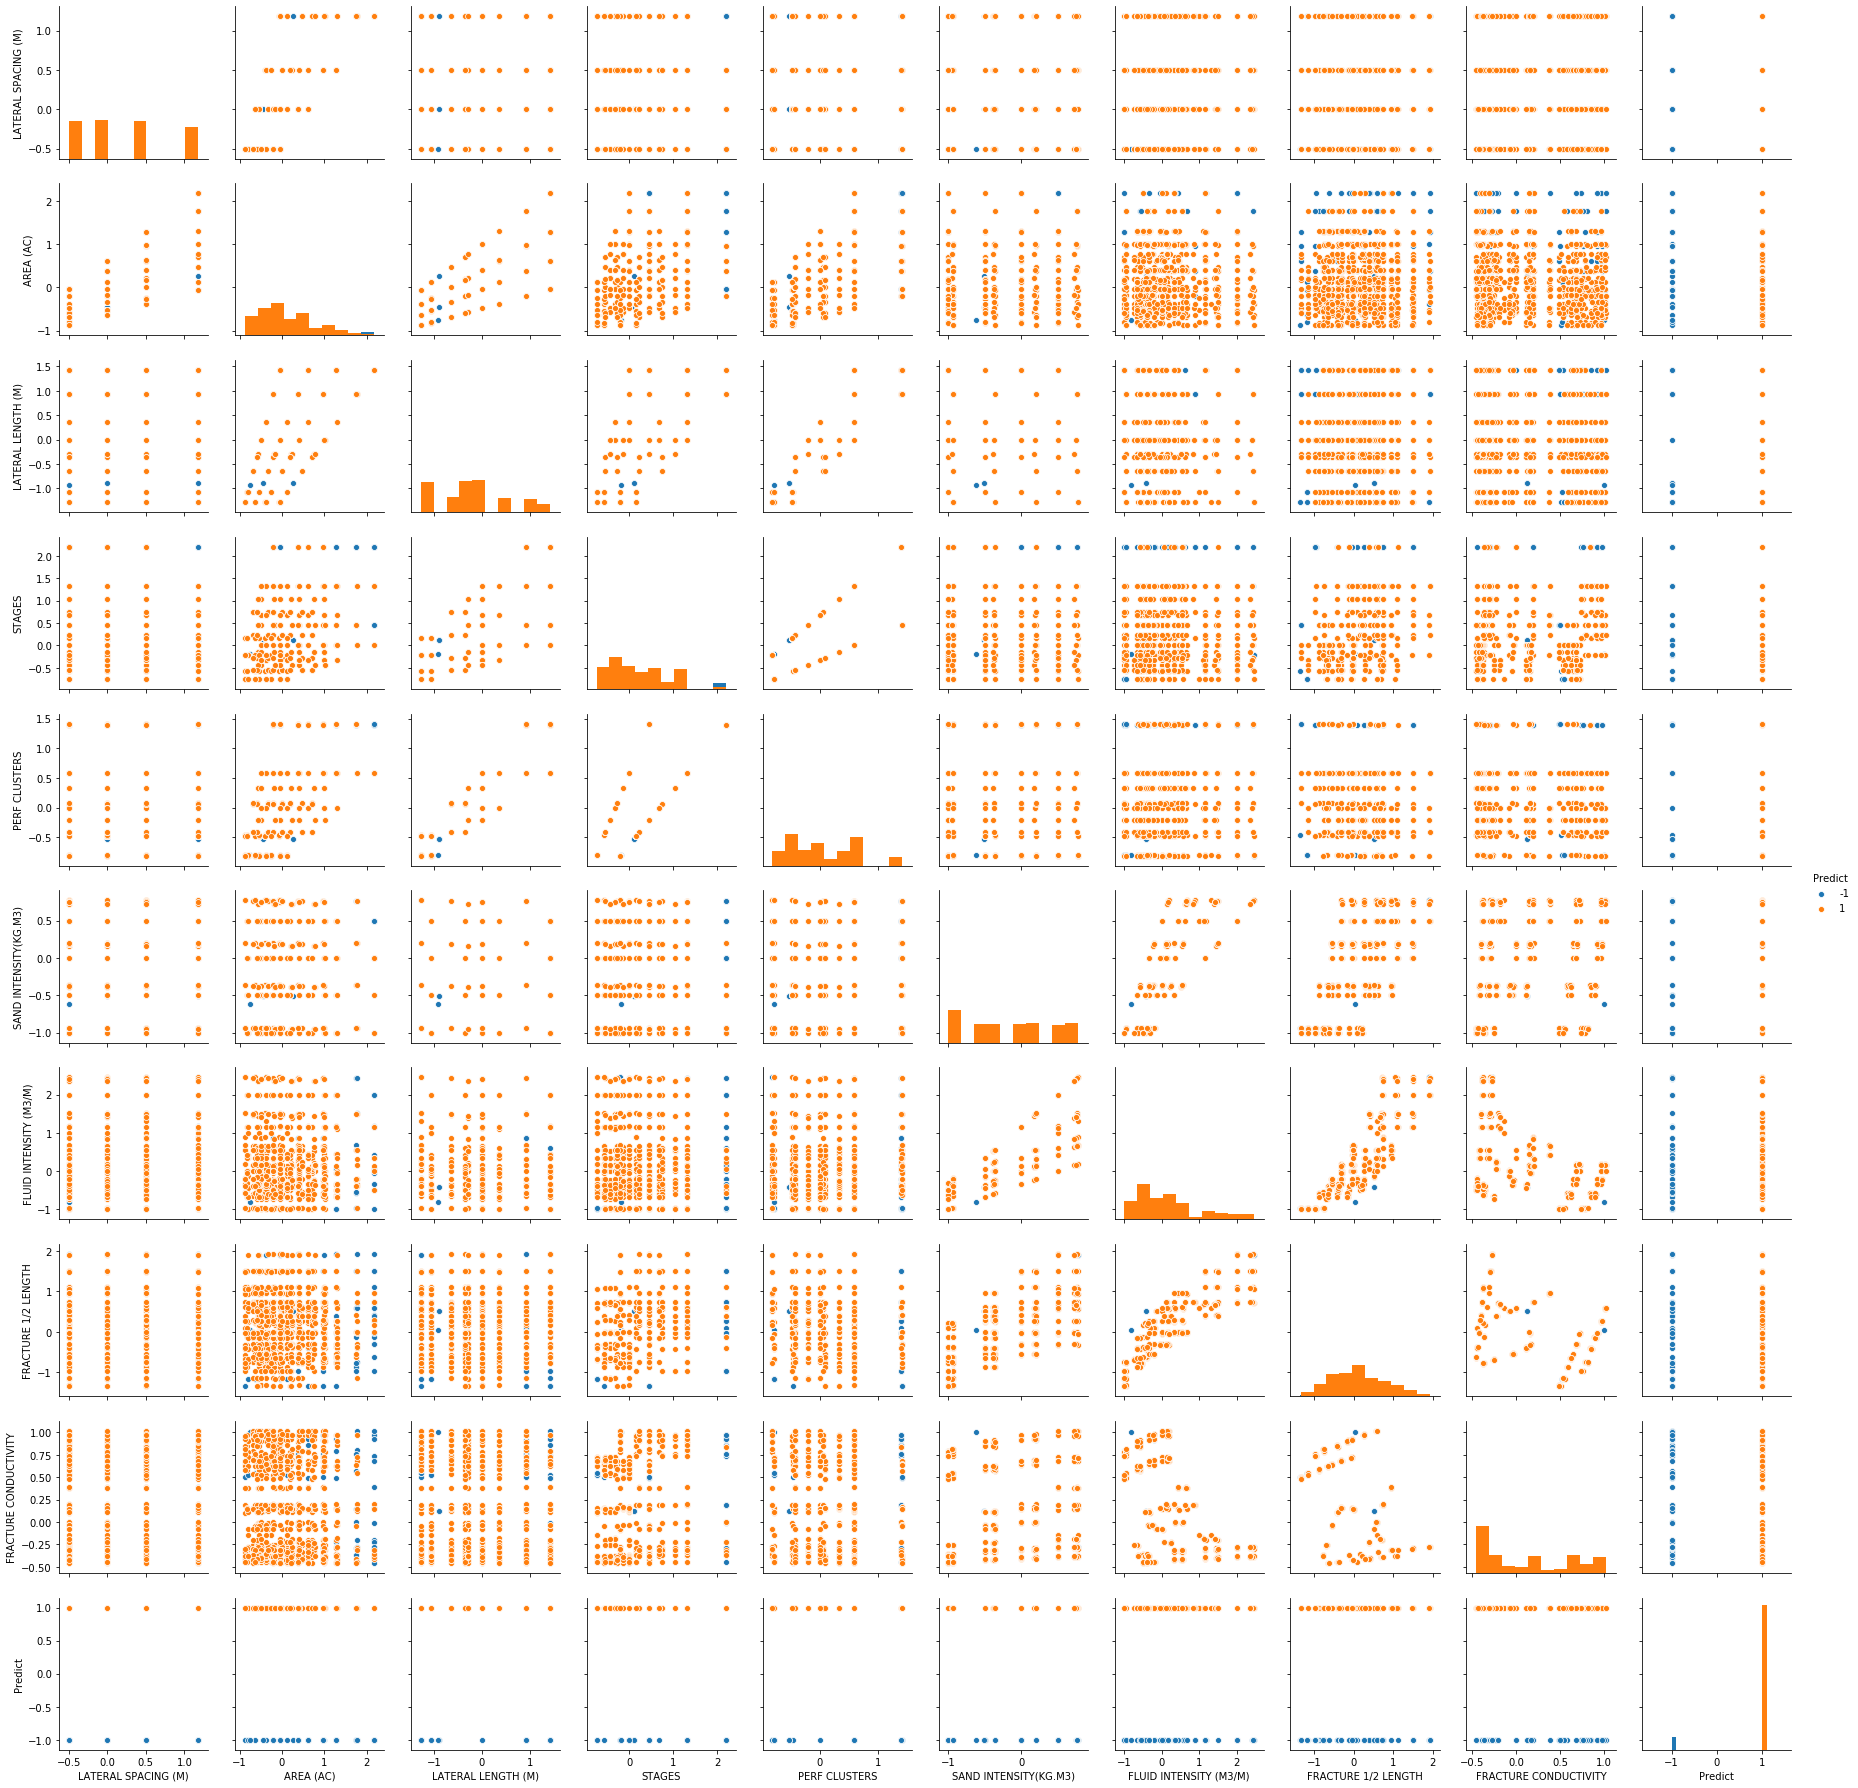

In [279]:
#Visualization
sns.pairplot(X_train.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'], axis = 1),hue='Predict',diag_kind='hist')
plt.show()

In [280]:
#Removing Outliers
#X_train['y_train']=y_train
#X_train = X_train[X_train['Predict'] == 1]

#y_train=X_train['y_train']
#X_train = X_train.drop(['Predict','y_train'], axis = 1)

- Outlier Detection was not perform since it doesn't display outliers

In [281]:
print(len(X_train))
print(len(y_train))

963
963


In [282]:
X_train = X_train.drop(['Predict'], axis = 1)

In [283]:
X_train.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY  
689              0.262798               0.967360  
1740            -0.117428              -0.367979  
945              0.736783               0.187212  
1576            -1.149778               0.541919  
131              0.705289              -0.394607

### 3.4. Dimensionality Reduction

#### ANOVA F-value and Mutual Information Value (X/Y): Correlation between X (features) and Y (target)

In [284]:
X_train_corr =X_train.drop(['TVD(M)','INJ. RATE','PERM'], axis = 1)

In [285]:
#f_test: Linear correlation between X and Y
f_test, _ = f_regression(X_train_corr, y_train) 
f_test /= np.max(f_test) # normalize f value

#mi: Nonlinear correlation between X and Y
mi = mutual_info_regression(X_train_corr, y_train) 
mi /= np.max(mi) # normalize mi value

In [286]:
print(f_test)
print(mi)

[3.65043340e-05 1.54961870e-02 7.19538697e-04 1.66067173e-01
 4.86828455e-01 2.67248997e-01 4.14620112e-01 6.57769373e-01
 1.00000000e+00 2.75512160e-03 6.57077226e-01 2.70407566e-02]
[0.02432137 0.22068466 0.         0.         0.19162115 0.58887657
 0.52170265 0.30172177 0.36835686 0.         1.         0.86962689]


Text(0.5, 1.0, 'f_test value')

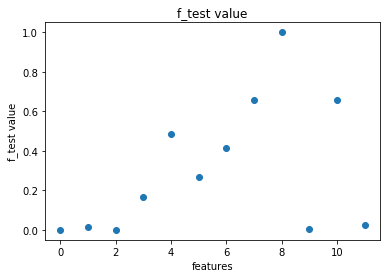

In [287]:
#Plot f_test
plt.figure()
plt.plot(f_test, 'o')
plt.ylabel('f_test value')
plt.xlabel('features')
plt.title('f_test value')

Text(0.5, 1.0, 'mi value')

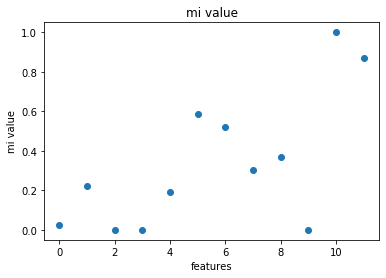

In [288]:
#Plot mi value
plt.figure()
plt.plot(mi, 'o')
plt.ylabel('mi value')
plt.xlabel('features')
plt.title('mi value')

- Large value of f_test indicates the feature is significant (linear correlation XY)
- Large value of mi indicates the feature is significant (nonlinear correlation XY)

#### Variance inflation factor (VIF): Multicollinarity analysis

In [289]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [290]:
calc_vif(X_train)

variables        VIF
0                 LL MULTI   2.115143
1          SAND CONC MODEL   2.130444
2      LATERAL SPACING (M)  15.350539
3                AREA (AC)  21.973528
4                   TVD(M)        NaN
5       LATERAL LENGTH (M)  14.655486
6                   STAGES   8.890235
7            PERF CLUSTERS  14.682333
8    SAND INTENSITY(KG.M3)   6.030387
9   FLUID INTENSITY (M3/M)  12.941499
10               INJ. RATE        NaN
11                    PERM        NaN
12           PAY THICKNESS   1.099520
13     FRACTURE 1/2 LENGTH  18.340667
14   FRACTURE CONDUCTIVITY   5.936741

- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [291]:
X_train_red =X_train.drop(['AREA (AC)'], axis = 1)
X_test_red =X_test.drop(['AREA (AC)'], axis = 1)

In [292]:
calc_vif(X_train_red)

variables        VIF
0                 LL MULTI   2.109764
1          SAND CONC MODEL   2.127629
2      LATERAL SPACING (M)   1.183535
3                   TVD(M)        NaN
4       LATERAL LENGTH (M)   5.500174
5                   STAGES   8.862214
6            PERF CLUSTERS  14.590940
7    SAND INTENSITY(KG.M3)   5.985676
8   FLUID INTENSITY (M3/M)  12.939862
9                INJ. RATE        NaN
10                    PERM        NaN
11           PAY THICKNESS   1.098881
12     FRACTURE 1/2 LENGTH  18.305325
13   FRACTURE CONDUCTIVITY   5.893039

In [293]:
X_train=X_train_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
X_test=X_test_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (963, 8)
Dimensions of X_test: (322, 8)


## 4. Models

In [294]:
#Cross validation on training data (5-Fold)
cv = KFold(n_splits=5, shuffle = True, random_state=125) # instance

### 4.1. ElasticNet

In [295]:
# Train the ElasticNet model using alpha = 1, l1_ratio = 0.5, and default values for all other hyper-parameters. 
en = ElasticNet(alpha=1,l1_ratio=0.5)
en.fit(X_train, y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [296]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, en.predict(X_test)))
print('MSE', mean_squared_error(y_test, en.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, en.predict(X_test)))**0.5)

MAE 697.4494038085389
MSE 930820.13088363
RMSE 964.7902004496262


In [297]:
# Hyperparameter optimization (GridSearchCV) for ELasticNet Model

param_grid = {'alpha': [0.01, 0.05, 0.1, 0.15], 'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]} 

en_mod = GridSearchCV(en, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  

en_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.15],
                         'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [298]:
# Best/optimal values of hyperparameters
print(en_mod.best_params_) 

{'alpha': 0.15, 'l1_ratio': 1}


In [299]:
# Performance of the optimal model
print('Scoring: ', en_mod.best_score_) 

Scoring:  -376596.67555205093


In [300]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, en_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, en_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, en_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 368.8348629856885
Generalization performance (MSE) 317951.5883430289
Generalization performance (RMSE) 563.8719609477216


In [301]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, en_mod.predict(X_test)))**0.5)

R2 0.9759902883406985


#### Plotting

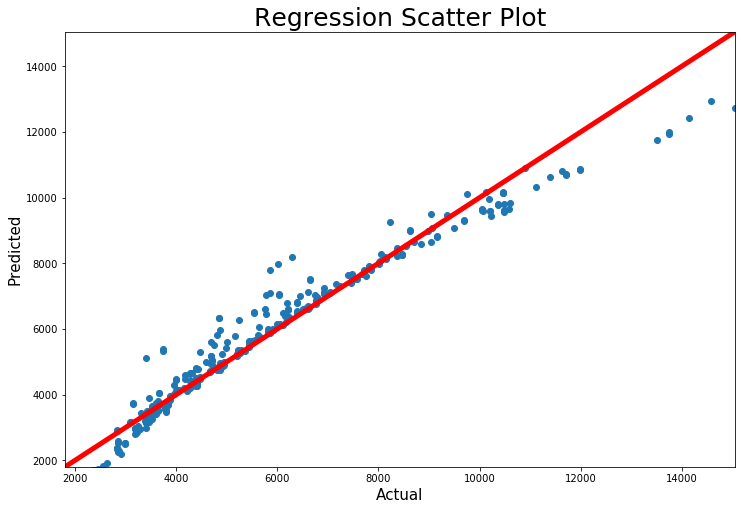

In [302]:
scatter_plot(y_test, en_mod.predict(X_test))

### 4.2. Support Vector Regressor

In [303]:
# Train SVR model using kernel='poly', degree=2, C=1000, and default values for all other hyper-parameters. 
sr =  SVR(kernel='poly',degree=2, C=1000)
sr.fit(X_train, y_train)

SVR(C=1000, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [304]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, sr.predict(X_test)))
print('MSE', mean_squared_error(y_test, sr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, sr.predict(X_test)))**0.5)

MAE 580.3993405401524
MSE 840196.6788439323
RMSE 916.6224298171697


In [305]:
# Hyperparameter optimization (GridSearchCV) for SVR
param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'],'C': [1, 10, 100, 1000],'degree': [2,3,4]}]
  
svr_mod = GridSearchCV(sr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

svr_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1000, cache_size=200, coef0=0.0, degree=2,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [306]:
# Best/optimal values of hyperparameters
print(svr_mod.best_params_)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [307]:
# Performance of the optimal model
print('Scoring: ', svr_mod.best_score_)  

Scoring:  -36841.48817750557


In [308]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, svr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 66.08014013709158
Generalization performance (MSE) 27607.07860367545
Generalization performance (RMSE) 166.15377998611842


In [309]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, svr_mod.predict(X_test)))**0.5)

R2 0.9979381875612967


#### Plotting

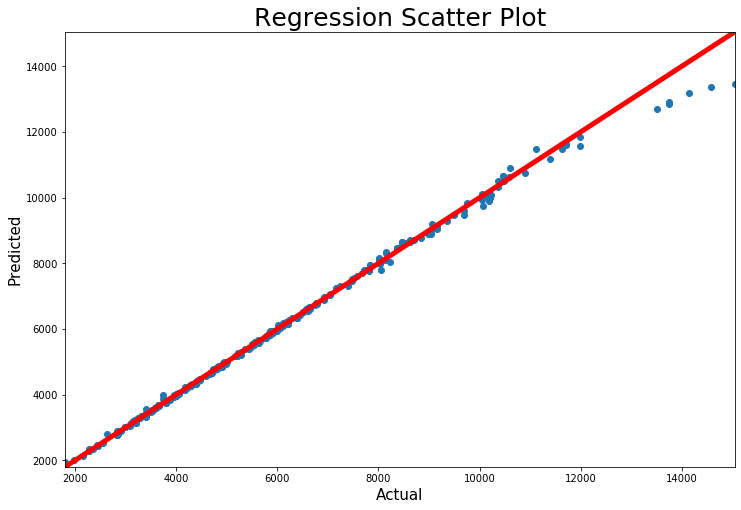

In [310]:
scatter_plot(y_test, svr_mod.predict(X_test))

### 4.3. Random Forest Regressor

In [311]:
# Train the Random Forest Regressor model using 200 estimators and default values for all other hyper-parameters.
rfr =  RandomForestRegressor(n_estimators=200,min_samples_leaf=5)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [312]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, rfr.predict(X_test)))
print('MSE', mean_squared_error(y_test, rfr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, rfr.predict(X_test)))**0.5)

MAE 166.14523690375177
MSE 56165.80035141115
RMSE 236.9932495903863


In [313]:
# Hyperparameter optimization (GridSearchCV) for Random Forest 
param_grid = {'n_estimators':[50, 100, 200, 300],'min_samples_leaf': [1, 3, 5, 10], 'max_depth':[3,4,5], 'max_features':[2,3,4]} 

rf_mod = GridSearchCV(rfr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

rf_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

In [314]:
# Best/optimal values of hyperparameters
print(rf_mod.best_params_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 200}


In [315]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, rf_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 303.70819212800075
Generalization performance (MSE) 156618.86295202063
Generalization performance (RMSE) 395.7510113089045


In [316]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, rf_mod.predict(X_test)))**0.5)

R2 0.9882460268360089


#### Plotting

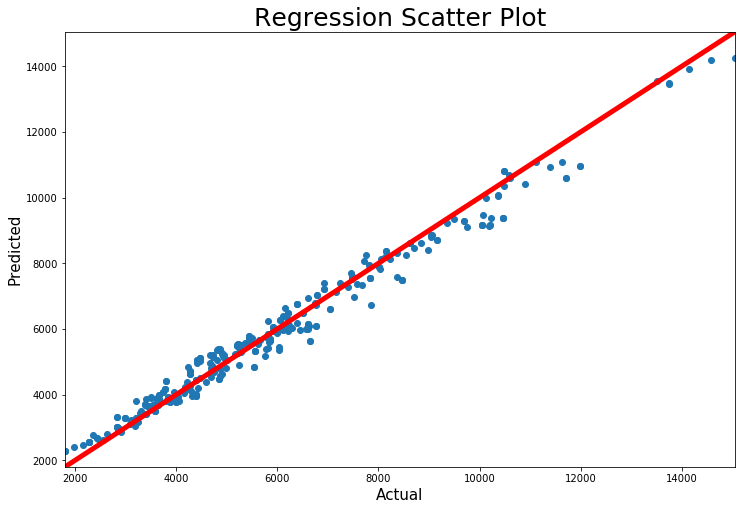

In [317]:
scatter_plot(y_test, rf_mod.predict(X_test))

### 4.4. Gradient Boosting Regressor

In [318]:
# Train the Gradient Boosting Regressor model using n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3
grb = GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3, random_state=0)
grb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [319]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, grb.predict(X_test)))
print('MSE', mean_squared_error(y_test, grb.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, grb.predict(X_test)))**0.5)

MAE 30.482720856354355
MSE 4208.114959511242
RMSE 64.86998504324818


In [320]:
# Hyperparameter optimization (GridSearchCV) for GBR
param_grid = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]}
  
grb_mod = GridSearchCV(grb, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

grb_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='huber', max_depth=4,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=3,
                                                 min_samples_split=2,
                                                 min_w...
                                                 presort='deprecated',
                                          

In [321]:
# Best/optimal values of hyperparameters
print(grb_mod.best_params_) 

{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.5}


In [322]:
# Performance of the optimal model
print('Scoring: ', grb_mod.best_score_)

Scoring:  -8157.8311512311575


In [323]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, grb_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 35.401170097332525
Generalization performance (MSE) 4152.384643990787
Generalization performance (RMSE) 64.43899940246423


In [324]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, grb_mod.predict(X_test)))**0.5)

R2 0.9996901541958539


#### Plotting

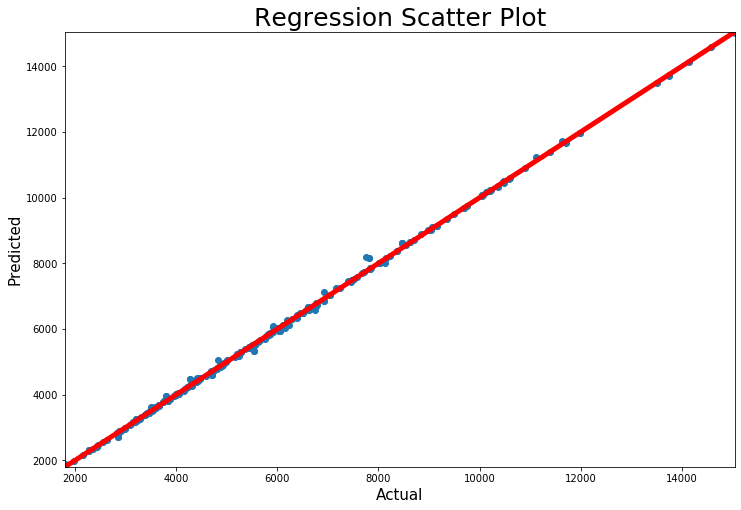

In [325]:
scatter_plot(y_test, grb_mod.predict(X_test))

### 4.5. Neural Network Regressor

In [326]:
# Train the Neural Network Regressor
nnr = MLPRegressor(hidden_layer_sizes=(4,4),activation='relu',alpha=0.001,early_stopping=False,tol=0.001,batch_size=200,max_iter=3000)
nnr.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(4, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=3000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [327]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, nnr.predict(X_test)))
print('MSE', mean_squared_error(y_test, nnr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, nnr.predict(X_test)))**0.5)

MAE 295.2926137084394
MSE 173873.01860360816
RMSE 416.98083721390384


In [328]:
# Hyperparameter optimization (GridSearchCV) for NNR
param_grid = {'solver': ['adam'],
              'activation': ['relu'],
              'hidden_layer_sizes': [(10,5),(7,7),(8,4),(10,10),(10),(100),(20,20),(20,20,20)],
              'batch_size': [100,200,300],
              'learning_rate_init': [0.001, 0.01, 0.05]}
    
nnr_mod = GridSearchCV(nnr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

nnr_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.001,
                                    batch_size=200, beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(4, 4),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=3000, momentum=0.9,
                                    n_iter_no_change=10,
                                    nestero...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'batch_size': [100, 200, 300],
                         'hidden_layer_sizes': [(10, 5), (

In [329]:
# Best/optimal values of hyperparameters
print(nnr_mod.best_params_) 

{'activation': 'relu', 'batch_size': 100, 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.001, 'solver': 'adam'}


In [330]:
# Performance of the optimal model
print('Scoring: ', nnr_mod.best_score_) 

Scoring:  -23308.396939403403


In [331]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, nnr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 64.68847716911114
Generalization performance (MSE) 7423.607883099987
Generalization performance (RMSE) 86.16036143784441


In [332]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, nnr_mod.predict(X_test)))**0.5)

R2 0.9994459919210116


#### Plotting

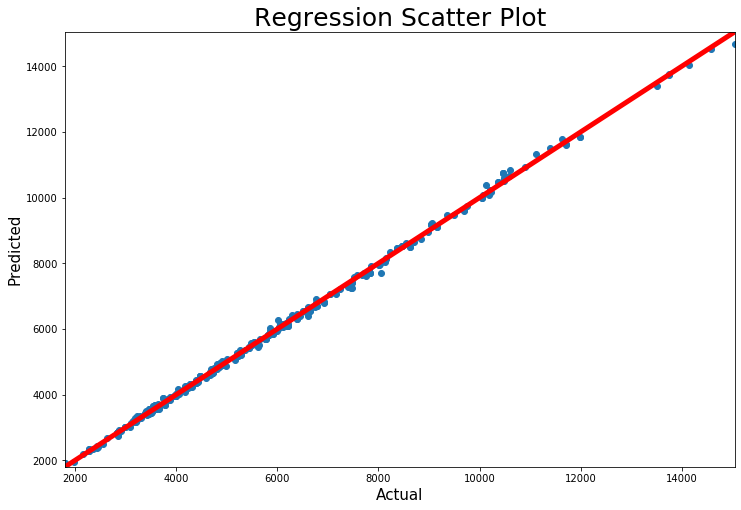

In [333]:
scatter_plot(y_test, nnr_mod.predict(X_test))

### 4.6. Saving Models

In [334]:
#ElasticNet
filename = 'EN_c_cost.sav'
pickle.dump(en_mod, open(filename, 'wb'))

#Support Vector Regressor
filename = 'svr_c_cost.sav'
pickle.dump(svr_mod, open(filename, 'wb'))

#Random Forest Regressor
filename = 'rf_c_cost.sav'
pickle.dump(rf_mod, open(filename, 'wb'))

#Gradient Boosting Regressor
filename = 'grb_c_cost.sav'
pickle.dump(grb_mod, open(filename, 'wb'))

#Neural Network Regressor
filename = 'nnr_c_cost.sav'
pickle.dump(nnr_mod, open(filename, 'wb'))

# 5. Conclusion

### The key features that affect my target (Completion Cost) are:

Using dimensionality reduction:

- L MULTI
- SAND CONC MODEL 
- TVD(M)
- INJ. RATE
- PERM
- PAY THICKNESS

Using Variance inflation factor (multicollinarity):

- AREA (AC) (High correlation with LATERAL SPACING)

### Using seaborn Pearson correlation matrix, the most important features for my target are (top 5): 

1) Fluid Intensity: 0.73

2) Sand Intensity: 0.66

3) Fracture 1/2 Length: 0.65

4) Lateral Length: 0.59

5) Perf Clusters: 0.56

# Model for Target: Netback

#### Target

In [335]:
#Netback
netback=train_target['NETBACK']
netback.head()

653     14.327106
1591    14.497720
1307    15.766205
539     14.814777
682     14.407753
Name: NETBACK, dtype: float64

In [336]:
#Netback
feat_netback=pd.concat([netback, train_feat], axis=1)

### 1.2. Visualization

#### Features and Target (Netback)

In [337]:
feat_target=pd.concat([train_feat, train_target], axis=1)
feat_target.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)       TVD(M)  \
653      1.000                3                  400      349.7  2956.900756   
1591     0.889                2                  200      263.6  2956.900756   
1307     0.889                4                  200      199.4  2956.900756   
539      0.889                4                  200      155.5  2956.900756   
682      1.000                4                  300      263.3  2956.900756   

      LATERAL LENGTH (M)  STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
653                 3500      46             92                 2000.0   
1591                5300      78            156                 1132.1   
1307                4000     116            116                 4500.0   
539                 3100      34             68                 4516.1   
682                 3500      34             68                 3000.0   

      FLUID INTENSITY (M3/M)  ...  EFFECTIVE IRR       PV(10)       PV(15)  \
653                     20.0  ...       0.853884  6930.382442  5358.070652   
1591                     9.5  ...       1.087076  9552.278968  7588.689882   
1307                    18.0  ...       0.728381  7666.190920  6020.435025   
539                     18.1  ...       0.409468  4064.735533  2771.923567   
682                     12.0  ...       0.468071  5073.862174  3468.582212   

       Royalty    PAYOUT       LIFE    NETBACK       F&D  RECYCLE RATIO  \
653   0.082517  1.333333  40.000000  14.327106  5.133588       2.790856   
1591  0.090752  1.166667  40.000000  14.497720  5.089388       2.848618   
1307  0.050019  1.416667  34.166667  15.766205  7.385450       2.134766   
539   0.048097  2.083333  36.583333  14.814777  7.277691       2.035642   
682   0.065236  2.000000  40.000000  14.407753  5.391182       2.672466   

       PV15 PI  
653   1.664542  
1591  1.796763  
1307  1.536067  
539   1.336641  
682   1.455917  

[5 rows x 37 columns]

In [338]:
feat_target.columns

Index(['LL MULTI', 'SAND CONC MODEL', 'LATERAL SPACING (M)', 'AREA (AC)',
       'TVD(M)', 'LATERAL LENGTH (M)', 'STAGES', 'PERF CLUSTERS',
       'SAND INTENSITY(KG.M3)', 'FLUID INTENSITY (M3/M)', 'INJ. RATE', 'PERM',
       'PAY THICKNESS', 'FRACTURE 1/2 LENGTH', 'FRACTURE CONDUCTIVITY',
       'REC. EFFICIENCY (GAS)', 'REC. EFFICIENCY (OIL)', ' DRILLING COST',
       'COMPLETION COST', 'EQUIPMENT COST', 'TOTAL WELL COST', 'IP90 GAS',
       'IP90 OIL', 'IP90 COND', 'GAS (EUR)', 'OIL (EUR)', 'COND (EUR)',
       'EFFECTIVE IRR', 'PV(10)', 'PV(15)', 'Royalty', 'PAYOUT', 'LIFE',
       'NETBACK', 'F&D', 'RECYCLE RATIO', 'PV15 PI'],
      dtype='object')

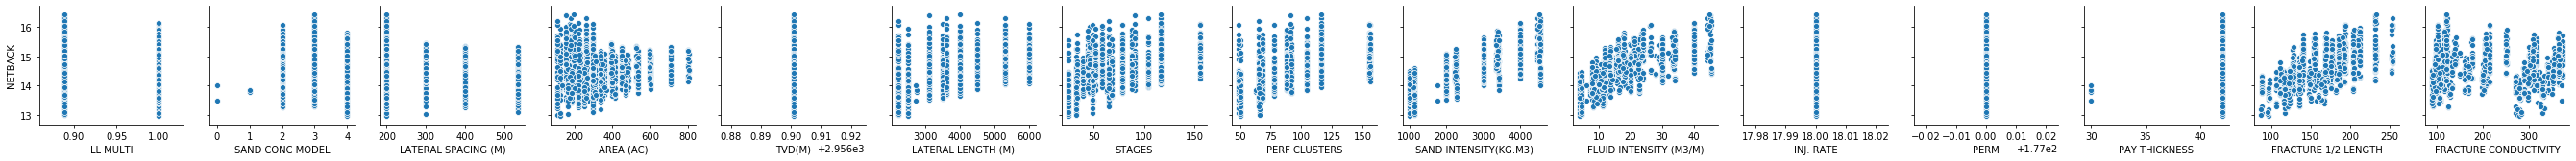

In [339]:
#Netback
sns.pairplot(feat_target, y_vars="NETBACK", x_vars=feat_target.iloc[:,:15].columns.values)
plt.show()

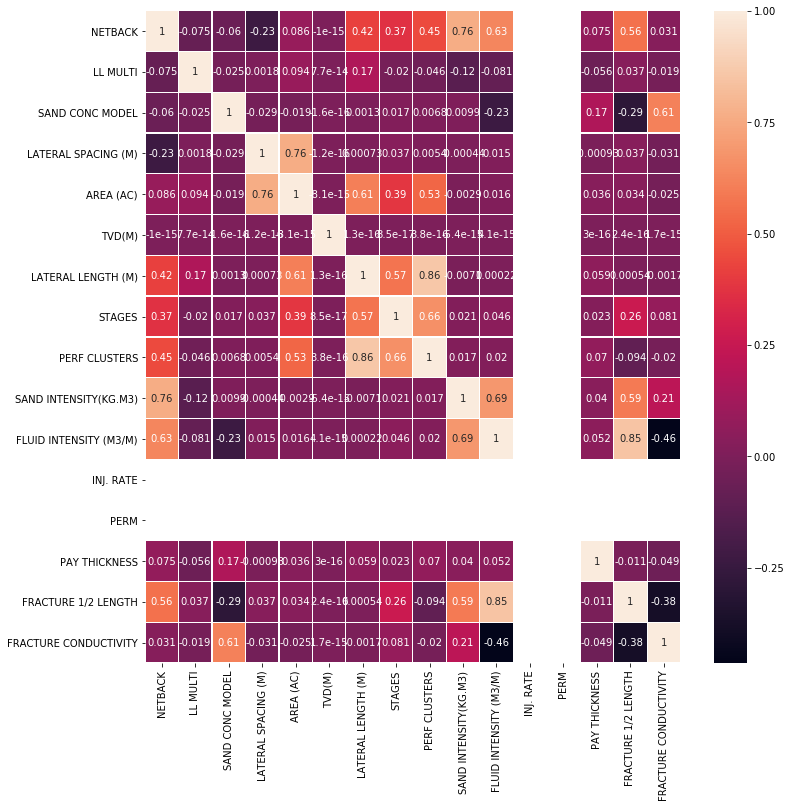

In [340]:
#Correlation matrix (Pearson)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = feat_netback.corr()
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

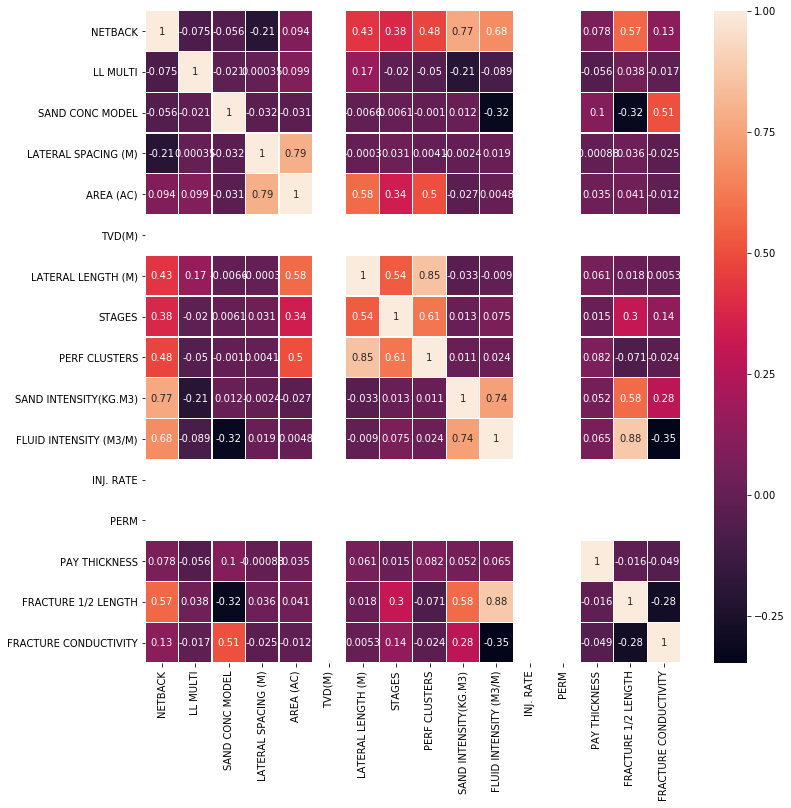

In [341]:
#Correlation matrix (spearman)
fig, ax = plt.subplots(figsize=(12,12))
corrMatrix = feat_netback.corr(method='spearman')
sns.heatmap(corrMatrix, annot=True,linewidths=.3, ax=ax)
plt.show()

In [342]:
def scatter_plot(y_test,y_pred):

    plt.figure(figsize=(12,8))
    ulim = np.max(y_test)
    llim = np.min(y_test)
    plt.scatter(y_test,y_pred)
    plt.plot([llim,ulim],[llim,ulim],linewidth=5, c='red')
    plt.title('Regression Scatter Plot', fontsize=25)
    plt.xlim([llim,ulim])
    plt.ylim([llim,ulim])
    plt.ylabel('Predicted', fontsize=15)
    plt.xlabel('Actual', fontsize=15)
    
    plt.show()

## 2. Data Split (Test/Train): Netback

In [343]:
X_train, X_test, y_train, y_test = train_test_split(train_feat, netback, test_size=0.25, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)
print('Dimensions of y_train:',y_train.shape)
print('Dimensions of y_test:',y_test.shape)

Dimensions of X_train: (963, 15)
Dimensions of X_test: (322, 15)
Dimensions of y_train: (963,)
Dimensions of y_test: (322,)


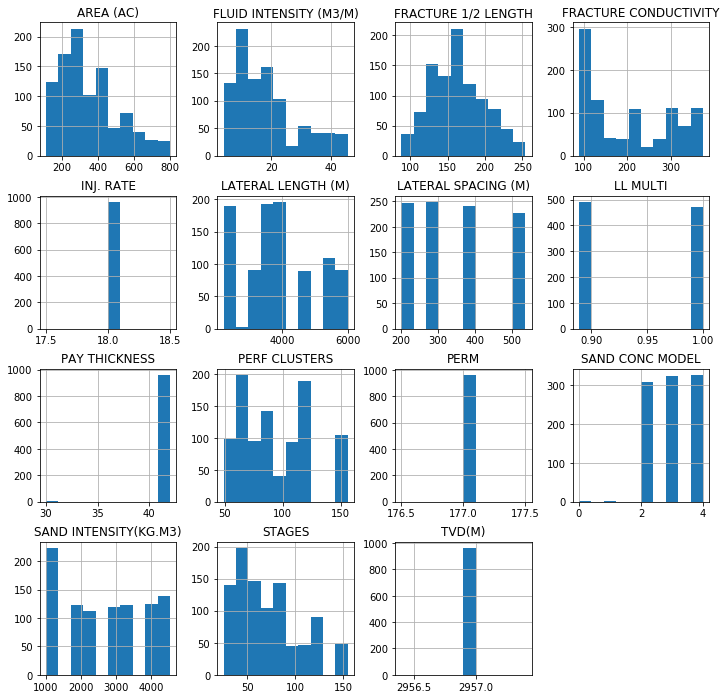

In [344]:
X_train.hist(figsize=(12,12))
plt.show()

In [345]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963 entries, 689 to 1554
Data columns (total 15 columns):
LL MULTI                  963 non-null float64
SAND CONC MODEL           963 non-null int64
LATERAL SPACING (M)       963 non-null int64
AREA (AC)                 963 non-null float64
TVD(M)                    963 non-null float64
LATERAL LENGTH (M)        963 non-null int64
STAGES                    963 non-null int64
PERF CLUSTERS             963 non-null int64
SAND INTENSITY(KG.M3)     963 non-null float64
FLUID INTENSITY (M3/M)    963 non-null float64
INJ. RATE                 963 non-null int64
PERM                      963 non-null int64
PAY THICKNESS             963 non-null int64
FRACTURE 1/2 LENGTH       963 non-null float64
FRACTURE CONDUCTIVITY     963 non-null float64
dtypes: float64(7), int64(8)
memory usage: 120.4 KB


## 3. Data Preprocessing

### 3.1. Feature Transform: MinMax Scaler

In [346]:
mscaler = MinMaxScaler(feature_range=(0, 1))

In [347]:
mscaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [348]:
X_train_scaled = mscaler.transform(X_train) # transform the train dataset to standardized data

# standardized training dataset
print("scaled minimum : %s " % np.min(X_train_scaled,axis=0))
print("scaled maximum : %s " % np.max(X_train_scaled,axis=0))

print("original minimum : %s " % mscaler.data_min_)
print("original maximum : %s " % mscaler.data_max_)

scaled minimum : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
scaled maximum : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 
original minimum : [8.89000000e-01 0.00000000e+00 2.00000000e+02 1.10400000e+02
 2.95690076e+03 2.20000000e+03 2.50000000e+01 4.90000000e+01
 1.00000000e+03 4.00000000e+00 1.80000000e+01 1.77000000e+02
 3.00000000e+01 8.76090940e+01 8.86309190e+01] 
original maximum : [1.00000000e+00 4.00000000e+00 5.36000000e+02 8.01600000e+02
 2.95690076e+03 6.00000000e+03 1.55000000e+02 1.56000000e+02
 4.54550000e+03 4.55000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 2.54072020e+02 3.75121530e+02] 


In [349]:
# scale the test data using the parameters learnt from the training dataset

X_test_scaled  = mscaler.transform(X_test)

print("minimum of scaled test data: %s" % np.min(X_test_scaled,axis=0))
print("maximum of scaled test data: %s " % np.max(X_test_scaled,axis=0))

## median of test data can be non-zero, and the IQR can be non-unitary
## just like the future data

minimum of scaled test data: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
maximum of scaled test data: [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 


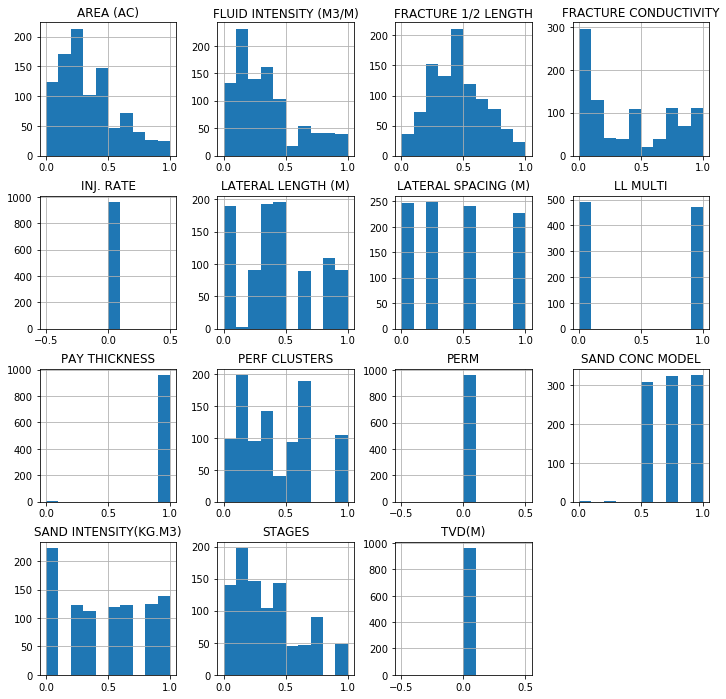

In [350]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

### 3.2. Feature Transform: Robust Scaler

In [351]:
# Robust Scaler
rscaler = RobustScaler() #instantiate
rscaler.fit(X_train) 

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [352]:
X_train_scaled = rscaler.transform(X_train) # transform the train dataset to standardized data

# Original training dataset
print("Original median : %s " % rscaler.center_)
print("Original IQR : %s " % rscaler.scale_)

#Scaled training dataset
print("Scaled median : %s " % np.median(X_train_scaled,axis=0))
print("Scaled IQR : %s " % (np.percentile(X_train_scaled, 75,axis=0)-np.percentile(X_train_scaled, 25,axis=0)))

Original median : [8.89000000e-01 3.00000000e+00 3.00000000e+02 3.09800000e+02
 2.95690076e+03 4.00000000e+03 5.80000000e+01 8.80000000e+01
 3.00000000e+03 1.60000000e+01 1.80000000e+01 1.77000000e+02
 4.20000000e+01 1.56080510e+02 1.77499760e+02] 
Original IQR : [1.11000000e-01 2.00000000e+00 2.00000000e+02 2.25700000e+02
 1.00000000e+00 1.40000000e+03 4.40000000e+01 4.80000000e+01
 2.00000000e+03 1.20000000e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 5.08589900e+01 1.94208065e+02] 
Scaled median : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Scaled IQR : [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.] 


In [353]:
#Scale the test data using the parameters learnt from the training dataset
X_test_scaled  = rscaler.transform(X_test)

print("Median of scaled test data: %s" % np.median(X_test_scaled,axis=0))
print("IQR of scaled test data: %s " % (np.percentile(X_test_scaled, 75,axis=0)-np.percentile(X_test_scaled, 25,axis=0)))

Median of scaled test data: [ 1.          0.          0.5         0.11785556  0.          0.
  0.15909091  0.0625      0.          0.          0.          0.
  0.          0.16016677 -0.04416022]
IQR of scaled test data: [1.         1.         1.18       0.96400089 0.         1.
 1.02272727 1.         0.9261375  0.95625    0.         0.
 0.         1.07477203 0.98993213] 


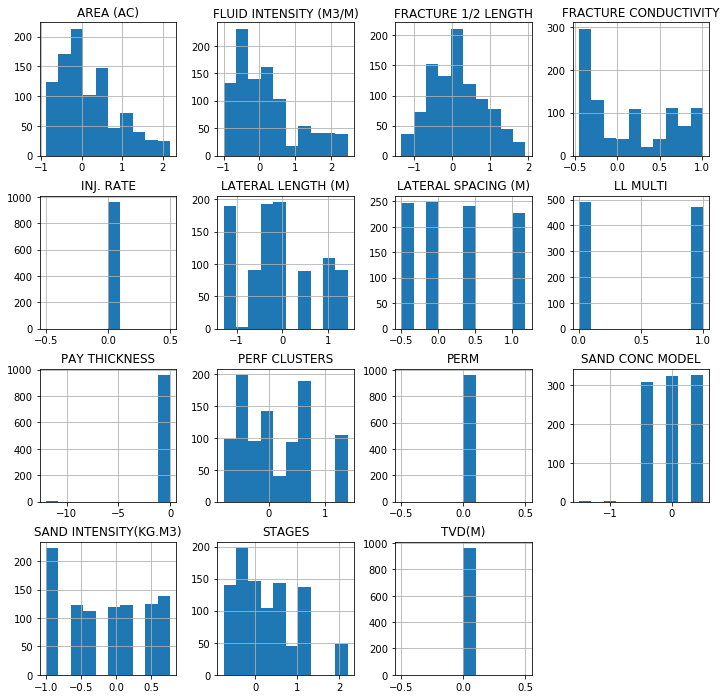

In [354]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist(figsize=(12,12))
plt.show()

In [355]:
X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)

- Scaling is needed because the features have different ranges

### 3.3. Outlier Detection: Isolation Forest

In [356]:
# Isolation Forest
iforest = IsolationForest(n_estimators=200, contamination=0.08)
iforest = iforest.fit(X_train) #Training the model

In [357]:
#Predictions
X_train_predict = iforest.predict(X_train) 
X_train['Predict']=X_train_predict
X_train['Predict'] = X_train['Predict'].astype('category')
X_train

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   
...        ...              ...                  ...        ...     ...   
792        0.0             -0.5                 1.18   0.767390     0.0   
1617       0.0              0.0                 0.50   0.968542     0.0   
139        0.0              0.0                -0.50  -0.880815     0.0   
1803       1.0              0.0                -0.50  -0.047408     0.0   
1554       0.0              0.0                 0.00   0.383252     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   
...                  ...       ...            ...                    ...   
792            -0.285714  0.454545      -0.208333               -0.94445   
1617            0.928571  0.000000       0.583333               -0.36790   
139            -1.285714 -0.204545      -0.812500                0.20455   
1803            1.428571  1.318182       0.583333               -0.50000   
1554            0.928571  0.000000       0.583333               -0.93395   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   
...                      ...        ...   ...            ...   
792                -0.358333        0.0   0.0            0.0   
1617                0.550000        0.0   0.0            0.0   
139                 1.508333        0.0   0.0            0.0   
1803                0.333333        0.0   0.0            0.0   
1554               -0.391667        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY Predict  
689              0.262798               0.967360       1  
1740            -0.117428              -0.367979      -1  
945              0.736783               0.187212       1  
1576            -1.149778               0.541919      -1  
131              0.705289              -0.394607       1  
...                   ...                    ...     ...  
792              0.222537              -0.377114       1  
1617             0.288366              -0.410321       1  
139              1.487818              -0.295266       1  
1803             0.967157              -0.315834       1  
1554            -0.379853              -0.441523       1  

[963 rows x 16 columns]

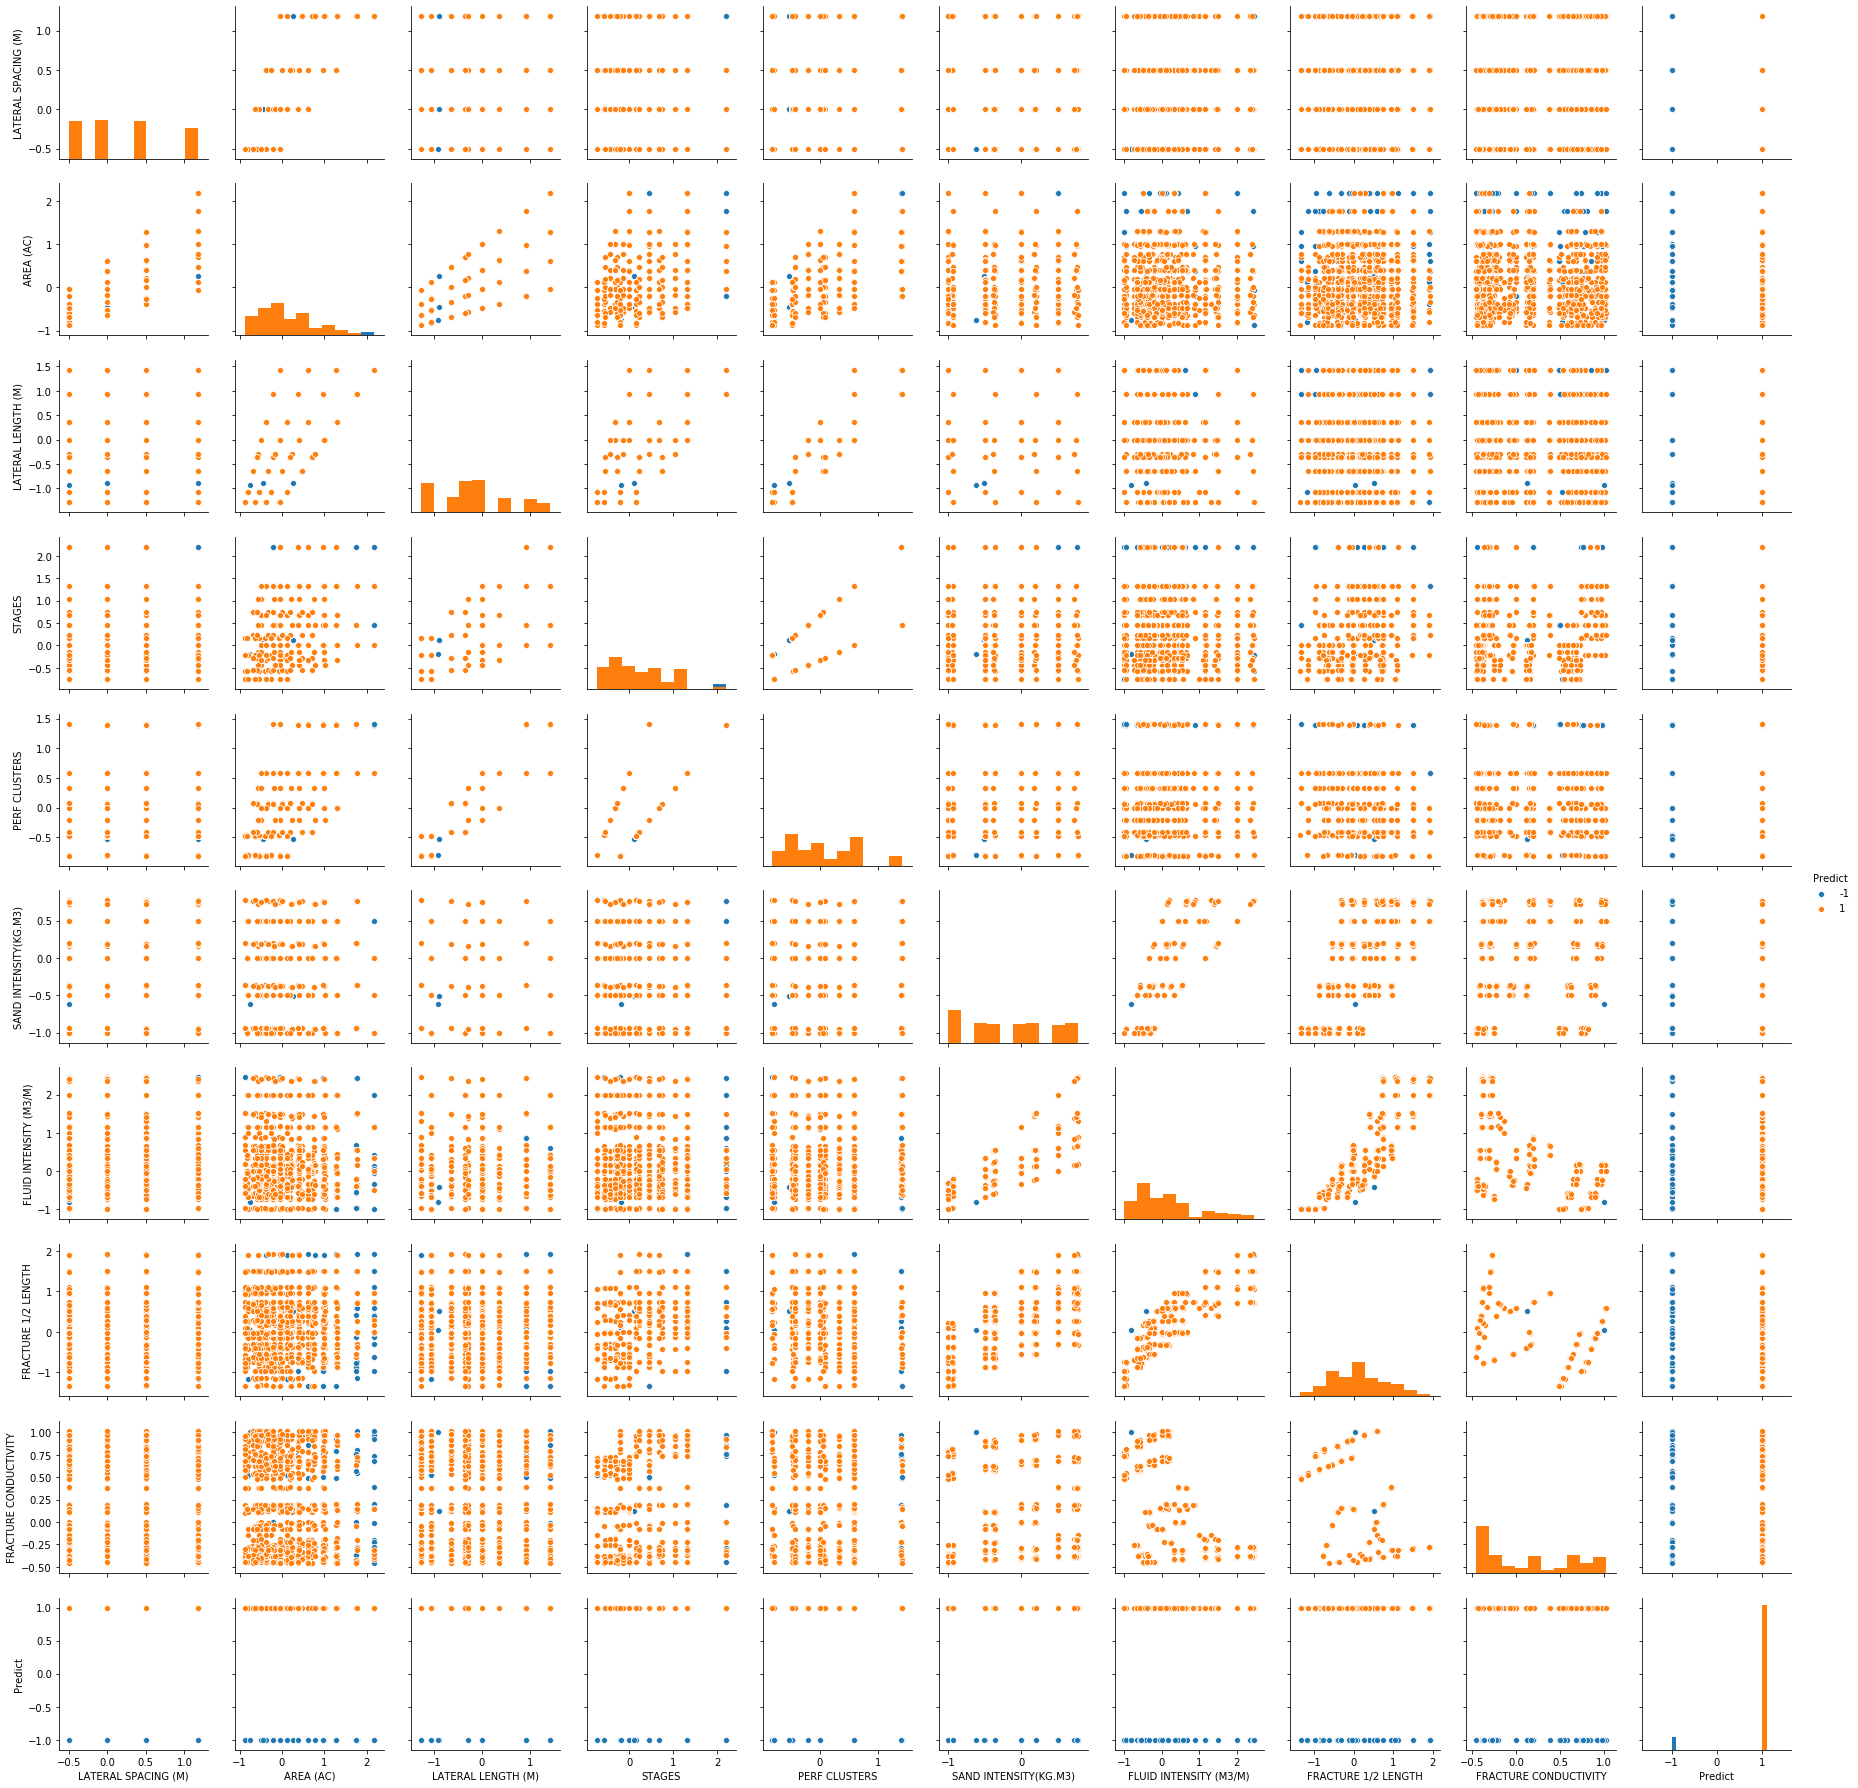

In [358]:
#Visualization
sns.pairplot(X_train.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'], axis = 1),hue='Predict',diag_kind='hist')
plt.show()

In [359]:
#Removing Outliers
#X_train['y_train']=y_train
#X_train = X_train[X_train['Predict'] == 1]

#y_train=X_train['y_train']
#X_train = X_train.drop(['Predict','y_train'], axis = 1)

- Outlier Detection was not perform since it doesn't display outliers

In [360]:
print(len(X_train))
print(len(y_train))

963
963


In [361]:
X_train = X_train.drop(['Predict'], axis = 1)

In [362]:
X_train.head()

LL MULTI  SAND CONC MODEL  LATERAL SPACING (M)  AREA (AC)  TVD(M)  \
689        1.0              0.5                 0.50   0.182986     0.0   
1740       1.0              0.0                 1.18   2.171023     0.0   
945        0.0             -0.5                 0.50   0.219318     0.0   
1576       0.0              0.5                 1.18   1.764732     0.0   
131        0.0              0.0                -0.50  -0.881258     0.0   

      LATERAL LENGTH (M)    STAGES  PERF CLUSTERS  SAND INTENSITY(KG.M3)  \
689            -0.357143  0.227273      -0.416667                0.00000   
1740            1.428571  2.204545       1.395833               -1.00000   
945            -0.285714  1.045455       0.333333                0.72220   
1576            0.928571  0.000000       0.583333               -0.93395   
131            -1.285714 -0.750000      -0.791667                0.20455   

      FLUID INTENSITY (M3/M)  INJ. RATE  PERM  PAY THICKNESS  \
689                -0.333333        0.0   0.0            0.0   
1740               -0.500000        0.0   0.0            0.0   
945                 0.841667        0.0   0.0            0.0   
1576               -0.958333        0.0   0.0            0.0   
131                 1.508333        0.0   0.0            0.0   

      FRACTURE 1/2 LENGTH  FRACTURE CONDUCTIVITY  
689              0.262798               0.967360  
1740            -0.117428              -0.367979  
945              0.736783               0.187212  
1576            -1.149778               0.541919  
131              0.705289              -0.394607

### 3.4. Dimensionality Reduction

#### ANOVA F-value and Mutual Information Value (X/Y): Correlation between X (features) and Y (target)

In [363]:
X_train_corr =X_train.drop(['TVD(M)','INJ. RATE','PERM'], axis = 1)

In [364]:
#f_test: Linear correlation between X and Y
f_test, _ = f_regression(X_train_corr, y_train) 
f_test /= np.max(f_test) # normalize f value

#mi: Nonlinear correlation between X and Y
mi = mutual_info_regression(X_train_corr, y_train) 
mi /= np.max(mi) # normalize mi value

In [365]:
print(f_test)
print(mi)

[7.02617711e-03 4.58030659e-03 3.90182269e-02 6.43081281e-03
 1.49755263e-01 1.20672477e-01 1.92040072e-01 1.00000000e+00
 5.01341337e-01 3.10171686e-03 3.41212816e-01 2.27037306e-04]
[0.04079376 0.         0.18704546 0.17155543 0.42437365 0.55040892
 0.53246548 1.         0.74376961 0.         0.75634507 0.55847681]


Text(0.5, 1.0, 'f_test value')

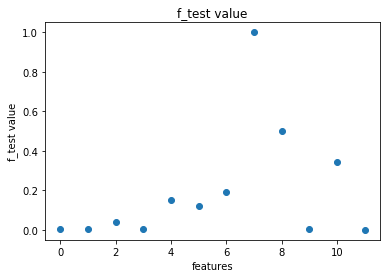

In [366]:
#Plot f_test
plt.figure()
plt.plot(f_test, 'o')
plt.ylabel('f_test value')
plt.xlabel('features')
plt.title('f_test value')

Text(0.5, 1.0, 'mi value')

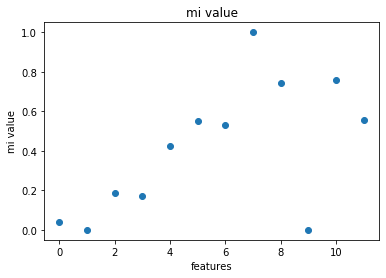

In [367]:
#Plot mi value
plt.figure()
plt.plot(mi, 'o')
plt.ylabel('mi value')
plt.xlabel('features')
plt.title('mi value')

- Large value of f_test indicates the feature is significant (linear correlation XY)
- Large value of mi indicates the feature is significant (nonlinear correlation XY)

#### Variance inflation factor (VIF): Multicollinarity analysis

In [368]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [369]:
calc_vif(X_train)

variables        VIF
0                 LL MULTI   2.115143
1          SAND CONC MODEL   2.130444
2      LATERAL SPACING (M)  15.350539
3                AREA (AC)  21.973528
4                   TVD(M)        NaN
5       LATERAL LENGTH (M)  14.655486
6                   STAGES   8.890235
7            PERF CLUSTERS  14.682333
8    SAND INTENSITY(KG.M3)   6.030387
9   FLUID INTENSITY (M3/M)  12.941499
10               INJ. RATE        NaN
11                    PERM        NaN
12           PAY THICKNESS   1.099520
13     FRACTURE 1/2 LENGTH  18.340667
14   FRACTURE CONDUCTIVITY   5.936741

- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [370]:
X_train_red =X_train.drop(['AREA (AC)'], axis = 1)
X_test_red =X_test.drop(['AREA (AC)'], axis = 1)

In [371]:
calc_vif(X_train_red)

variables        VIF
0                 LL MULTI   2.109764
1          SAND CONC MODEL   2.127629
2      LATERAL SPACING (M)   1.183535
3                   TVD(M)        NaN
4       LATERAL LENGTH (M)   5.500174
5                   STAGES   8.862214
6            PERF CLUSTERS  14.590940
7    SAND INTENSITY(KG.M3)   5.985676
8   FLUID INTENSITY (M3/M)  12.939862
9                INJ. RATE        NaN
10                    PERM        NaN
11           PAY THICKNESS   1.098881
12     FRACTURE 1/2 LENGTH  18.305325
13   FRACTURE CONDUCTIVITY   5.893039

In [372]:
X_train=X_train_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
X_test=X_test_red.drop(['LL MULTI','SAND CONC MODEL','TVD(M)','INJ. RATE', 'PERM','PAY THICKNESS'],axis=1)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (963, 8)
Dimensions of X_test: (322, 8)


## 4. Models

In [373]:
#Cross validation on training data (5-Fold)
cv = KFold(n_splits=5, shuffle = True, random_state=125) # instance

### 4.1. ElasticNet

In [374]:
# Train the ElasticNet model using alpha = 1, l1_ratio = 0.5, and default values for all other hyper-parameters. 
en = ElasticNet(alpha=1,l1_ratio=0.5)
en.fit(X_train, y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [375]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, en.predict(X_test)))
print('MSE', mean_squared_error(y_test, en.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, en.predict(X_test)))**0.5)

MAE 0.4403101954422884
MSE 0.301666227458924
RMSE 0.5492415019451135


In [376]:
# Hyperparameter optimization (GridSearchCV) for ELasticNet Model

param_grid = {'alpha': [0.01, 0.05, 0.1, 0.15], 'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]} 

en_mod = GridSearchCV(en, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  

en_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.15],
                         'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [377]:
# Best/optimal values of hyperparameters
print(en_mod.best_params_)

{'alpha': 0.01, 'l1_ratio': 0.1}


In [378]:
# Performance of the optimal model
print('Scoring: ', en_mod.best_score_) 

Scoring:  -0.0479266855746091


In [379]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, en_mod.predict(X_test)))
print('MSE', mean_squared_error(y_test, en_mod.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, en_mod.predict(X_test)))**0.5)

MAE 0.14332206189090768
MSE 0.037818211377667575
RMSE 0.19446904992226288


In [380]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, en_mod.predict(X_test)))**0.5)

R2 0.9350972074248637


#### Plotting

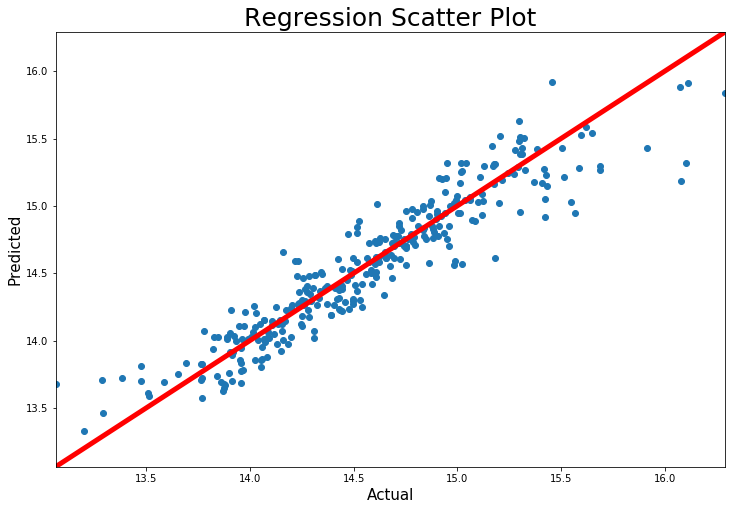

In [381]:
scatter_plot(y_test, en_mod.predict(X_test))

### 4.2. Support Vector Regressor

In [382]:
# Train SVR model using kernel='poly', degree=2, C=1000, and default values for all other hyper-parameters. 
sr =  SVR(kernel='poly',degree=2, C=1000)
sr.fit(X_train, y_train)

SVR(C=1000, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [383]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, sr.predict(X_test)))
print('MSE', mean_squared_error(y_test, sr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, sr.predict(X_test)))**0.5)

MAE 0.15698387556415605
MSE 0.04343249034690812
RMSE 0.20840463129908635


In [384]:
# Hyperparameter optimization (GridSearchCV) for SVR
param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'],'C': [1, 10, 100, 1000],'degree': [2,3,4]}]
  
svr_mod = GridSearchCV(sr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

svr_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1000, cache_size=200, coef0=0.0, degree=2,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [385]:
# Best/optimal values of hyperparameters
print(svr_mod.best_params_)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [386]:
# Performance of the optimal model
print('Scoring: ', svr_mod.best_score_) 

Scoring:  -0.005587342080747777


In [387]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, svr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, svr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 0.054397289070323845
Generalization performance (MSE) 0.0046708095097856795
Generalization performance (RMSE) 0.06834332088643102


In [388]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, svr_mod.predict(X_test)))**0.5)

R2 0.9922138748471768


#### Plotting

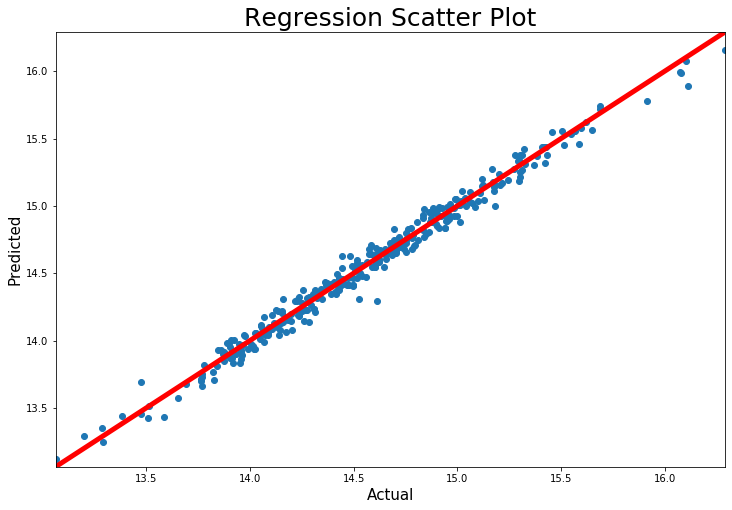

In [389]:
scatter_plot(y_test, svr_mod.predict(X_test))

### 4.3. Random Forest Regressor

In [390]:
# Train the Random Forest Regressor model using 200 estimators and default values for all other hyper-parameters.
rfr =  RandomForestRegressor(n_estimators=200,min_samples_leaf=5)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [391]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, rfr.predict(X_test)))
print('MSE', mean_squared_error(y_test, rfr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, rfr.predict(X_test)))**0.5)

MAE 0.056695975462243524
MSE 0.007372505139726454
RMSE 0.08586329331982587


In [392]:
# Hyperparameter optimization (GridSearchCV) for Random Forest 
param_grid = {'n_estimators':[50, 100, 200, 300],'min_samples_leaf': [1, 3, 5, 10], 'max_depth':[3,4,5], 'max_features':[2,3,4]} 

rf_mod = GridSearchCV(rfr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

rf_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

In [393]:
# Best/optimal values of hyperparameters
print(rf_mod.best_params_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 200}


In [394]:
# Performance of the optimal model
print('Scoring: ', rf_mod.best_score_) 

Scoring:  -0.015647224488224067


In [395]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, rf_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, rf_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 0.08726141194876691
Generalization performance (MSE) 0.013629090661159969
Generalization performance (RMSE) 0.11674369645149998


In [396]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, rf_mod.predict(X_test)))**0.5)

R2 0.9771070435522057


#### Plotting

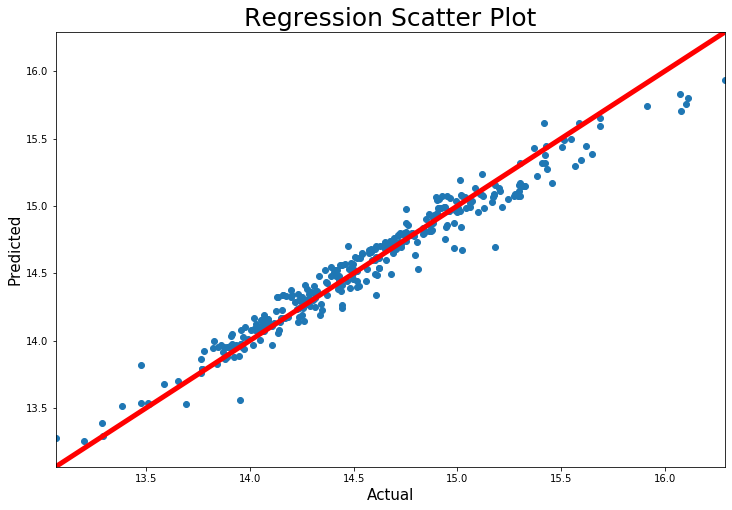

In [397]:
scatter_plot(y_test, rf_mod.predict(X_test))

### 4.4. Gradient Boosting Regressor

In [398]:
# Train the Gradient Boosting Regressor model using n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3
grb = GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1, loss='huber', min_samples_leaf=3, random_state=0)
grb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [416]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, grb.predict(X_test)))
print('MSE', mean_squared_error(y_test, grb.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, grb.predict(X_test)))**0.5)

MAE 0.030383126542232075
MSE 0.0026142392826941675
RMSE 0.0511296321392416


In [418]:
# Hyperparameter optimization (GridSearchCV) for GBR
param_grid = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]}
  
grb_mod = GridSearchCV(grb, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

grb_mod.fit(X_train, y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='huber', max_depth=4,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=3,
                                                 min_samples_split=2,
                                                 min_w...
                                                 presort='deprecated',
                                          

In [419]:
# Best/optimal values of hyperparameters
print(grb_mod.best_params_) 

{'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.2}


In [420]:
# Performance of the optimal model
print('Scoring: ', grb_mod.best_score_) 

Scoring:  -0.0020746273825821017


In [421]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, grb_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, grb_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 0.022357855289135697
Generalization performance (MSE) 0.0016933081302160828
Generalization performance (RMSE) 0.04114982539715184


In [422]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, grb_mod.predict(X_test)))**0.5)

R2 0.9971843217222666


#### Ploting

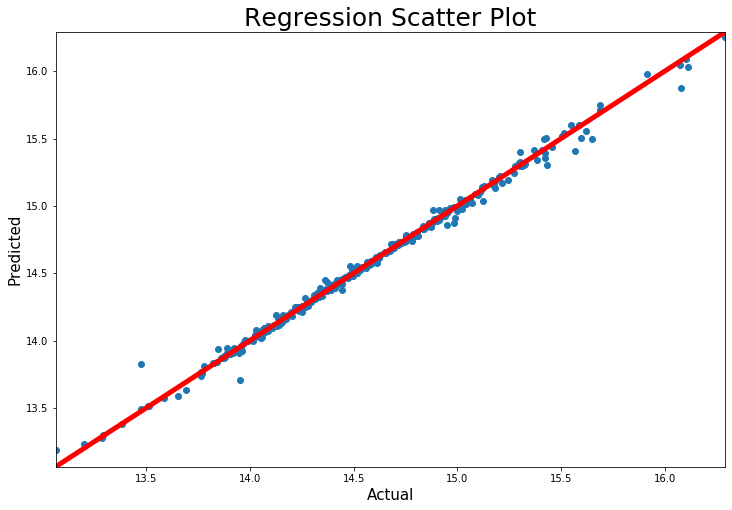

In [423]:
scatter_plot(y_test, grb_mod.predict(X_test))

### 4.5. Neural Network Regressor

In [424]:
# Train the Neural Network Regressor
nnr = MLPRegressor(hidden_layer_sizes=(4,4),activation='relu',alpha=0.001,early_stopping=False,tol=0.001,batch_size=200,max_iter=3000)
nnr.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(4, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=3000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [425]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('MAE', mean_absolute_error(y_test, nnr.predict(X_test)))
print('MSE', mean_squared_error(y_test, nnr.predict(X_test)))
print('RMSE', (mean_squared_error(y_test, nnr.predict(X_test)))**0.5)

MAE 0.35606252435489244
MSE 0.19722275181156568
RMSE 0.4440976827360909


In [426]:
# Hyperparameter optimization (GridSearchCV) for NNR
param_grid = {'solver': ['adam'],
              'activation': ['relu'],
              'hidden_layer_sizes': [(10,5),(7,7),(8,4),(10,10),(10),(100),(20,20),(20,20,20)],
              'batch_size': [100,200,300],
              'learning_rate_init': [0.001, 0.01, 0.05]}
    
nnr_mod = GridSearchCV(nnr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error') 

nnr_mod.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=125, shuffle=True),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.001,
                                    batch_size=200, beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(4, 4),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=3000, momentum=0.9,
                                    n_iter_no_change=10,
                                    nestero...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'batch_size': [100, 200, 300],
                         'hidden_layer_sizes': [(10, 5), (

In [427]:
# Best/optimal values of hyperparameters
print(nnr_mod.best_params_) 

{'activation': 'relu', 'batch_size': 100, 'hidden_layer_sizes': (20, 20, 20), 'learning_rate_init': 0.05, 'solver': 'adam'}


In [428]:
# Performance of the optimal model
print('Scoring: ', nnr_mod.best_score_) 

Scoring:  -0.019152728248854636


In [429]:
# Performance of the optimal model (MAE, MSE and RMSE)
print('Generalization performance (MAE)', mean_absolute_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (MSE)', mean_squared_error(y_test, nnr_mod.predict(X_test)))
print('Generalization performance (RMSE)', (mean_squared_error(y_test, nnr_mod.predict(X_test)))**0.5)

Generalization performance (MAE) 0.09994263913601659
Generalization performance (MSE) 0.015324714689922856
Generalization performance (RMSE) 0.12379303166948799


In [430]:
# Performance of the optimal model (R2)
print('R2', (r2_score(y_test, nnr_mod.predict(X_test)))**0.5)

R2 0.9742212556777412


#### Plotting

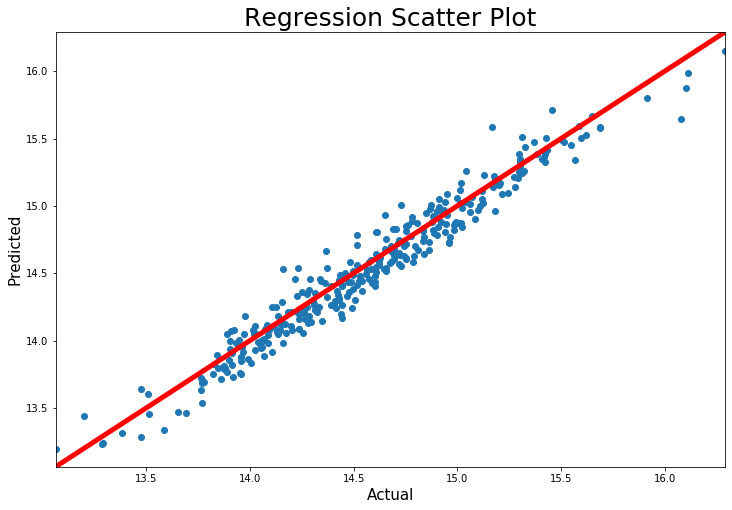

In [431]:
scatter_plot(y_test, nnr_mod.predict(X_test))

### 4.6. Saving Models

In [432]:
#ElasticNet
filename = 'EN_net.sav'
pickle.dump(en_mod, open(filename, 'wb'))

#Support Vector Regressor
filename = 'svr_net.sav'
pickle.dump(svr_mod, open(filename, 'wb'))

#Random Forest Regressor
filename = 'rf_net.sav'
pickle.dump(rf_mod, open(filename, 'wb'))

#Gradient Boosting Regressor
filename = 'grb_net.sav'
pickle.dump(grb_mod, open(filename, 'wb'))

#Neural Network Regressor
filename = 'nnr_net.sav'
pickle.dump(nnr_mod, open(filename, 'wb'))

In [433]:
# save scaling model
filename = 'scale_rscaler.sav'
pickle.dump(rscaler, open(filename, 'wb'))

# 5. Conclusion

### The key features that affect my target (Netback) are:

Using dimensionality reduction:

- L MULTI
- SAND CONC MODEL 
- TVD(M)
- INJ. RATE
- PERM
- PAY THICKNESS

Using Variance inflation factor (multicollinarity):

- AREA (AC) (High correlation with LATERAL SPACING)

### Using seaborn Pearson correlation matrix, the most important features for my target are (top 5): 

1) Fluid Intensity: 0.76

2) Sand Intensity: 0.63

3) Fracture 1/2 Length: 0.56

4) Perf Clusters: 0.45

5) Lateral Length: 0.42